In [1]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs

# =========================
# Universal color utilities
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
from pathlib import Path
import datetime as _dt

COLOR_TEMPLATES = {
    # Colorblind-safe (Okabe–Ito)
    "okabeito": ["#0072B2", "#D55E00", "#009E73", "#CC79A7",
                 "#F0E442", "#56B4E9", "#E69F00", "#000000"],
    # Tableau-10 as an alternative
    "tableau10": [plt.get_cmap("tab10")(i) for i in range(10)],
}

def build_color_map(labels, template="okabeito", custom=None, order=None):
    """
    Return dict {label -> color}. If you want stable per-animal colors across figures,
    pass a canonical 'order' (list of all animals) or pass an explicit color_map to the
    plotting functions.
    """
    labs = list(order) if order is not None else list(labels)
    base = list(custom) if custom is not None else list(COLOR_TEMPLATES.get(template, COLOR_TEMPLATES["okabeito"]))
    return {lab: base[i % len(base)] for i, lab in enumerate(labs)}

def set_axes_color_cycle(ax, labels, color_map):
    ax.set_prop_cycle(cycler(color=[color_map[l] for l in labels]))


# ============================================================
# ISI density traces from block_collection (accepts color_map)
# ============================================================
def _collect_events_from_blocks(block_collection):
    rows = []
    for b in block_collection:
        animal = getattr(b, 'animal_call', None)
        blockn = getattr(b, 'block_num', None)
        for eye, sdf in (('L', getattr(b, 'l_saccade_df', None)),
                         ('R', getattr(b, 'r_saccade_df', None))):
            if sdf is None or len(sdf) == 0: continue
            s_on = pd.to_numeric(sdf.get('saccade_on_ms', pd.Series([], dtype='float64')), errors='coerce')
            hm = sdf['head_movement'] if 'head_movement' in sdf.columns else pd.Series(False, index=sdf.index)
            rows.append(pd.DataFrame({
                'animal': animal, 'block': blockn, 'eye': eye,
                'saccade_on_ms': s_on, 'head_movement': hm.astype(bool)
            }).dropna(subset=['saccade_on_ms']))
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(
        columns=['animal','block','eye','saccade_on_ms','head_movement'])

def _estimate_frame_interval_ms(block_collection, fallback_ms=16.67):
    dts=[]
    for b in block_collection:
        for df in (getattr(b,'left_eye_data',None), getattr(b,'right_eye_data',None)):
            if df is None or 'ms_axis' not in df.columns: continue
            ms = pd.to_numeric(df['ms_axis'], errors='coerce').dropna().to_numpy()
            if ms.size>3:
                dt = np.diff(ms); dt = dt[(dt>0)&np.isfinite(dt)]
                if dt.size: dts.append(np.median(dt))
    return float(np.median(dts)) if dts else float(fallback_ms)

def _dedupe_lr_pairs(events_df, pair_threshold_ms=60.0):
    out=[]
    for (animal,block), g in events_df.groupby(['animal','block'], dropna=False):
        L = g[g['eye']=='L'].sort_values('saccade_on_ms')
        R = g[g['eye']=='R'].sort_values('saccade_on_ms')
        lt, rt = L['saccade_on_ms'].to_numpy(float), R['saccade_on_ms'].to_numpy(float)
        lhm = L['head_movement'].to_numpy(bool) if len(L) else np.array([],bool)
        rhm = R['head_movement'].to_numpy(bool) if len(R) else np.array([],bool)
        i=j=0; ev_t=[]; ev_hm=[]
        while i<len(lt) and j<len(rt):
            dt = lt[i]-rt[j]
            if abs(dt)<=pair_threshold_ms:
                ev_t.append(min(lt[i],rt[j])); ev_hm.append(bool(lhm[i] or rhm[j])); i+=1; j+=1
            elif lt[i] < rt[j]-pair_threshold_ms:
                ev_t.append(lt[i]); ev_hm.append(bool(lhm[i])); i+=1
            else:
                ev_t.append(rt[j]); ev_hm.append(bool(rhm[j])); j+=1
        while i<len(lt): ev_t.append(lt[i]); ev_hm.append(bool(lhm[i])); i+=1
        while j<len(rt): ev_t.append(rt[j]); ev_hm.append(bool(rhm[j])); j+=1
        out.append(pd.DataFrame({'animal':animal,'block':block,'event_time_ms':ev_t,'head_movement':ev_hm}))
    return pd.concat(out, ignore_index=True) if out else pd.DataFrame(
        columns=['animal','block','event_time_ms','head_movement'])

def _compute_blockwise_isis(dedup_df, min_isi_ms):
    isi_all={}
    for (animal,block), g in dedup_df.groupby(['animal','block'], dropna=False):
        t = np.sort(g['event_time_ms'].to_numpy())
        if t.size>1:
            d = np.diff(t); d = d[np.isfinite(d) & (d>=min_isi_ms)]
            if d.size: isi_all.setdefault(animal,[]).append(d)
    return {a:(np.concatenate(v) if v else np.array([],float)) for a,v in isi_all.items()}

def _snapped_log_bins(num_bins, frame_ms, low_ms, high_ms, add_leading_zero_bin=True):
    # snap edges to (k+0.5)*Δt so each bin contains ≥1 realizable ISI (k*Δt)
    raw = np.geomspace(low_ms, high_ms, int(num_bins)+1)
    k_edges = np.floor(raw/frame_ms) + 0.5
    kmax = int(np.floor(high_ms/frame_ms))
    k_edges = np.clip(k_edges, 0.5, kmax+0.5)
    k_edges = np.unique(k_edges)
    if add_leading_zero_bin and (k_edges.size==0 or not np.isclose(k_edges[0],0.5)):
        k_edges = np.r_[0.25, k_edges]          # dummy zero-count bin
    if k_edges[-1] < (kmax+0.5):
        k_edges = np.r_[k_edges, (kmax+0.5)]
    return k_edges * frame_ms

def export_inter_saccade_intervals_density_traces_from_blocks(
    block_collection,
    figure_size=(1.8, 1.2),
    export_path=None,
    plot_name='ISI_histogram.pdf',
    num_bins=20,
    high_ms=20000.0,
    pair_threshold_ms=60.0,
    min_isi_ms=None,          # if None -> 0.75 * frame_ms
    first_bin_factor=0.5,     # first real edge = 0.5×Δt
    add_leading_zero_bin=True,
    font_family='Arial',
    color_template="okabeito",
    custom_colors=None,
    color_map=None,            # <-- pass a dict {'PV_62':'#...', ...} to lock colors
    xlim=None
):
    # Collect & dedupe
    events = _collect_events_from_blocks(block_collection)
    if events.empty: raise ValueError("No saccade events found.")
    dedup = _dedupe_lr_pairs(events, pair_threshold_ms=pair_threshold_ms)

    # Frame interval & ISIs
    frame_ms = _estimate_frame_interval_ms(block_collection)
    min_isi_eff = (0.75*frame_ms) if (min_isi_ms is None) else float(min_isi_ms)
    isi_all = _compute_blockwise_isis(dedup, min_isi_ms=min_isi_eff)
    animals = sorted(dedup['animal'].dropna().unique())

    # Colors
    if color_map is None:
        cmap = build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
    else:
        # ensure every animal has a color; fall back to template if needed
        fallback = build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
        cmap = {a: color_map.get(a, fallback[a]) for a in animals}

    # Binning
    low_ms = max(1e-6, first_bin_factor*frame_ms)
    bins = _snapped_log_bins(num_bins, frame_ms, low_ms, float(high_ms), add_leading_zero_bin)
    bin_centers = np.sqrt(bins[:-1]*bins[1:])

    # Style & plot
    plt.rcParams['font.family'] = 'sans-serif'; plt.rcParams['font.sans-serif'] = [font_family]
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)
    legend_handles, legend_labels = [], []

    for a in animals:
        isi = isi_all.get(a, np.array([]))
        if isi.size==0: continue
        hist, _ = np.histogram(isi, bins=bins)
        dens = hist/hist.sum() if hist.sum()>0 else hist
        if add_leading_zero_bin:
            x_plot = np.r_[bins[0], bin_centers[1:]]; y_plot = np.r_[0.0, dens[1:]]
        else:
            x_plot, y_plot = bin_centers, dens
        h, = ax.plot(x_plot, y_plot, linewidth=1.2, color=cmap[a], label=str(a))
        legend_handles.append(h); legend_labels.append(str(a))

    ax.set_xscale('log');
    if xlim is not None:
        ax.set_xlim(xlim[0],xlim[1])
    else:
        ax.set_xlim(bins[0], bins[-1])

    ax.set_xlabel('ISI [ms]', fontsize=10); ax.set_ylabel('Probability', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8, length=5, width=1, direction='out')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.grid(False)
    plt.tight_layout()

    out = {'dedup_events': dedup, 'isi_all': isi_all, 'frame_ms': frame_ms, 'bins': bins, 'color_map': cmap}

    # Export main plot + separate legend
    if export_path is not None:
        ts = _dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        outdir = Path(export_path) / f"inter_saccade_export_{ts}"
        outdir.mkdir(parents=True, exist_ok=True)
        fig.savefig(outdir/plot_name, format='pdf', bbox_inches='tight', dpi=300)

        if legend_handles:
            fig_leg = plt.figure(figsize=(2.0, 0.28*max(1,len(legend_labels))+0.4), dpi=300)
            fig_leg.legend(legend_handles, legend_labels, loc='center', frameon=False, ncol=1, prop={'size':8})
            fig_leg.savefig(outdir/('legend_'+plot_name), format='pdf', bbox_inches='tight', dpi=300)
            plt.close(fig_leg)
        print("Exported plot + separate legend to:", outdir)

    plt.show()
    return out





import numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
import datetime as _dt

def _collect_events_from_blocks(block_collection):
    rows = []
    for b in block_collection:
        animal = getattr(b, 'animal_call', None)
        blockn = getattr(b, 'block_num', None)
        for eye, sdf in (('L', getattr(b, 'l_saccade_df', None)),
                         ('R', getattr(b, 'r_saccade_df', None))):
            if sdf is None or len(sdf) == 0:
                continue
            s_on = pd.to_numeric(sdf.get('saccade_on_ms', pd.Series([], dtype='float64')), errors='coerce')
            hm = sdf['head_movement'] if 'head_movement' in sdf.columns else pd.Series(False, index=sdf.index)
            df_tmp = pd.DataFrame({
                'animal': animal, 'block': blockn, 'eye': eye,
                'saccade_on_ms': s_on, 'head_movement': hm.astype(bool)
            }).dropna(subset=['saccade_on_ms'])
            rows.append(df_tmp)
    if not rows:
        return pd.DataFrame(columns=['animal','block','eye','saccade_on_ms','head_movement'])
    return pd.concat(rows, ignore_index=True)

def _estimate_frame_interval_ms(block_collection, fallback_ms=16.67):
    dts = []
    for b in block_collection:
        for df in [getattr(b, 'left_eye_data', None), getattr(b, 'right_eye_data', None)]:
            if df is None or 'ms_axis' not in df.columns: continue
            ms = pd.to_numeric(df['ms_axis'], errors='coerce').dropna().to_numpy()
            if ms.size > 3:
                dt = np.diff(ms); dt = dt[(dt > 0) & np.isfinite(dt)]
                if dt.size: dts.append(np.median(dt))
    return float(np.median(dts)) if dts else float(fallback_ms)

def _dedupe_lr_pairs(events_df, pair_threshold_ms=60.0):
    """
    PER-BLOCK pairwise matching of L and R onsets:
      - Sort L and R streams; greedily pair when |L - R| <= threshold (emit one event at min time, HM = OR).
      - Unmatched events pass through unchanged.
    Returns: ['animal','block','event_time_ms','head_movement'].
    """
    out = []
    for (animal, block), g in events_df.groupby(['animal','block'], dropna=False):
        L = g[g['eye'] == 'L'].sort_values('saccade_on_ms')
        R = g[g['eye'] == 'R'].sort_values('saccade_on_ms')
        i = j = 0
        lt, rt = L['saccade_on_ms'].to_numpy(dtype=float), R['saccade_on_ms'].to_numpy(dtype=float)
        lhm = L['head_movement'].to_numpy(dtype=bool) if len(L) else np.array([], bool)
        rhm = R['head_movement'].to_numpy(dtype=bool) if len(R) else np.array([], bool)

        ev_t, ev_hm = [], []
        while i < len(lt) and j < len(rt):
            dt = lt[i] - rt[j]
            if abs(dt) <= pair_threshold_ms:
                ev_t.append(min(lt[i], rt[j])); ev_hm.append(bool(lhm[i] or rhm[j]))
                i += 1; j += 1
            elif lt[i] < rt[j] - pair_threshold_ms:
                ev_t.append(lt[i]); ev_hm.append(bool(lhm[i])); i += 1
            elif rt[j] < lt[i] - pair_threshold_ms:
                ev_t.append(rt[j]); ev_hm.append(bool(rhm[j])); j += 1
            else:
                # should not happen, but safeguard
                ev_t.append(min(lt[i], rt[j])); ev_hm.append(bool(lhm[i] if lt[i]<=rt[j] else rhm[j]))
                if lt[i] <= rt[j]: i += 1
                else: j += 1
        # leftovers
        while i < len(lt):
            ev_t.append(lt[i]); ev_hm.append(bool(lhm[i])); i += 1
        while j < len(rt):
            ev_t.append(rt[j]); ev_hm.append(bool(rhm[j])); j += 1

        out.append(pd.DataFrame({'animal': animal, 'block': block,
                                 'event_time_ms': ev_t, 'head_movement': ev_hm}))
    return (pd.concat(out, ignore_index=True)
            if out else pd.DataFrame(columns=['animal','block','event_time_ms','head_movement']))

def _compute_blockwise_isis(dedup_df, min_isi_ms):
    isi_all = defaultdict(list); isi_head = defaultdict(list)
    for (animal, block), g in dedup_df.groupby(['animal','block'], dropna=False):
        g = g.sort_values('event_time_ms')
        t = g['event_time_ms'].to_numpy()
        if t.size > 1:
            d = np.diff(t); d = d[d >= min_isi_ms]
            if d.size: isi_all[animal].append(d)
        th = g.loc[g['head_movement'], 'event_time_ms'].to_numpy()
        if th.size > 1:
            dh = np.diff(th); dh = dh[dh >= min_isi_ms]
            if dh.size: isi_head[animal].append(dh)
    isi_all = {a: (np.concatenate(v) if v else np.array([], float)) for a, v in isi_all.items()}
    isi_head = {a: (np.concatenate(v) if v else np.array([], float)) for a, v in isi_head.items()}
    for a in dedup_df['animal'].dropna().unique():
        isi_all.setdefault(a, np.array([], float)); isi_head.setdefault(a, np.array([], float))
    return isi_all, isi_head

def export_inter_saccade_intervals_density_traces_from_blocks(
    block_collection,
    figure_size=(1.8, 1.2),
    export_path=None,
    plot_name='ISI_histogram.pdf',
    num_bins=20,
    high_ms=20000.0,
    pair_threshold_ms=60.0,   # <= merges only L/R duplicates (about ~3–4 frames), not same-eye sequences
    min_isi_ms=None,          # if None -> 0.75 * frame_ms
    first_bin_factor=0.5,     # first bin low edge = factor * frame_ms (so 1-frame ISI falls inside)
    font_family='Arial'
):
    # collect & dedupe with L/R pairing
    events = _collect_events_from_blocks(block_collection)
    if events.empty:
        raise ValueError("No saccade events found.")
    dedup = _dedupe_lr_pairs(events, pair_threshold_ms=pair_threshold_ms)

    # frame interval and binning
    frame_ms = _estimate_frame_interval_ms(block_collection)  # ~16–17 ms
    min_isi_eff = (0.75 * frame_ms) if (min_isi_ms is None) else float(min_isi_ms)

    low_ms = max(1e-6, first_bin_factor * frame_ms)
    bins = np.geomspace(low_ms, float(high_ms), int(num_bins))
    bin_centers = np.sqrt(bins[:-1] * bins[1:])

    # compute ISIs
    isi_all, _ = _compute_blockwise_isis(dedup, min_isi_ms=min_isi_eff)
    animals = sorted([a for a in dedup['animal'].dropna().unique()])

    # style + colors
    plt.rcParams['font.family'] = 'sans-serif'; plt.rcParams['font.sans-serif'] = [font_family]
    OI = ['#0072B2','#D55E00','#009E73','#CC79A7','#F0E442','#56B4E9','#E69F00','#000000']

    fig, ax = plt.subplots(figsize=figure_size, dpi=300)
    legend_handles, legend_labels = [], []

    for i, a in enumerate(animals):
        isi = isi_all.get(a, np.array([]))
        if isi.size == 0: continue
        hist, _ = np.histogram(isi, bins=bins)
        dens = hist / hist.sum() if hist.sum() > 0 else hist
        h, = ax.plot(bin_centers, dens, linewidth=1.2, color=OI[i % len(OI)], label=str(a))
        legend_handles.append(h); legend_labels.append(str(a))

    ax.set_xscale('log')
    ax.set_xlim(bins[0], bins[-1])  # remove extra empty left margin
    #ax.set_xlabel('ISI [ms]', fontsize=10); ax.set_ylabel('Probability', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)

    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.grid(False); plt.tight_layout()

    out = {'dedup_events': dedup, 'isi_all': isi_all, 'frame_ms': frame_ms, 'bins': bins}

    if export_path is not None:
        ts = _dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        outdir = Path(export_path) / f"inter_saccade_export_{ts}"
        outdir.mkdir(parents=True, exist_ok=True)

        # main plot WITHOUT legend
        fig.savefig(outdir / plot_name, format='pdf', bbox_inches='tight', dpi=300)

        # separate legend
        if legend_handles:
            fig_leg = plt.figure(figsize=(2.2, 0.28*max(1,len(legend_labels)) + 0.4), dpi=300)
            fig_leg.legend(legend_handles, legend_labels, loc='center', frameon=False, ncol=1,
                           prop={'size': 8})
            fig_leg.savefig(outdir / ('legend_' + plot_name), format='pdf', bbox_inches='tight', dpi=300)
            plt.close(fig_leg)

        # reproducibility: dumps
        pd.DataFrame(dedup).to_csv(outdir / "dedup_events.csv", index=False)
        isi_rows = [{'animal': a, 'isi_ms': float(v)} for a in animals for v in isi_all.get(a, [])]
        pd.DataFrame(isi_rows).to_csv(outdir / "isi_all_longform.csv", index=False)
        with open(outdir / "binning_info.txt", 'w') as f:
            f.write(f"Estimated frame interval (ms): {frame_ms:.3f}\n")
            f.write(f"First bin low edge (ms): {bins[0]:.3f}\n")
            f.write(f"Min ISI enforced (ms): {min_isi_eff:.3f}\n")
            f.write(f"Pair L/R threshold (ms): {pair_threshold_ms:.3f}\n")
        print("Exported plot, legend, and data to:", outdir)

    plt.show()
    return out


def bokeh_plotter(data_list, x_axis_list=None, label_list=None,
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):

        color = next(color_cycle)

        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception('problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i+1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)


def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')


def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True):
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values

    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5

    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold

    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]

    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}

    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)

    distances = []
    angles = []
    speed_list = []
    speed_list_calib = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) &
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            saccade_calib_speed_profile = saccade_samples['speed_r'].values * magnitude_calib
            speed_list.append(saccade_speed_profile)
            speed_list_calib.append(saccade_calib_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])

        angles.append(overall_angle)
        distances.append(distance_traveled)



    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(angles) % 360) # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
        saccade_events_df['speed_profile_calib'] = speed_list_calib
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)

    return df, saccade_events_df


In [2]:

# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict






In [3]:
animals = ['PV_106','PV_143','PV_62','PV_126', 'PV_57']
block_lists = [[8,9,10,11,12],[1,2,3,4],[24, 26, 38],[7, 8, 9, 10, 11, 12], [7, 8, 9, 12, 13]]

experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks)

instantiated block number 008 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_008, new OE version
Found the sample rate for block 008 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 008
got it!
instantiated block number 009 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_009, new OE version
Found the sample rate for block 009 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 009
got it!
instantiated block number 010 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_010, new OE version
Found the sample rate for block 010 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 010
got it!
instantiated block number 011 at Path: Z:\Nimrod\exp

In [6]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
#    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later

# # NOTICE THE DIRECTIONALITY FLIP!!!
#     block.left_eye_data = horizontal_flip_eye_data(block.left_eye_data.copy(),640)
#     block.right_eye_data = horizontal_flip_eye_data(block.right_eye_data.copy(),640)
    # calibrate pupil diameter:
for block in block_collection:
    block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_raw_verified.csv')
    block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_raw_verified.csv')



running parse_open_ephys_events...
block 008 has a parsed events file, reading...
Getting eye brightness values for block 008...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 009 has a parsed events file, reading...
Getting eye brightness values for block 009...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 010 has a parsed events file, reading...
Getting eye brightness values for block 010...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_

In [7]:
 for block in block_collection:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

In [8]:
def read_behavior_state(block):
    """
    Reads the behavior_state CSV file from the block's analysis folder and assigns it to the block object.

    Args:
        block (BlockSync): The block object containing metadata about the analysis folder.

    Returns:
        pd.DataFrame: The loaded behavior state dataframe.
    """
    try:
        # Construct the path to the CSV file
        csv_path = block.analysis_path / f"block_{block.block_num}_behavior_state.csv"

        if not csv_path.exists():
            raise FileNotFoundError(f"No behavior_state file found at {csv_path}")

        # Read the CSV into a DataFrame
        behavior_state_df = pd.read_csv(csv_path)

        # Assign it to the block object for easy access
        block.behavior_state = behavior_state_df
        print(f"Behavior state successfully loaded from {csv_path}")

        return behavior_state_df

    except Exception as e:
        print(f"Error reading behavior state: {e}")
        return None

for block in block_collection:
#    block.block_get_lizard_movement()
    read_behavior_state(block)

Behavior state successfully loaded from Z:\Nimrod\experiments\PV_106\2025_08_06\block_008\analysis\block_008_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_106\2025_08_06\block_009\analysis\block_009_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_106\2025_08_06\block_010\analysis\block_010_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_106\2025_08_06\block_011\analysis\block_011_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_106\2025_08_06\block_012\analysis\block_012_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_143\2025_08_25\block_001\analysis\block_001_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_143\2025_08_25\block_002\analysis\block_002_behavior_state.csv
Behavior state successfully loaded from Z:\Nimrod\experiments\PV_143\2025_08_25\block_003\analysis\block

In [9]:
def create_saccade_events_with_direction_segmentation_robust(
        eye_data_df,
        speed_threshold,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=25,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2,
        min_net_disp=0.5  # minimal net angular displacement (in degrees) for a segment to be valid
):
    """
    Detects and segments saccade events in eye tracking data using angular speed and directional changes.
    This robust version avoids producing segments with near-zero net displacement by:
      1. Defining the saccade onset as the first frame where the angular speed exceeds the threshold.
      2. Segmenting the event based on sustained directional changes.
      3. Discarding segments whose overall net angular displacement (computed from k_phi and k_theta)
         is below a user-specified minimal value.

    Parameters:
      - eye_data_df (pd.DataFrame): DataFrame with columns including:
            'center_x', 'center_y', 'k_phi', 'k_theta', 'OE_timestamp', 'ms_axis', 'pupil_diameter'.
      - speed_threshold (float): Angular speed threshold (degrees/frame) for detection.
      - directional_delta_threshold_deg (float): Angular change threshold to determine segmentation boundaries.
      - magnitude_calib (float): Calibration factor (not applied to angular measures).
      - speed_profile (bool): Whether to record speed profiles.
      - min_subsaccade_samples (int): Minimum number of samples required for a valid segment.
      - min_net_disp (float): Minimal net angular displacement (in degrees) required for a segment to be kept.

    Returns:
      - df (pd.DataFrame): The input DataFrame with added computed columns.
      - saccade_events_df (pd.DataFrame): DataFrame listing detected and segmented saccade events, with metrics.
    """
    # Make a copy so as not to modify the original DataFrame.
    df = eye_data_df.copy()

    ### 1. Compute Frame-to-Frame Differences
    df["speed_x"] = df["center_x"].diff()
    df["speed_y"] = df["center_y"].diff()
    df["speed_r"] = np.sqrt(df["speed_x"] ** 2 + df["speed_y"] ** 2)

    # Angular differences (k_phi and k_theta are in degrees)
    df["angular_speed_phi"] = df["k_phi"].diff()
    df["angular_speed_theta"] = df["k_theta"].diff()
    df["angular_speed_r"] = np.sqrt(df["angular_speed_phi"] ** 2 + df["angular_speed_theta"] ** 2)

    ### 2. Saccade Detection Based on Angular Speed
    # Mark frames where the instantaneous angular speed exceeds the threshold.
    df["is_saccade_angle"] = df["angular_speed_r"] > speed_threshold

    # Identify transitions to detect onsets and offsets.
    saccade_on_off = df["is_saccade_angle"].astype(int) - df["is_saccade_angle"].shift(1, fill_value=0).astype(int)
    # Use the first frame above threshold as onset
    saccade_on_inds = np.where(saccade_on_off == 1)[0]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]

    # Handle mismatches: if a saccade starts but does not end, drop the last onset.
    if len(saccade_on_inds) > len(saccade_off_inds):
        saccade_on_inds = saccade_on_inds[:-1]

    saccade_events = []

    ### 3. Process Each Detected Saccade for Segmentation
    for start_ind, end_ind in zip(saccade_on_inds, saccade_off_inds):
        saccade_df = df.iloc[start_ind:end_ind + 1].copy()
        if saccade_df.empty or len(saccade_df) < min_subsaccade_samples:
            continue

        # Compute instantaneous angles (for both pixel- and angular-based estimates)
        saccade_df["inst_angle_pixel"] = np.degrees(np.arctan2(saccade_df["speed_y"], saccade_df["speed_x"]))
        saccade_df["inst_angle_deg"] = np.degrees(
            np.arctan2(saccade_df["angular_speed_theta"], saccade_df["angular_speed_phi"]))

        # Define helper function for minimal angular difference (handling circularity)
        minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180

        angles = saccade_df["inst_angle_deg"].values
        # Compute consecutive differences
        angle_diffs = np.array([minimal_angle_diff_deg(angles[i + 1], angles[i]) for i in range(len(angles) - 1)])

        # Identify candidate segmentation boundaries when the absolute change exceeds threshold.
        candidate_boundaries = np.where(np.abs(angle_diffs) > directional_delta_threshold_deg)[0].tolist()

        # Always include the first and last frame of the saccade.
        boundaries = [0] + candidate_boundaries + [len(saccade_df) - 1]

        # Process each segment defined by these boundaries.
        for i in range(len(boundaries) - 1):
            seg_start = boundaries[i]
            seg_end = boundaries[i + 1]
            subsaccade = saccade_df.iloc[seg_start: seg_end + 1]
            if len(subsaccade) < min_subsaccade_samples:
                continue

            # Compute net angular displacement using the angular positions (k_phi and k_theta)
            initial_pos_angle = subsaccade.iloc[0][["k_phi", "k_theta"]]
            final_pos_angle = subsaccade.iloc[-1][["k_phi", "k_theta"]]
            net_disp = np.sqrt((final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]) ** 2 +
                               (final_pos_angle["k_theta"] - initial_pos_angle["k_theta"]) ** 2)

            # Only record segments whose net displacement is above min_net_disp.
            if net_disp < min_net_disp:
                continue

            # Timing and indices
            sub_start_timestamp = subsaccade["OE_timestamp"].iloc[0]
            sub_end_timestamp = subsaccade["OE_timestamp"].iloc[-1]
            sub_start_ms = subsaccade["ms_axis"].iloc[0]
            sub_end_ms = subsaccade["ms_axis"].iloc[-1]
            sub_length = subsaccade.index[-1] - subsaccade.index[0]

            # Pixel-based metrics
            magnitude_raw_pixel = subsaccade["speed_r"].sum()
            magnitude_pixel = magnitude_raw_pixel * magnitude_calib

            # Angular-based metric: sum of instantaneous angular speeds
            magnitude_raw_angular = subsaccade["angular_speed_r"].sum()

            # Overall angular-based angle (from start to end)
            overall_angle_deg = (np.degrees(np.arctan2(
                final_pos_angle["k_theta"] - initial_pos_angle["k_theta"],
                final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]
            )) % 360)

            # (Optional) Capture speed profiles and other details
            speed_profile_pixel = subsaccade["speed_r"].values if speed_profile else None
            speed_profile_pixel_calib = (speed_profile_pixel * magnitude_calib) if speed_profile else None
            speed_profile_angular = subsaccade["angular_speed_r"].values if speed_profile else None
            diameter_profile = subsaccade["pupil_diameter"].values

            saccade_events.append({
                "saccade_start_ind": subsaccade.index[0],
                "saccade_end_ind": subsaccade.index[-1],
                "saccade_start_timestamp": sub_start_timestamp,
                "saccade_end_timestamp": sub_end_timestamp,
                "saccade_on_ms": sub_start_ms,
                "saccade_off_ms": sub_end_ms,
                "length": sub_length,
                "magnitude_raw_pixel": magnitude_raw_pixel,
                "magnitude_pixel": magnitude_pixel,
                "magnitude_raw_angular": magnitude_raw_angular,
                "overall_angle_deg": overall_angle_deg,
                "net_angular_disp": net_disp,
                "speed_profile_pixel": speed_profile_pixel,
                "speed_profile_pixel_calib": speed_profile_pixel_calib,
                "speed_profile_angular": speed_profile_angular,
                "diameter_profile": diameter_profile,
                "theta_init_pos": initial_pos_angle["k_theta"],
                "theta_end_pos": final_pos_angle["k_theta"],
                "phi_init_pos": initial_pos_angle["k_phi"],
                "phi_end_pos": final_pos_angle["k_phi"]
            })

    # Convert the list to a DataFrame.
    saccade_events_df = pd.DataFrame(saccade_events)

    # Optionally remove intermediate column
    df.drop(["is_saccade_angle"], axis=1, inplace=True)

    # Calculate delta columns for convenience.
    if not saccade_events_df.empty:
        saccade_events_df['delta_theta'] = saccade_events_df['theta_end_pos'] - saccade_events_df['theta_init_pos']
        saccade_events_df['delta_phi'] = saccade_events_df['phi_end_pos'] - saccade_events_df['phi_init_pos']

    return df, saccade_events_df


In [10]:

for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_with_direction_segmentation_robust(
        block.left_eye_data,
        0.8,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=90,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_with_direction_segmentation_robust(
        block.right_eye_data,
        0.8,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=90,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2)


PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19
PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43
PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43
PV_106, block 011, on PV106_ET_d3t4_2025-08-06_12-44-30
PV_106, block 012, on PV106_ET_d3t5_2025-08-06_13-21-30
PV_143, block 001, on PV143_ET_d1t1_2025-08-11_13-29-08
PV_143, block 002, on PV143_ET_d1t2_2025-08-11_13-50-11
PV_143, block 003, on PV143_ET_d1t3_2025-08-11_14-20-35
PV_143, block 004, on PV143_ET_d1t4_2025-08-11_14-58-28
PV_62, block 024, on 2023-04-27_11-22-56
PV_62, block 026, on 2023-04-27_12-21-41
PV_62, block 038, on 2023-05-01_13-57-45
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57
PV_126, block 011, on PV126_Trial115_eyeTracking_w7
PV_126, block 012, on PV126_Trial116_eyeTracking_h8
PV_57, block 007, on p

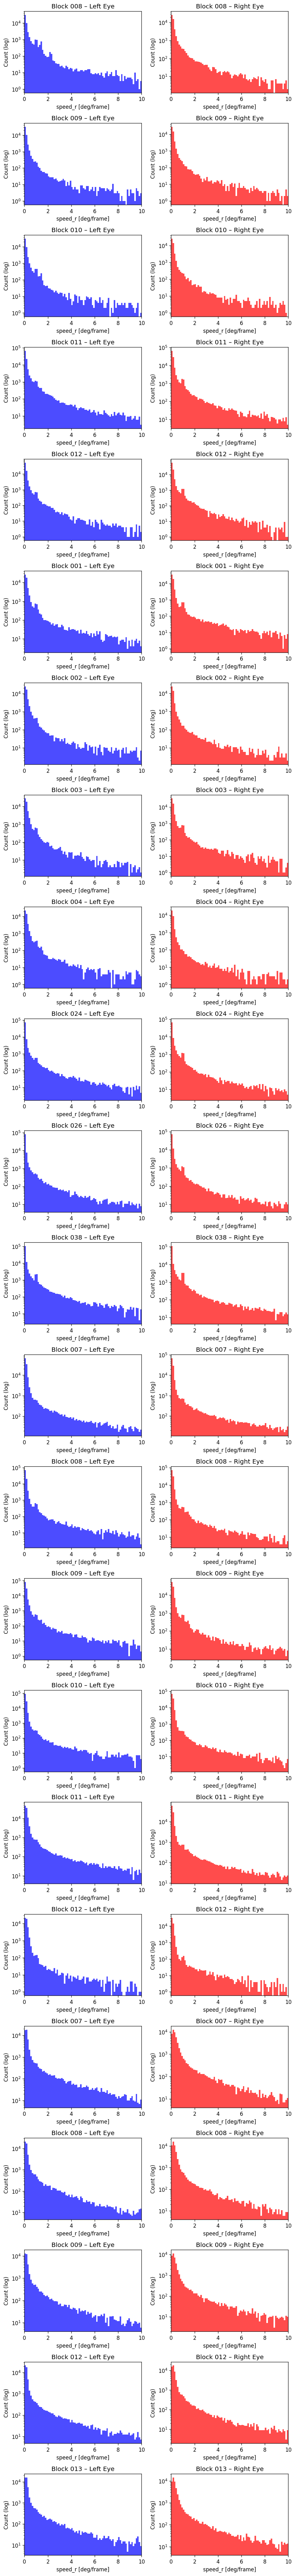

In [8]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

def sanity_check_speed_r_distributions(block_collection, bins=100, xlim=None):
    """
    Quick sanity check: plot histograms of speed_r for each block and each eye.

    Args:
        block_collection (list): List of BlockSync objects.
        bins (int): Number of bins for histograms (if xlim given, span is aligned to it).
        xlim (tuple): Optional (min,max) x-axis limits in deg/frame.
    """
    fig, axs = plt.subplots(len(block_collection), 2, figsize=(8, 3*len(block_collection)), dpi=120)
    if len(block_collection) == 1:
        axs = [axs]

    for i, block in enumerate(block_collection):
        # --- Left eye ---
        axL = axs[i][0]
        if hasattr(block, "left_eye_data") and "speed_r" in block.left_eye_data.columns:
            data = block.left_eye_data["speed_r"].dropna().to_numpy()
            if xlim:
                bins_edges = np.linspace(xlim[0], xlim[1], bins+1)
            else:
                bins_edges = bins
            axL.hist(data, bins=bins_edges, color="blue", alpha=0.7, log=True)
            axL.set_title(f"Block {block.block_num} – Left Eye")
        else:
            axL.set_title(f"Block {block.block_num} – Left Eye (no data)")
        if xlim: axL.set_xlim(xlim)
        axL.set_xlabel("speed_r [deg/frame]")
        axL.set_ylabel("Count (log)")

        # --- Right eye ---
        axR = axs[i][1]
        if hasattr(block, "right_eye_data") and "speed_r" in block.right_eye_data.columns:
            data = block.right_eye_data["speed_r"].dropna().to_numpy()
            if xlim:
                bins_edges = np.linspace(xlim[0], xlim[1], bins+1)
            else:
                bins_edges = bins
            axR.hist(data, bins=bins_edges, color="red", alpha=0.7, log=True)
            axR.set_title(f"Block {block.block_num} – Right Eye")
        else:
            axR.set_title(f"Block {block.block_num} – Right Eye (no data)")
        if xlim: axR.set_xlim(xlim)
        axR.set_xlabel("speed_r [deg/frame]")
        axR.set_ylabel("Count (log)")

    plt.tight_layout()
    plt.show()

sanity_check_speed_r_distributions(block_collection, bins=80, xlim=(0, 10))

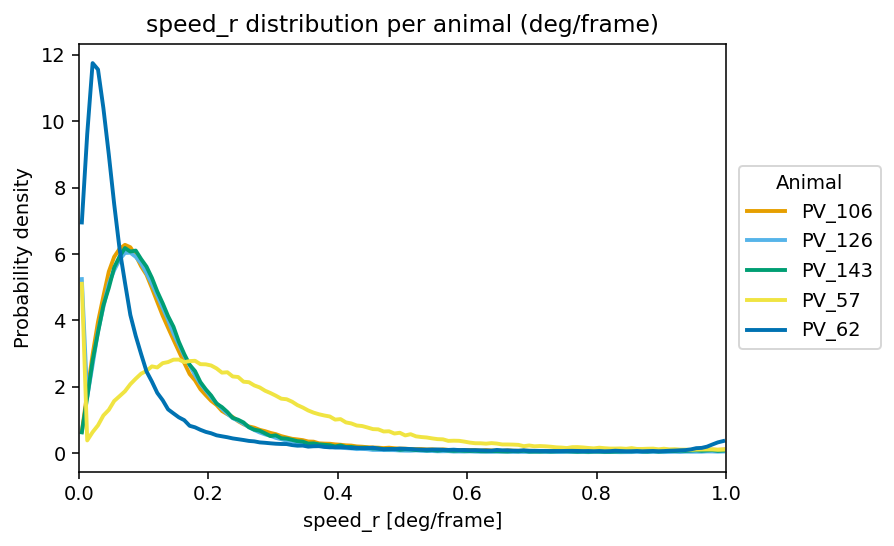

(<Figure size 910x560 with 1 Axes>,
 <Axes: title={'center': 'speed_r distribution per animal (deg/frame)'}, xlabel='speed_r [deg/frame]', ylabel='Probability density'>)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

_OKABE_ITO = [
    "#E69F00", "#56B4E9", "#009E73", "#F0E442",
    "#0072B2", "#D55E00", "#CC79A7", "#999999"
]

def plot_animal_speed_r_distributions(
    block_collection,
    bins=100,
    xlim=None,                       # (xmin, xmax); also sets the bin span if provided
    normalize='pmf',                 # 'pmf' (sum=1 over bins) or 'pdf' (area=1)
    combine_eyes=True,               # pool L+R per animal
    eye=None,                        # if combine_eyes=False, choose 'L' or 'R'
    color_map=None,                  # optional dict {'PV_62': '#...', ...}
    linewidth=2.0,
    title="speed_r distribution per animal (deg/frame)"
):
    """
    Aggregate speed_r across blocks (and eyes) per animal and plot per-animal probability curves.

    Args:
        block_collection: iterable of BlockSync objects; must have .animal_call, .left_eye_data/.right_eye_data with 'speed_r'.
        bins: number of bins (if xlim is given, span is aligned to it).
        xlim: optional (xmin, xmax) to set axis limits AND bin edges.
        normalize: 'pmf' (probabilities sum to 1) or 'pdf' (probability density).
        combine_eyes: if True, pool left and right eyes per animal.
        eye: if combine_eyes is False, choose which eye to plot: 'L' or 'R'.
        color_map: optional fixed colors per animal; else uses Okabe–Ito palette.
        linewidth: line width for traces.
        title: plot title.
    """
    # --- collect data per animal ---
    by_animal = {}
    for block in block_collection:
        animal = getattr(block, 'animal_call', None)
        if animal is None:
            continue
        # fetch data arrays safely
        L = None
        R = None
        if hasattr(block, "left_eye_data") and "speed_r" in block.left_eye_data.columns:
            L = block.left_eye_data["speed_r"].dropna().to_numpy()
        if hasattr(block, "right_eye_data") and "speed_r" in block.right_eye_data.columns:
            R = block.right_eye_data["speed_r"].dropna().to_numpy()

        if combine_eyes:
            arrs = [a for a in (L, R) if a is not None and a.size]
            if not arrs:
                continue
            data = np.concatenate(arrs)
        else:
            if eye not in ('L', 'R'):
                raise ValueError("When combine_eyes=False you must set eye to 'L' or 'R'.")
            src = L if eye == 'L' else R
            if src is None or src.size == 0:
                continue
            data = src

        if data.size:
            by_animal.setdefault(animal, []).append(data)

    # concatenate across blocks per animal
    for a in list(by_animal.keys()):
        by_animal[a] = np.concatenate(by_animal[a]) if len(by_animal[a]) else np.array([])

    # guard: nothing to plot
    if not by_animal or all(v.size == 0 for v in by_animal.values()):
        print("No speed_r data found to plot.")
        return

    # --- decide on bin edges ---
    if xlim is not None:
        xmin, xmax = xlim
        bin_edges = np.linspace(xmin, xmax, bins + 1)
    else:
        # robust global span from all animals (clip extremes a bit)
        all_vals = np.concatenate([v for v in by_animal.values() if v.size])
        low, high = np.nanpercentile(all_vals, [0.5, 99.5])
        if not np.isfinite(low) or not np.isfinite(high) or low >= high:
            low, high = float(np.nanmin(all_vals)), float(np.nanmax(all_vals))
        bin_edges = np.linspace(low, high, bins + 1)

    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # --- colors ---
    animals = sorted(by_animal.keys())
    if color_map is None:
        palette = (_OKABE_ITO * ((len(animals) // len(_OKABE_ITO)) + 1))[:len(animals)]
        colors = {a: c for a, c in zip(animals, palette)}
    else:
        colors = {a: color_map.get(a, _OKABE_ITO[i % len(_OKABE_ITO)]) for i, a in enumerate(animals)}

    # --- plot ---
    fig, ax = plt.subplots(figsize=(6.5, 4.0), dpi=140)

    for animal in animals:
        vals = by_animal[animal]
        if vals.size == 0:
            continue
        counts, _ = np.histogram(vals, bins=bin_edges, density=(normalize == 'pdf'))
        if normalize == 'pmf':
            total = counts.sum()
            y = counts / total if total > 0 else counts
        else:
            y = counts  # pdf

        # step plot looks nice for hist-based curves; or use regular line
        ax.plot(bin_centers, y, label=animal, color=colors[animal], lw=linewidth)

    ax.set_xlabel("speed_r [deg/frame]")
    ax.set_ylabel("Probability" if normalize == 'pmf' else "Probability density")
    ax.set_title(title)
    if xlim is not None:
        ax.set_xlim(xlim)

    # Legend placed to the right, outside the axes
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0, title="Animal")
    plt.tight_layout()
    plt.show()

    return fig, ax
plot_animal_speed_r_distributions(block_collection, bins=120, xlim=(0, 1), normalize='pdf', combine_eyes=False, eye="R")


In [11]:
import numpy as np
import pandas as pd

def filter_saccade_events(saccade_events_df, min_length=1, min_disp_threshold=0.1):
    """
    Filters saccade events based on the number of frames (length) and overall angular displacement.

    Parameters:
      - saccade_events_df: DataFrame produced by create_saccade_events_with_direction_segmentation_updated.
        It should include at least the following columns:
          'length', 'theta_init_pos', 'theta_end_pos', 'phi_init_pos', 'phi_end_pos',
          or alternatively 'delta_theta' and 'delta_phi'.
      - min_length: Minimum number of frames for a saccade event (default is 1).
      - min_disp_threshold: Minimum overall angular displacement (in degrees) required for an event.

    Returns:
      - filtered_df: A DataFrame containing only saccade events with length >= min_length
                     and overall displacement >= min_disp_threshold.
    """
    # Make a copy to avoid modifying the original dataframe.
    filtered_df = saccade_events_df.copy()

    # Ensure that we have the delta columns.
    if 'delta_theta' not in filtered_df.columns or 'delta_phi' not in filtered_df.columns:
        # Compute delta_theta and delta_phi from the initial and final positions.
        filtered_df['delta_theta'] = filtered_df['theta_end_pos'] - filtered_df['theta_init_pos']
        filtered_df['delta_phi'] = filtered_df['phi_end_pos'] - filtered_df['phi_init_pos']

    # Compute the overall angular displacement.
    filtered_df['overall_disp'] = np.sqrt(filtered_df['delta_theta']**2 + filtered_df['delta_phi']**2)

    # Filter out events with length below min_length and overall displacement below threshold.
    filtered_df = filtered_df[(filtered_df['length'] >= min_length) &
                              (filtered_df['overall_disp'] >= min_disp_threshold)]

    return filtered_df


for block in block_collection:
    print(f'{block} before = {len(block.l_saccade_df)+len(block.r_saccade_df)}')
    block.l_saccade_df = filter_saccade_events(block.l_saccade_df,min_length=2,min_disp_threshold=0.23)
    block.r_saccade_df = filter_saccade_events(block.r_saccade_df,min_length=2,min_disp_threshold=0.23)
    print(f'{block} after = {len(block.l_saccade_df)+len(block.r_saccade_df)}')

PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19 before = 1459
PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19 after = 865
PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43 before = 734
PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43 after = 486
PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43 before = 797
PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43 after = 476
PV_106, block 011, on PV106_ET_d3t4_2025-08-06_12-44-30 before = 2293
PV_106, block 011, on PV106_ET_d3t4_2025-08-06_12-44-30 after = 1490
PV_106, block 012, on PV106_ET_d3t5_2025-08-06_13-21-30 before = 1419
PV_106, block 012, on PV106_ET_d3t5_2025-08-06_13-21-30 after = 870
PV_143, block 001, on PV143_ET_d1t1_2025-08-11_13-29-08 before = 1143
PV_143, block 001, on PV143_ET_d1t1_2025-08-11_13-29-08 after = 766
PV_143, block 002, on PV143_ET_d1t2_2025-08-11_13-50-11 before = 700
PV_143, block 002, on PV143_ET_d1t2_2025-08-11_13-50-11 after = 422
PV_143, block 003, on PV143_ET_d1t3_20

In [12]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    # collect accelerometer data
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:]}

        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        mat_data.close()
        block.liz_mov_df = acc_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print('mat file does not exist - run the matlab getLizMovement function')

    return


# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms

        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]

        if overlapping_mov_times.size > 0:
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

# Create a list to store blocks where movement data exists
block_collection_w_mov = []

for block in block_collection:
    try:
        block_get_lizard_movement(block)  # Try loading movement data
        label_saccade_movements(block)    # Try labeling saccades

        # If both steps succeed, add block to the valid collection
        block_collection_w_mov.append(block)

    except (FileNotFoundError, OSError) as e:
        print(f"Skipping block {block}: {str(e)}")  # Notify which block failed


path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_008\oe_files\PV106_ET_d3t12025-08-06_11-52-19\Record Node 102\analysis\recNames=Block008,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_009\oe_files\PV106_ET_d3t2_2025-08-06_12-09-43\Record Node 102\analysis\recNames=Block009,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_010\oe_files\PV106_ET_d3t3_2025-08-06_12-26-43\Record Node 102\analysis\recNames=Block010,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_011\oe_files\PV106_ET_d3t4_2025-08-06_12-44-30\Record Node 102\analysis\recNames=Block011,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 011,

In [13]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])

In [14]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [15]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])

    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')

    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


529it [00:00, 8950.15it/s]

77 336



255it [00:00, 9972.56it/s]
289it [00:00, 6086.91it/s]
0it [00:00, ?it/s]

65 231
42 187


825it [00:00, 7276.92it/s]
454it [00:00, 7999.32it/s]
0it [00:00, ?it/s]

253 665
176 416


355it [00:00, 2965.57it/s]
203it [00:00, 11516.58it/s]
246it [00:00, 7070.89it/s]
158it [00:00, 7889.57it/s]

153 411
106 219
160 332
51 132



522it [00:00, 7811.37it/s]
490it [00:00, 6878.37it/s]
0it [00:00, ?it/s]

196 476
got them all
265 549


774it [00:00, 7766.65it/s]
878it [00:00, 7544.21it/s]


770 1176
got them all


306it [00:00, 6383.64it/s]
367it [00:00, 7860.44it/s]
0it [00:00, ?it/s]

310 836
209 382
162 358


191it [00:00, 10270.67it/s]
727it [00:00, 7914.27it/s]


133 257
415 895


85it [00:00, 7099.65it/s]
643it [00:00, 6469.71it/s]
0it [00:00, ?it/s]

46 96
609 978


671it [00:00, 6999.65it/s]
527it [00:00, 8178.21it/s]
0it [00:00, ?it/s]

301 718
301 564


568it [00:00, 7017.52it/s]
691it [00:00, 4454.61it/s]

194 543


359 836


In [16]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df

synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


In [17]:
all_saccade_collection = pd.concat([synced_saccade_collection,non_synced_saccade_collection])


In [26]:
# current effort - same axis ISI histogram for lin and log space:
# ==== Broken-X ISI histogram: linear (10–500 ms) + log (500–20000 ms), shared y ====
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import datetime as _dt
import pickle

# ----- Bin builders (snapped to realizable ISIs at (k+0.5)*Δt) -----
def _snapped_linear_bins(num_bins, frame_ms, low_ms, high_ms):
    raw = np.linspace(float(low_ms), float(high_ms), int(num_bins) + 1)
    k_edges = np.floor(raw / frame_ms) + 0.5
    kmax = int(np.floor(high_ms / frame_ms))
    k_edges = np.clip(k_edges, 0.5, kmax + 0.5)
    k_edges = np.unique(k_edges)
    if k_edges[-1] < (kmax + 0.5):
        k_edges = np.r_[k_edges, (kmax + 0.5)]
    return k_edges * frame_ms

def _snapped_log_bins(num_bins, frame_ms, low_ms, high_ms, log_exponent=1.0):
    # edges(t) = low * (high/low)^(t^log_exponent)
    t = np.linspace(0.0, 1.0, int(num_bins) + 1)
    ratio = float(high_ms) / float(low_ms)
    raw = float(low_ms) * (ratio ** (t ** float(log_exponent)))
    k_edges = np.floor(raw / frame_ms) + 0.5
    kmax = int(np.floor(high_ms / frame_ms))
    k_edges = np.clip(k_edges, 0.5, kmax + 0.5)
    k_edges = np.unique(k_edges)
    if k_edges[-1] < (kmax + 0.5):
        k_edges = np.r_[k_edges, (kmax + 0.5)]
    return k_edges * frame_ms

# ----- Main function -----
def export_inter_saccade_intervals_brokenX(
    block_collection,
    figure_size=(5.6, 2.2),
    export_path=None,
    plot_name='ISI_hist_brokenX.pdf',

    # domains
    low_lin=10.0,         # left panel start (ms)
    seam_ms=500.0,        # split; left uses [low_lin, seam_ms), right uses [seam_ms, high_log]
    high_log=20000.0,     # right panel end (ms)

    # binning
    num_bins_lin=20,
    num_bins_log=20,
    log_exponent=1.0,     # 1.0 = standard geometric spacing on the right

    # events & ISI processing
    pair_threshold_ms=60.0,
    min_isi_ms=None,      # if None -> 0.75 * frame_ms

    # styling
    font_family='Arial',
    color_template='okabeito',
    custom_colors=None,
    color_map=None,       # {'PV_62':'#...'}, overrides template per-animal
    avg_label="All (combined)",
    avg_color="k",
    avg_linewidth=2.0,
    avg_linestyle="-",
    ylim=None,            # shared y across both panels

    # pickle export
    export_pickle_path=None,
    pickle_name="ISI_hist_brokenX_plotdata.pkl"
):
    """
    Two axes (shared y):
      - LEFT  (linear):  [low_lin, seam_ms) bins
      - RIGHT (log):     [seam_ms, high_log] bins
    Data split at seam: ISIs < seam_ms go left; ISIs >= seam_ms go right.
    For each animal, left+right probabilities sum to 1 (no folding, no mass loss).
    Combined trace is computed from summed counts and normalized the same way.

    Requires your existing helpers:
      _collect_events_from_blocks, _dedupe_lr_pairs, _estimate_frame_interval_ms,
      _compute_blockwise_isis, build_color_map
    """
    # --- Gather & dedupe events ---
    events = _collect_events_from_blocks(block_collection)
    if events.empty:
        raise ValueError("No saccade events found.")
    dedup = _dedupe_lr_pairs(events, pair_threshold_ms=pair_threshold_ms)

    # --- ISIs per animal ---
    frame_ms = _estimate_frame_interval_ms(block_collection)
    min_isi_eff = (0.75 * frame_ms) if (min_isi_ms is None) else float(min_isi_ms)
    isi_all = _compute_blockwise_isis(dedup, min_isi_ms=min_isi_eff)
    animals = sorted(dedup['animal'].dropna().unique())

    # --- Colors ---
    if color_map is None:
        cmap = build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
    else:
        fallback = build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
        cmap = {a: color_map.get(a, fallback[a]) for a in animals}

    # --- Build bins (snapped) ---
    bins_lin = _snapped_linear_bins(num_bins_lin, frame_ms, low_lin, seam_ms)
    bins_log = _snapped_log_bins(num_bins_log, frame_ms, seam_ms, high_log, log_exponent=log_exponent)

    centers_lin = 0.5 * (bins_lin[:-1] + bins_lin[1:])
    centers_log = np.sqrt(bins_log[:-1] * bins_log[1:])

    # --- Figure: two axes, side-by-side, share y ---
    plt.rcParams['font.family'] = 'sans-serif'; plt.rcParams['font.sans-serif'] = [font_family]
    fig, (axL, axR) = plt.subplots(1, 2, figsize=figure_size, dpi=300, sharey=True)
    for ax in (axL, axR):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=8, length=5, width=1, direction='out')
    axL.set_xscale('linear')
    axR.set_xscale('log')
    axL.set_xlim(bins_lin[0], bins_lin[-1])
    axR.set_xlim(bins_log[0], bins_log[-1])
    if ylim is not None:
        axL.set_ylim(ylim[0], ylim[1])

    axL.set_xlabel('ISI [ms] (linear)', fontsize=10)
    axR.set_xlabel('ISI [ms] (log)', fontsize=10)
    axL.set_ylabel('Probability (per bin)', fontsize=10)

    legend_handles, legend_labels = [], []

    # --- Accumulators for combined trace ---
    total_counts_L = np.zeros(len(bins_lin) - 1, dtype=float)
    total_counts_R = np.zeros(len(bins_log) - 1, dtype=float)
    valid_any = False

    # --- Plot per-animal traces ---
    for a in animals:
        isi = np.asarray(isi_all.get(a, np.array([])), float)
        if isi.size == 0:
            continue

        # Split at seam to avoid double counting
        isi_L = isi[(isi >= bins_lin[0]) & (isi < seam_ms)]
        isi_R = isi[(isi >= seam_ms) & (isi <= bins_log[-1])]

        hL = np.histogram(isi_L, bins=bins_lin)[0]
        hR = np.histogram(isi_R, bins=bins_log)[0]
        tot = hL.sum() + hR.sum()
        if tot == 0:
            continue
        valid_any = True

        pL = hL / tot  # per-bin probability, left
        pR = hR / tot  # per-bin probability, right

        total_counts_L += hL
        total_counts_R += hR

        c = cmap[a]
        lnL, = axL.plot(centers_lin, pL, linewidth=1.2, color=c, label=str(a))
        lnR, = axR.plot(centers_log, pR, linewidth=1.2, color=c, label=str(a))
        legend_handles.append(lnL); legend_labels.append(str(a))

    # --- Combined (All) trace ---
    if valid_any and (total_counts_L.sum() + total_counts_R.sum()) > 0:
        tot_all = total_counts_L.sum() + total_counts_R.sum()
        pL_all = total_counts_L / tot_all
        pR_all = total_counts_R / tot_all

        lnL_all, = axL.plot(centers_lin, pL_all, avg_linestyle, color=avg_color,
                            linewidth=avg_linewidth, label=avg_label, zorder=10)
        lnR_all, = axR.plot(centers_log, pR_all, avg_linestyle, color=avg_color,
                            linewidth=avg_linewidth, label=avg_label, zorder=10)
        legend_handles.insert(0, lnL_all); legend_labels.insert(0, avg_label)

    # Optional subtitles
    axL.set_title(f'[{bins_lin[0]:.0f}, {seam_ms:.0f}) ms', fontsize=9)
    axR.set_title(f'[{seam_ms:.0f}, {bins_log[-1]:.0f}] ms', fontsize=9)

    # Legend (single, compact)
    if legend_handles:
        fig_leg = plt.figure(figsize=(2.2, 0.30*max(1,len(legend_labels))+0.4), dpi=300)
        fig_leg.legend(legend_handles, legend_labels, loc='center', frameon=False, ncol=1, prop={'size':8})
        if export_path is not None:
            outdir_tmp = Path(export_path)
            outdir_tmp.mkdir(parents=True, exist_ok=True)
            fig_leg.savefig(outdir_tmp/('legend_'+plot_name), format='pdf', bbox_inches='tight', dpi=300)
        plt.close(fig_leg)

    plt.tight_layout()

    # --- Pack return + optional exports ---
    plot_data = {
        "params": {
            "low_lin": low_lin, "seam_ms": seam_ms, "high_log": high_log,
            "num_bins_lin": num_bins_lin, "num_bins_log": num_bins_log, "log_exponent": log_exponent,
            "pair_threshold_ms": pair_threshold_ms, "min_isi_ms": min_isi_ms,
            "font_family": font_family, "color_template": color_template
        },
        "frame_ms": frame_ms,
        "bins_linear": bins_lin,
        "bins_log": bins_log,
        "centers_linear": centers_lin,
        "centers_log": centers_log,
        "animals": animals,
        "color_map": cmap,
        "combined": {
            "counts_left": total_counts_L,
            "counts_right": total_counts_R,
            "p_left": pL_all if valid_any else None,
            "p_right": pR_all if valid_any else None,
            "label": avg_label
        }
    }

    outdir = None
    if export_path is not None:
        ts = _dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        outdir = Path(export_path) / f"inter_saccade_brokenX_export_{ts}"
        outdir.mkdir(parents=True, exist_ok=True)
        fig.savefig(outdir/plot_name, format='pdf', bbox_inches='tight', dpi=300)

    if export_pickle_path is not None:
        export_pickle_path = Path(export_pickle_path)
        export_pickle_path.parent.mkdir(parents=True, exist_ok=True)
        with open(export_pickle_path, "wb") as f:
            pickle.dump(plot_data, f)
        print(f"Plot data (.pickle) saved to: {export_pickle_path}")
    elif outdir is not None:
        pkl_path = outdir / pickle_name
        with open(pkl_path, "wb") as f:
            pickle.dump(plot_data, f)
        print(f"Plot data (.pickle) saved to: {pkl_path}")

    if outdir is not None:
        print("Exported plot to:", outdir)

    plt.show()
    return plot_data


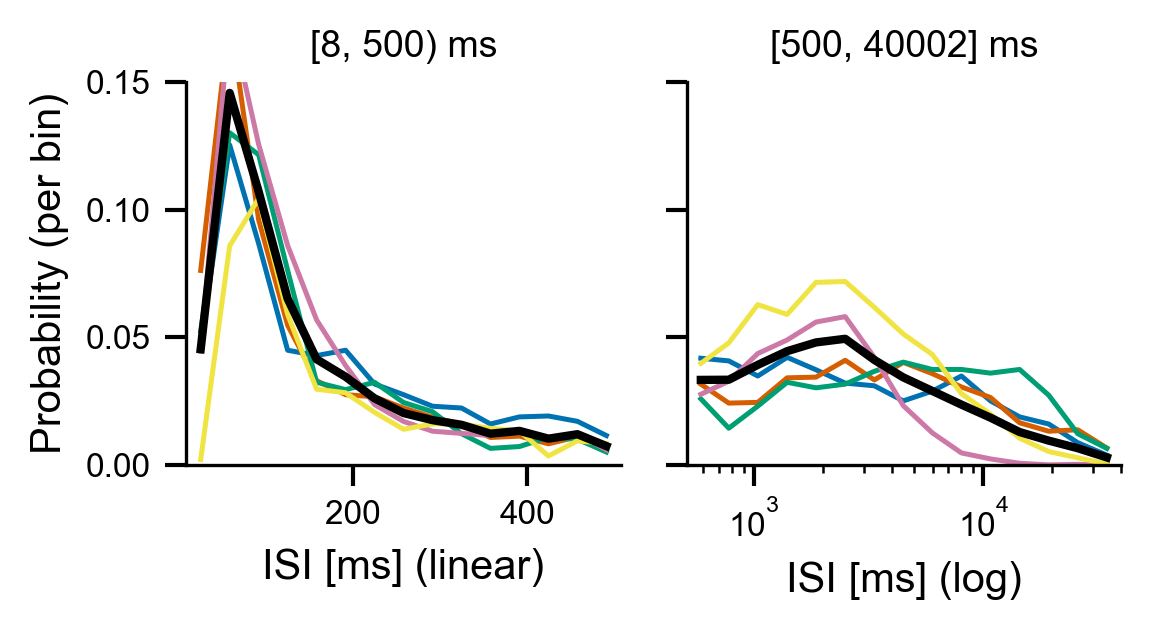

{'params': {'low_lin': 10,
  'seam_ms': 500,
  'high_log': 40000,
  'num_bins_lin': 15,
  'num_bins_log': 15,
  'log_exponent': 1.0,
  'pair_threshold_ms': 60.0,
  'min_isi_ms': None,
  'font_family': 'Arial',
  'color_template': 'okabeito'},
 'frame_ms': 16.650000000023283,
 'bins_linear': array([  8.325,  41.625,  74.925, 108.225, 141.525, 174.825, 208.125,
        241.425, 274.725, 308.025, 341.325, 374.625, 407.925, 441.225,
        474.525, 507.825]),
 'bins_log': array([  507.825     ,   674.325     ,   890.775     ,  1207.125     ,
         1606.725     ,  2156.175     ,  2888.775     ,  3871.12500001,
         5169.82500001,  6934.72500001,  9282.37500001, 12429.22500002,
        16658.32500002, 22302.67500003, 29861.77500004, 40001.62500006]),
 'centers_linear': array([ 24.975,  58.275,  91.575, 124.875, 158.175, 191.475, 224.775,
        258.075, 291.375, 324.675, 357.975, 391.275, 424.575, 457.875,
        491.175]),
 'centers_log': array([  585.18295697,   775.03022643,  10

In [28]:
export_inter_saccade_intervals_brokenX(
    block_collection,
    figure_size=(4,2.2),
    # export_path="/path/to/save",  # optional
    num_bins_lin=15,
    num_bins_log=15,
    low_lin=10, seam_ms=500, high_log=40000,
    log_exponent=1.0,           # try 1.5 to increase resolution near 500–1,000 ms on the right
    color_map=color_map,        # or omit to auto-generate
    ylim=(0, 0.15)              # optional shared y limit
)


In [38]:
### STATE DEPENDENT VERSION ISI ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import datetime as _dt
import pickle

def export_inter_saccade_intervals_brokenX_by_state(
    block_collection,
    figure_size=(5.6, 2.2),
    export_path=None,
    plot_name_base='ISI_hist_brokenX_state',

    # domains
    low_lin=10.0,
    seam_ms=500.0,
    high_log=20000.0,

    # binning
    num_bins_lin=20,
    num_bins_log=20,
    log_exponent=1.0,

    # events & ISI processing
    pair_threshold_ms=60.0,
    min_isi_ms=None,      # if None -> 0.75 * frame_ms

    # styling
    font_family='Arial',
    color_template='okabeito',
    custom_colors=None,
    color_map=None,
    ylim=None,

    # pickle export
    export_pickle_path=None,
    pickle_name_base="ISI_hist_brokenX_state_plotdata.pkl",
):
    """
    Build two broken-X ISI plots:
      - one for saccades during QUIET epochs
      - one for saccades during ACTIVE epochs

    ISIs are computed separately per state:
      - For each block/animal, restrict saccades to a given state based on
        behavior_state intervals and eye time range.
      - _compute_blockwise_isis() runs on those state-restricted events.
      - ISIs do NOT bridge across state boundaries.

    Uses block.behavior_state with:
      - either (start_time_ms, end_time_ms, annotation)
      - or     (start_time,     end_time,     annotation)
    """

    # ---------- helpers ----------
    def _animal_id(block):
        return getattr(block, "animal_call", None) or getattr(block, "animal", None) or "UNK"

    def _eye_time_range_ms(block, time_col="ms_axis"):
        # try left/right clean then raw
        for df in [
            getattr(block, "left_eye_data_clean", None),
            getattr(block, "right_eye_data_clean", None),
            getattr(block, "left_eye_data", None),
            getattr(block, "right_eye_data", None),
        ]:
            if isinstance(df, pd.DataFrame) and df is not None and time_col in df.columns:
                t = df[time_col].to_numpy().astype(float)
                t = t[np.isfinite(t)]
                if t.size:
                    return float(np.nanmin(t)), float(np.nanmax(t))
        return None, None

    def _state_intervals_ms_from_block(block):
        bs = getattr(block, "behavior_state", None)
        if bs is None or not isinstance(bs, pd.DataFrame) or bs.empty:
            return None

        df = bs.copy()
        if "annotation" not in df.columns:
            return None
        df["annotation"] = df["annotation"].astype(str).str.strip().str.lower()

        # Use *_ms if present, else assume start_time/end_time are already ms
        if {"start_time_ms", "end_time_ms"}.issubset(df.columns):
            st = pd.to_numeric(df["start_time_ms"], errors="coerce")
            en = pd.to_numeric(df["end_time_ms"], errors="coerce")
        elif {"start_time", "end_time"}.issubset(df.columns):
            st = pd.to_numeric(df["start_time"], errors="coerce")
            en = pd.to_numeric(df["end_time"], errors="coerce")
        else:
            return None

        out = pd.DataFrame({"start_ms": st, "end_ms": en, "annotation": df["annotation"]})
        out = out.replace([np.inf, -np.inf], np.nan).dropna(subset=["start_ms", "end_ms", "annotation"])
        out = out[out["annotation"].isin(["active", "quiet"])]
        if out.empty:
            return None
        return out

    def _find_time_col(df):
        # include your real time field name: 'saccade_on_ms'
        for c in ["saccade_on_ms", "saccade_off_ms", "t_ms", "time_ms", "timestamp_ms", "t", "time"]:
            if c in df.columns:
                return c
        raise ValueError(
            f"Could not find a time column in events; "
            f"tried saccade_on_ms/saccade_off_ms/t_ms/time_ms/timestamp_ms/t/time. "
            f"Found: {df.columns}"
        )

    def _label_events_with_state_by_time(events, time_col, block_collection):
        """
        Robust state labeling:
        - For each block:
            * get eye time range [t_min, t_max]
            * get that block's behavior_state intervals
            * find events with matching animal AND time within [t_min, t_max]
            * label those events as quiet/active based on intervals
        - All others remain 'unknown'.
        """
        state = np.full(len(events), "unknown", dtype=object)
        t = events[time_col].to_numpy().astype(float)
        animals_ev = events["animal"].astype(str).to_numpy()

        for block in block_collection:
            animal = _animal_id(block)
            tmin, tmax = _eye_time_range_ms(block, time_col="ms_axis")
            if tmin is None or tmax is None:
                continue

            intervals = _state_intervals_ms_from_block(block)
            if intervals is None or intervals.empty:
                continue

            # events that likely belong to this block: same animal + time in eye range
            mask_block = (animals_ev == str(animal)) & (t >= tmin) & (t <= tmax)
            idx_block = np.where(mask_block)[0]
            if idx_block.size == 0:
                continue

            t_block = t[idx_block]
            labels_block = np.full(t_block.shape, "unknown", dtype=object)

            for _, row in intervals.iterrows():
                s = float(row["start_ms"]); e = float(row["end_ms"])
                if not np.isfinite(s) or not np.isfinite(e) or e <= s:
                    continue
                annot = row["annotation"]
                mask_int = (t_block >= s) & (t_block < e)
                labels_block[mask_int] = annot

            state[idx_block] = labels_block

        events = events.copy()
        events["state"] = state
        return events

    def _plot_brokenX_from_isi_dict(
        isi_all,
        animals,
        frame_ms,
        bins_lin,
        bins_log,
        centers_lin,
        centers_log,
        cmap,
        avg_label="All (combined)",
        avg_color="k",
        avg_linewidth=2.0,
        avg_linestyle="-",
        ylim=None,
        font_family='Arial',
        title_suffix="",
        figure_size=(5.6, 2.2),
        export_path=None,
        filename="ISI_hist_brokenX.pdf",
    ):
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = [font_family]

        fig, (axL, axR) = plt.subplots(1, 2, figsize=figure_size, dpi=300, sharey=True)
        for ax in (axL, axR):
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.tick_params(axis='both', which='major', labelsize=8, length=5, width=1, direction='out')

        axL.set_xscale('linear')
        axR.set_xscale('log')
        axL.set_xlim(bins_lin[0], bins_lin[-1])
        axR.set_xlim(bins_log[0], bins_log[-1])
        if ylim is not None:
            axL.set_ylim(ylim[0], ylim[1])

        axL.set_xlabel('ISI [ms] (linear)', fontsize=10)
        axR.set_xlabel('ISI [ms] (log)', fontsize=10)
        axL.set_ylabel('Probability (per bin)', fontsize=10)

        legend_handles, legend_labels = [], []
        total_counts_L = np.zeros(len(bins_lin) - 1, dtype=float)
        total_counts_R = np.zeros(len(bins_log) - 1, dtype=float)
        valid_any = False

        for a in animals:
            isi = np.asarray(isi_all.get(a, np.array([])), float)
            if isi.size == 0:
                continue

            isi_L = isi[(isi >= bins_lin[0]) & (isi < seam_ms)]
            isi_R = isi[(isi >= seam_ms) & (isi <= bins_log[-1])]

            hL = np.histogram(isi_L, bins=bins_lin)[0]
            hR = np.histogram(isi_R, bins=bins_log)[0]
            tot = hL.sum() + hR.sum()
            if tot == 0:
                continue
            valid_any = True

            pL = hL / tot
            pR = hR / tot

            total_counts_L += hL
            total_counts_R += hR

            c = cmap[a]
            lnL, = axL.plot(centers_lin, pL, linewidth=1.2, color=c, label=str(a))
            lnR, = axR.plot(centers_log, pR, linewidth=1.2, color=c, label=str(a))
            legend_handles.append(lnL); legend_labels.append(str(a))

        if valid_any and (total_counts_L.sum() + total_counts_R.sum()) > 0:
            tot_all = total_counts_L.sum() + total_counts_R.sum()
            pL_all = total_counts_L / tot_all
            pR_all = total_counts_R / tot_all

            lnL_all, = axL.plot(centers_lin, pL_all, avg_linestyle, color=avg_color,
                                linewidth=avg_linewidth, label=avg_label, zorder=10)
            lnR_all, = axR.plot(centers_log, pR_all, avg_linestyle, color=avg_color,
                                linewidth=avg_linewidth, label=avg_label, zorder=10)
            legend_handles.insert(0, lnL_all); legend_labels.insert(0, avg_label)

        axL.set_title(f'[{bins_lin[0]:.0f}, {seam_ms:.0f}) ms {title_suffix}', fontsize=9)
        axR.set_title(f'[{seam_ms:.0f}, {bins_log[-1]:.0f}] ms {title_suffix}', fontsize=9)

        if legend_handles:
            fig_leg = plt.figure(figsize=(2.2, 0.30*max(1,len(legend_labels))+0.4), dpi=300)
            fig_leg.legend(legend_handles, legend_labels,
                           loc='center', frameon=False, ncol=1, prop={'size':8})
            if export_path is not None:
                outdir_tmp = Path(export_path)
                outdir_tmp.mkdir(parents=True, exist_ok=True)
                leg_name = filename.replace(".pdf", "_legend.pdf")
                fig_leg.savefig(outdir_tmp / leg_name, format='pdf',
                                bbox_inches='tight', dpi=300)
            plt.close(fig_leg)

        plt.tight_layout()

        if export_path is not None:
            outdir_tmp = Path(export_path)
            outdir_tmp.mkdir(parents=True, exist_ok=True)
            fig.savefig(outdir_tmp / filename, format='pdf', bbox_inches='tight', dpi=300)

        plt.show()
        return {
            "bins_linear": bins_lin,
            "bins_log": bins_log,
            "centers_linear": centers_lin,
            "centers_log": centers_log,
            "total_counts_left": total_counts_L,
            "total_counts_right": total_counts_R,
        }

    # ---------- main pipeline ----------

    # 1) Collect events
    events = _collect_events_from_blocks(block_collection)
    if events.empty:
        raise ValueError("No saccade events found.")

    time_col = _find_time_col(events)     # should pick 'saccade_on_ms'

    # 2) Label events with state (quiet/active/unknown) using eye time ranges
    events = _label_events_with_state_by_time(events, time_col, block_collection)

    # 3) Split events by state
    events_quiet  = events[events["state"] == "quiet"].copy()
    events_active = events[events["state"] == "active"].copy()

    # 4) Common sampling + bins
    frame_ms = _estimate_frame_interval_ms(block_collection)
    min_isi_eff = (0.75 * frame_ms) if (min_isi_ms is None) else float(min_isi_ms)

    bins_lin = _snapped_linear_bins(num_bins_lin, frame_ms, low_lin, seam_ms)
    bins_log = _snapped_log_bins(num_bins_log, frame_ms, seam_ms, high_log,
                                 log_exponent=log_exponent)
    centers_lin = 0.5 * (bins_lin[:-1] + bins_lin[1:])
    centers_log = np.sqrt(bins_log[:-1] * bins_log[1:])

    # 5) Colors
    animals_all = sorted(events["animal"].dropna().unique())
    if color_map is None:
        cmap = build_color_map(animals_all, template=color_template,
                               custom=custom_colors, order=animals_all)
    else:
        fallback = build_color_map(animals_all, template=color_template,
                                   custom=custom_colors, order=animals_all)
        cmap = {a: color_map.get(a, fallback[a]) for a in animals_all}

    # helper: events subset → ISI dict per animal
    def _isi_from_events_subset(ev_subset):
        if ev_subset.empty:
            return {}, []
        dedup = _dedupe_lr_pairs(ev_subset, pair_threshold_ms=pair_threshold_ms)
        if dedup.empty:
            return {}, []
        isi_dict = _compute_blockwise_isis(dedup, min_isi_ms=min_isi_eff)
        animals = sorted(dedup['animal'].dropna().unique())
        return isi_dict, animals

    # 6) Quiet
    isi_quiet, animals_quiet = _isi_from_events_subset(events_quiet)
    quiet_plot_data = None
    if len(animals_quiet):
        quiet_plot_data = _plot_brokenX_from_isi_dict(
            isi_quiet,
            animals_quiet,
            frame_ms,
            bins_lin,
            bins_log,
            centers_lin,
            centers_log,
            cmap,
            avg_label="All quiet",
            avg_color="k",
            avg_linewidth=2.0,
            avg_linestyle="-",
            ylim=ylim,
            font_family=font_family,
            title_suffix="(quiet)",
            figure_size=figure_size,
            export_path=export_path,
            filename=plot_name_base + "_quiet.pdf",
        )
    else:
        print("[info] No ISIs in quiet epochs; quiet plot skipped.")

    # 7) Active
    isi_active, animals_active = _isi_from_events_subset(events_active)
    active_plot_data = None
    if len(animals_active):
        active_plot_data = _plot_brokenX_from_isi_dict(
            isi_active,
            animals_active,
            frame_ms,
            bins_lin,
            bins_log,
            centers_lin,
            centers_log,
            cmap,
            avg_label="All active",
            avg_color="k",
            avg_linewidth=2.0,
            avg_linestyle="-",
            ylim=ylim,
            font_family=font_family,
            title_suffix="(active)",
            figure_size=figure_size,
            export_path=export_path,
            filename=plot_name_base + "_active.pdf",
        )
    else:
        print("[info] No ISIs in active epochs; active plot skipped.")

    # 8) Optional pickle export for reproducibility
    plot_data = {
        "params": {
            "low_lin": low_lin,
            "seam_ms": seam_ms,
            "high_log": high_log,
            "num_bins_lin": num_bins_lin,
            "num_bins_log": num_bins_log,
            "log_exponent": log_exponent,
            "pair_threshold_ms": pair_threshold_ms,
            "min_isi_ms": min_isi_ms,
            "font_family": font_family,
            "color_template": color_template,
        },
        "frame_ms": frame_ms,
        "bins_linear": bins_lin,
        "bins_log": bins_log,
        "centers_linear": centers_lin,
        "centers_log": centers_log,
        "color_map": cmap,
        "quiet": {
            "isi_dict": isi_quiet,
            "animals": animals_quiet,
            "plot_data": quiet_plot_data,
        },
        "active": {
            "isi_dict": isi_active,
            "animals": animals_active,
            "plot_data": active_plot_data,
        },
    }

    if export_pickle_path is not None:
        export_pickle_path = Path(export_pickle_path)
        export_pickle_path.parent.mkdir(parents=True, exist_ok=True)
        with open(export_pickle_path, "wb") as f:
            pickle.dump(plot_data, f)
        print(f"State-split ISI plot data (.pickle) saved to: {export_pickle_path}")
    elif export_path is not None:
        ts = _dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        outdir = Path(export_path) / f"inter_saccade_brokenX_state_export_{ts}"
        outdir.mkdir(parents=True, exist_ok=True)
        pkl_path = outdir / pickle_name_base
        with open(pkl_path, "wb") as f:
            pickle.dump(plot_data, f)
        print(f"State-split ISI plot data (.pickle) saved to: {pkl_path}")

    return plot_data



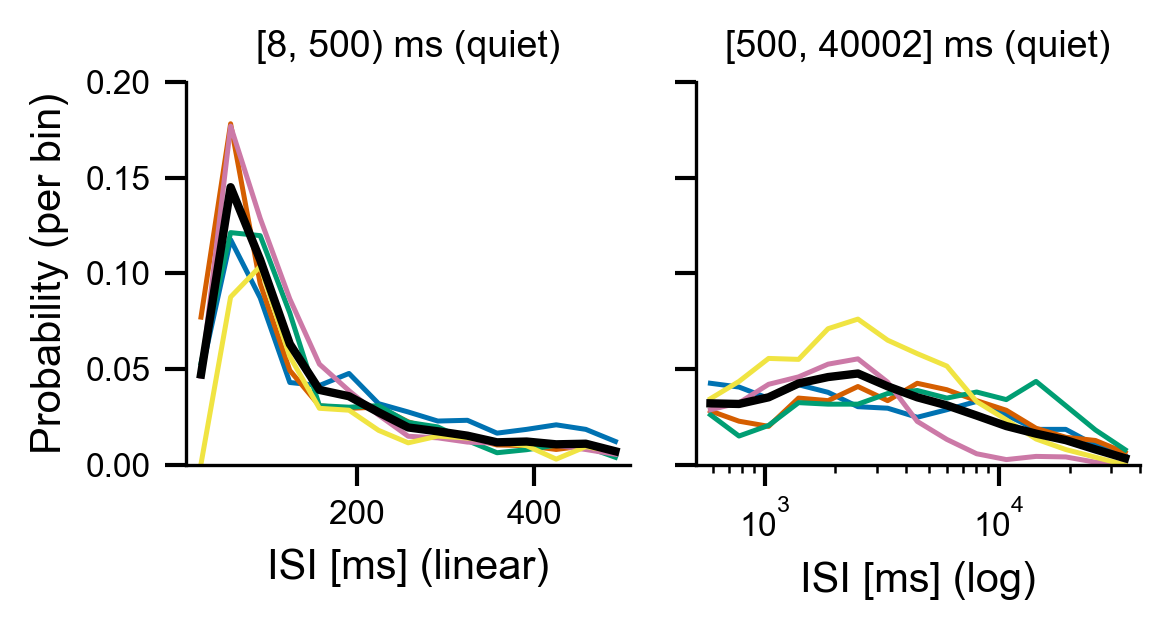

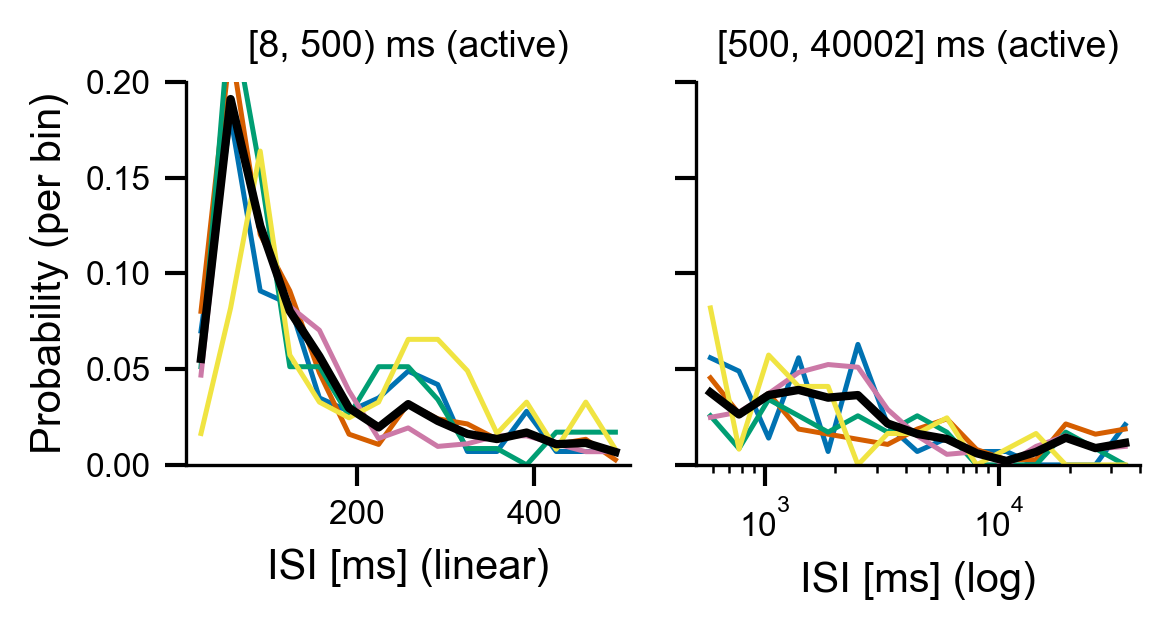

State-split ISI plot data (.pickle) saved to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\ISI_State_broken_scale\inter_saccade_brokenX_state_export_2025_12_01_10_20_10\ISI_hist_brokenX_state_plotdata.pkl


In [45]:
state_plot_data = export_inter_saccade_intervals_brokenX_by_state(
    block_collection,
    figure_size=(4, 2.2),
    export_path=r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\ISI_State_broken_scale',  # optional
    low_lin=10,
    seam_ms=500,
    high_log=40000,
    num_bins_lin=15,
    num_bins_log=15,
    log_exponent=1.0,
    color_map=color_map,   # or omit to auto-generate
    ylim=(0, 0.2),
    export_pickle_path=None,   # or path to a single pickle with both states
)


In [112]:
import pickle

def _snapped_log_bins(num_bins,
                      frame_ms,
                      low_ms,
                      high_ms,
                      add_leading_zero_bin=True,
                      log_exponent=1.0):
    """
    Build log-like bin edges between low_ms and high_ms, then snap edges to (k+0.5)*Δt
    so each bin contains ≥1 realizable ISI (k*Δt).

    Interpolation model (continuous before snapping):
        t ∈ [0, 1]
        edges(t) = low_ms * (high_ms/low_ms) ** (t ** log_exponent)

    Parameters
    ----------
    num_bins : int
        Target number of geometric intervals before snapping (actual output count
        may differ after snapping/dedup).
    frame_ms : float
        Video frame interval (Δt) in ms.
    low_ms, high_ms : float
        Inclusive bounds for the geometric edges (must satisfy 0 < low_ms < high_ms).
    add_leading_zero_bin : bool
        If True, prepend a dummy 0-count edge at 0.25*Δt (for display continuity).
    log_exponent : float
        =1.0 reproduces standard geometric spacing.
        >1.0 flattens near low_ms; <1.0 steepens near low_ms.

    Returns
    -------
    np.ndarray
        Snapped bin edges in milliseconds.
    """
    import numpy as np

    # --- Guards ---
    num_bins = int(num_bins)
    if num_bins < 1:
        raise ValueError("num_bins must be >= 1")
    if not (np.isfinite(low_ms) and np.isfinite(high_ms)) or not (0 < low_ms < high_ms):
        raise ValueError("low_ms and high_ms must be finite and satisfy 0 < low_ms < high_ms")
    if not np.isfinite(frame_ms) or frame_ms <= 0:
        raise ValueError("frame_ms must be a positive finite number")
    if not np.isfinite(log_exponent) or log_exponent <= 0:
        raise ValueError("log_exponent must be a positive finite number")

    # --- 1) Curved geometric edges before snapping (exact and base-invariant) ---
    t = np.linspace(0.0, 1.0, num_bins + 1)
    ratio = float(high_ms) / float(low_ms)
    raw = float(low_ms) * (ratio ** (t ** float(log_exponent)))  # == geomspace when log_exponent=1

    # --- 2) Snap to realizable ISIs: edges at (k + 0.5) * Δt ---
    k_edges = np.floor(raw / frame_ms) + 0.5
    kmax = int(np.floor(high_ms / frame_ms))
    k_edges = np.clip(k_edges, 0.5, kmax + 0.5)

    # --- 3) Deduplicate after snapping (snapping can merge neighbors) ---
    k_edges = np.unique(k_edges)

    # --- 4) Optional dummy leading edge (zero-count visual bin) ---
    if add_leading_zero_bin and (k_edges.size == 0 or not np.isclose(k_edges[0], 0.5)):
        k_edges = np.r_[0.25, k_edges]

    # --- 5) Ensure we include the max boundary ---
    if k_edges[-1] < (kmax + 0.5):
        k_edges = np.r_[k_edges, (kmax + 0.5)]

    return k_edges * frame_ms


# Helper: fold probability outside xlim into edge bins
def _fold_counts_to_xlim_truthful(counts, edges, xlim_tuple, renormalize=False):
    """
    Fold ALL probability mass outside [low, high] into the first/last displayed bins.

    counts : np.ndarray
        Per-bin probabilities over 'edges' (sum should be 1).
    edges : np.ndarray
        Bin edges (len = len(counts)+1), monotonically increasing.
    xlim_tuple : (low, high)
        Display range in data units.
    renormalize : bool
        If True, rescale displayed bins to sum to 1 after folding. Default False:
        keep total probability mass == 1 mapped into the displayed bins.

    Returns
    -------
    disp_counts, disp_edges, disp_centers, idx_lo, idx_hi
    """
    import numpy as np

    low, high = float(xlim_tuple[0]), float(xlim_tuple[1])

    if not (np.isfinite(low) and np.isfinite(high) and low < high):
        centers = np.sqrt(edges[:-1]*edges[1:])
        return counts, edges, centers, 0, len(counts)-1

    # Identify the bins that contain low and high
    # idx_lo/idx_hi are the indices of the bins that will become the first/last displayed bins
    idx_lo = np.searchsorted(edges, low, side='right') - 1
    idx_hi = np.searchsorted(edges, high, side='left')  - 1
    idx_lo = max(0, min(idx_lo, len(counts)-1))
    idx_hi = max(0, min(idx_hi, len(counts)-1))

    counts_fold = counts.copy()

    # ---- LEFT side: move all mass strictly left of idx_lo into idx_lo
    if idx_lo > 0:
        left_mass = counts_fold[:idx_lo].sum()
        counts_fold[:idx_lo] = 0.0
        counts_fold[idx_lo] += left_mass
    # Note: the bin idx_lo itself may be *partially* left of 'low', but we include its
    # entire mass in the first displayed bin by definition (truthful compression).

    # ---- RIGHT side: move all mass strictly right of idx_hi into idx_hi
    if idx_hi < len(counts_fold) - 1:
        right_mass = counts_fold[idx_hi+1:].sum()
        counts_fold[idx_hi+1:] = 0.0
        counts_fold[idx_hi] += right_mass
    # Similarly, idx_hi itself may be partially right of 'high'; we keep its full mass.

    # Slice the displayed portion
    disp_counts = counts_fold[idx_lo:idx_hi+1]
    disp_edges  = edges[idx_lo:idx_hi+2]
    disp_centers = np.sqrt(disp_edges[:-1]*disp_edges[1:])

    if renormalize:
        s = disp_counts.sum()
        if s > 0:
            disp_counts = disp_counts / s

    return disp_counts, disp_edges, disp_centers, idx_lo, idx_hi



def export_inter_saccade_intervals_density_traces_from_blocks(
    block_collection,
    figure_size=(1.8, 1.2),
    export_path=None,
    plot_name='ISI_histogram.pdf',
    num_bins=20,
    high_ms=20000.0,
    pair_threshold_ms=60.0,
    log_exponent=1.0,
    min_isi_ms=None,          # if None -> 0.75 * frame_ms
    first_bin_factor=0.5,     # first real edge = 0.5×Δt
    add_leading_zero_bin=True,
    font_family='Arial',
    color_template="okabeito",
    custom_colors=None,
    color_map=None,           # {'PV_62':'#...', ...}
    xlim=None,
    ylim=None,
    avg_label="All (combined)",
    avg_color="k",
    avg_linewidth=2.0,
    avg_linestyle="-",
    export_pickle_path=None,  # if None and export_path is set, will save next to the PDF
    pickle_name="ISI_histogram_plotdata.pkl"
):
    # Collect & dedupe
    events = _collect_events_from_blocks(block_collection)
    if events.empty:
        raise ValueError("No saccade events found.")
    dedup = _dedupe_lr_pairs(events, pair_threshold_ms=pair_threshold_ms)

    # Frame interval & ISIs
    frame_ms = _estimate_frame_interval_ms(block_collection)
    min_isi_eff = (0.75*frame_ms) if (min_isi_ms is None) else float(min_isi_ms)
    isi_all = _compute_blockwise_isis(dedup, min_isi_ms=min_isi_eff)
    animals = sorted(dedup['animal'].dropna().unique())

    # Colors
    if color_map is None:
        cmap = build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
    else:
        fallback = build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
        cmap = {a: color_map.get(a, fallback[a]) for a in animals}

    # Global binning
    low_ms = max(1e-6, first_bin_factor*frame_ms)
    bins = _snapped_log_bins(num_bins, frame_ms, low_ms, float(high_ms), add_leading_zero_bin, log_exponent=log_exponent)
    bin_centers = np.sqrt(bins[:-1]*bins[1:])

    # Style & axes
    plt.rcParams['font.family'] = 'sans-serif'; plt.rcParams['font.sans-serif'] = [font_family]
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)
    legend_handles, legend_labels = [], []



    # --- Per-animal plotting + accumulate total counts ---
    total_counts = np.zeros(len(bins)-1, dtype=float)
    valid_any = False

    # For pickle: store plot-ready x/y and also raw hist/density per animal
    plot_data = {
        "params": {
            "figure_size": figure_size, "num_bins": num_bins, "high_ms": high_ms,
            "pair_threshold_ms": pair_threshold_ms, "min_isi_ms": min_isi_ms,
            "first_bin_factor": first_bin_factor, "add_leading_zero_bin": add_leading_zero_bin,
            "xlim": xlim, "font_family": font_family, "color_template": color_template
        },
        "frame_ms": frame_ms,
        "bins": bins,
        "animals": animals,
        "color_map": cmap,
        "per_animal": {},   # {animal: {"hist":..., "density":..., "x":..., "y":...}}
        "combined": {}      # {"total_counts":..., "total_density":..., "x":..., "y":...}
    }

    for a in animals:
        isi = isi_all.get(a, np.array([]))
        if isi.size == 0:
            continue

        hist, _ = np.histogram(isi, bins=bins)
        if hist.sum() == 0:
            continue
        valid_any = True
        total_counts += hist

        dens = hist.astype(float) / hist.sum()

        if xlim is not None:
            disp_dens, disp_edges, disp_centers, idx_lo, idx_hi = _fold_counts_to_xlim_truthful(
            dens, bins, xlim, renormalize=False)
            x_plot, y_plot = disp_centers, disp_dens
        else:
            if add_leading_zero_bin:
                x_plot = np.r_[bins[0], bin_centers[1:]]
                y_plot = np.r_[0.0, dens[1:]]
            else:
                x_plot, y_plot = bin_centers, dens

        # Save per-animal plot data
        plot_data["per_animal"][a] = {
            "hist": hist,
            "density": dens,
            "x": x_plot,
            "y": y_plot
        }

        h, = ax.plot(x_plot, y_plot, linewidth=1.5, color=cmap[a], label=str(a))
        legend_handles.append(h); legend_labels.append(str(a))

    # --- Combined "All (combined)" average trace ---
    if valid_any and total_counts.sum() > 0:
        total_dens = total_counts / total_counts.sum()

        if xlim is not None:
            disp_dens_all, disp_edges_all, disp_centers_all, _, _ = _fold_counts_to_xlim_truthful(
            total_dens, bins, xlim, renormalize=False
            )
            x_all, y_all = disp_centers_all, disp_dens_all
        else:
            if add_leading_zero_bin:
                x_all = np.r_[bins[0], bin_centers[1:]]
                y_all = np.r_[0.0, total_dens[1:]]
            else:
                x_all, y_all = bin_centers, total_dens

        # Save combined plot data
        plot_data["combined"] = {
            "total_counts": total_counts,
            "total_density": total_dens,
            "x": x_all,
            "y": y_all,
            "label": avg_label
        }

        h_all, = ax.plot(x_all, y_all, avg_linestyle, color=avg_color, linewidth=avg_linewidth,
                         label=avg_label, zorder=10)
        legend_handles.insert(0, h_all); legend_labels.insert(0, avg_label)

    # Axes cosmetics
    ax.set_xscale('log')
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    else:
        ax.set_xlim(bins[0], bins[-1])
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlabel('ISI [ms]', fontsize=10); ax.set_ylabel('Probability', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8, length=5, width=1, direction='out')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.grid(False)
    plt.tight_layout()

    out = {
        'dedup_events': dedup,
        'isi_all': isi_all,
        'frame_ms': frame_ms,
        'bins': bins,
        'color_map': cmap,
        'combined': plot_data["combined"]
    }

    # Export: figure + legend + pickle
    outdir = None
    if export_path is not None:
        ts = _dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        outdir = Path(export_path) / f"inter_saccade_export_{ts}"
        outdir.mkdir(parents=True, exist_ok=True)
        fig.savefig(outdir/plot_name, format='pdf', bbox_inches='tight', dpi=300)

        if legend_handles:
            fig_leg = plt.figure(figsize=(2.0, 0.28*max(1,len(legend_labels))+0.4), dpi=300)
            fig_leg.legend(legend_handles, legend_labels, loc='center', frameon=False, ncol=1, prop={'size':8})
            fig_leg.savefig(outdir/('legend_'+plot_name), format='pdf', bbox_inches='tight', dpi=300)
            plt.close(fig_leg)

    # Decide pickle path and write
    if export_pickle_path is not None:
        export_pickle_path = Path(export_pickle_path)
        export_pickle_path.parent.mkdir(parents=True, exist_ok=True)
        with open(export_pickle_path, "wb") as f:
            pickle.dump(plot_data, f)
        print(f"Plot data (.pickle) saved to: {export_pickle_path}")
    elif outdir is not None:
        pkl_path = outdir / pickle_name
        with open(pkl_path, "wb") as f:
            pickle.dump(plot_data, f)
        print(f"Plot data (.pickle) saved to: {pkl_path}")

    if outdir is not None:
        print("Exported plot + separate legend to:", outdir)

    plt.show()
    return out


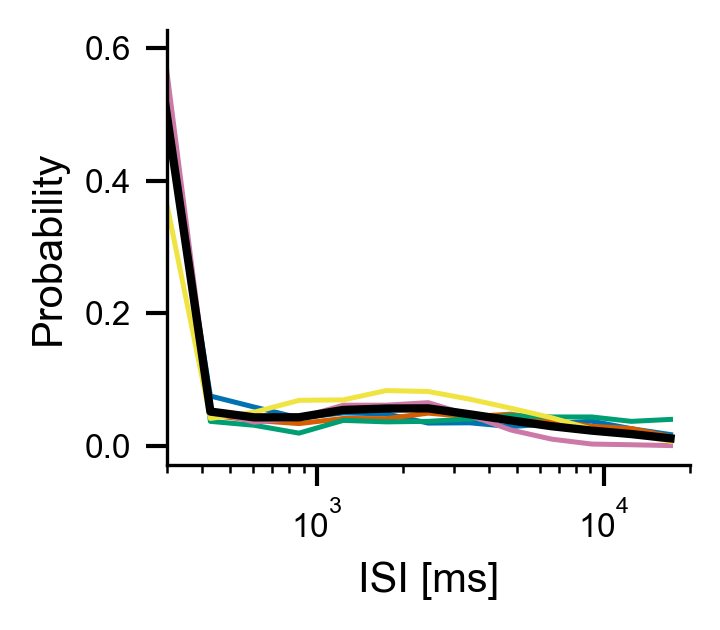

{'dedup_events':        animal block  event_time_ms  head_movement
 0      PV_106   008       48025.75          False
 1      PV_106   008       50656.45           True
 2      PV_106   008       50972.80           True
 3      PV_106   008       51022.75           True
 4      PV_106   008       51339.10           True
 ...       ...   ...            ...            ...
 15389   PV_62   038     2939677.35          False
 15390   PV_62   038     2939745.30          False
 15391   PV_62   038     2943584.30          False
 15392   PV_62   038     2944110.75          False
 15393   PV_62   038     2947439.85          False
 
 [15394 rows x 4 columns],
 'isi_all': {'PV_106': array([2630.7 ,  316.35,   49.95, ..., 2164.5 ,   83.25,   83.25]),
  'PV_126': array([10433.35,  8850.  ,   233.35, ...,  4543.8 ,  8219.2 , 26087.  ]),
  'PV_143': array([10805.85,  1581.75,   116.55, ..., 26423.55,  1465.2 ,   116.55]),
  'PV_57': array([3146.9 ,  135.4 ,  473.75, ...,  186.05, 1843.9 ,  135.35]),
 

In [213]:
# This is the one currently in print: 07.09.25
# Save next to the PDF (inside the timestamped folder)
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\Inter_saccade_intervals_histogram'
export_inter_saccade_intervals_density_traces_from_blocks(
    block_collection,
    export_path=None,
    figure_size=(2.5,2.2),
    color_map=color_map,
    xlim=(300, 20000),
    high_ms=20000,
    #ylim=(0,0.2),
    add_leading_zero_bin=False,
    num_bins=20,log_exponent=0.8
)


Plot data (.pickle) saved to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\Inter_saccade_intervals_histogram\inter_saccade_export_2025_09_07_14_38_52\ISI_histogram_plotdata.pkl
Exported plot + separate legend to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\Inter_saccade_intervals_histogram\inter_saccade_export_2025_09_07_14_38_52


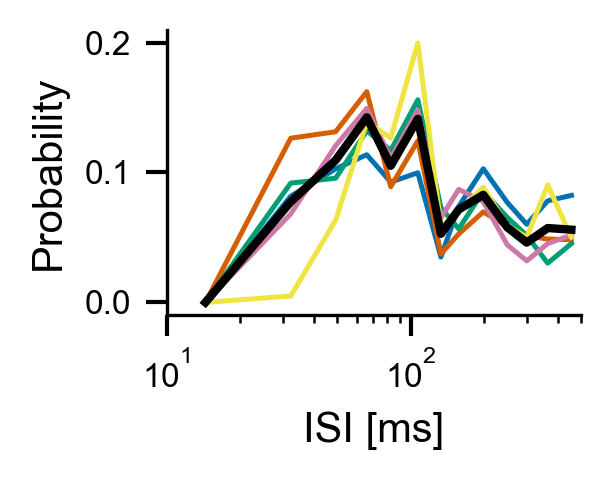

{'dedup_events':        animal block  event_time_ms  head_movement
 0      PV_106   008       48025.75          False
 1      PV_106   008       50656.45           True
 2      PV_106   008       50972.80           True
 3      PV_106   008       51022.75           True
 4      PV_106   008       51339.10           True
 ...       ...   ...            ...            ...
 15389   PV_62   038     2939677.35          False
 15390   PV_62   038     2939745.30          False
 15391   PV_62   038     2943584.30          False
 15392   PV_62   038     2944110.75          False
 15393   PV_62   038     2947439.85          False
 
 [15394 rows x 4 columns],
 'isi_all': {'PV_106': array([2630.7 ,  316.35,   49.95, ..., 2164.5 ,   83.25,   83.25]),
  'PV_126': array([10433.35,  8850.  ,   233.35, ...,  4543.8 ,  8219.2 , 26087.  ]),
  'PV_143': array([10805.85,  1581.75,   116.55, ..., 26423.55,  1465.2 ,   116.55]),
  'PV_57': array([3146.9 ,  135.4 ,  473.75, ...,  186.05, 1843.9 ,  135.35]),
 

In [143]:
#The same one, but zoomed in on the low values:
# Save next to the PDF (inside the timestamped folder)
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\Inter_saccade_intervals_histogram'
export_inter_saccade_intervals_density_traces_from_blocks(
    block_collection,
    export_path=None,
    figure_size=(2.2,1.7),
    color_map=color_map,
    xlim=(10, 500),
    high_ms=500,
    add_leading_zero_bin=False,
    num_bins=20,log_exponent=1
)


Plot data (.pickle) saved to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\Inter_saccade_intervals_histogram\inter_saccade_linear_export_2025_09_07_18_16_30\ISI_hist_linear_plotdata.pkl
Exported plot + separate legend to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\Inter_saccade_intervals_histogram\inter_saccade_linear_export_2025_09_07_18_16_30


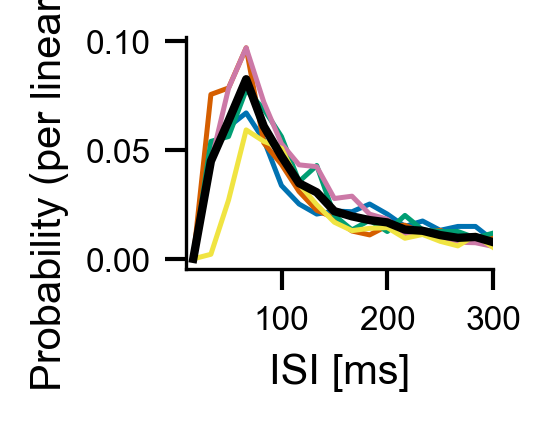

In [210]:
# --- Linear ISI histogram (10–300 ms) with xlim policy control ---
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import datetime as _dt
import pickle

def _snapped_linear_bins(num_bins,
                         frame_ms,
                         low_ms=10.0,
                         high_ms=300.0,
                         add_leading_zero_bin=False):
    """
    Linearly spaced bin edges between low_ms and high_ms, then snap edges to (k+0.5)*Δt
    so each bin contains ≥1 realizable ISI (k*Δt). Includes (kmax+0.5) max boundary.
    """
    num_bins = int(num_bins)
    if num_bins < 1:
        raise ValueError("num_bins must be >= 1")
    if not (np.isfinite(low_ms) and np.isfinite(high_ms)) or not (0 < low_ms < high_ms):
        raise ValueError("low_ms and high_ms must be finite and satisfy 0 < low_ms < high_ms")
    if not np.isfinite(frame_ms) or frame_ms <= 0:
        raise ValueError("frame_ms must be a positive finite number")

    raw = np.linspace(low_ms, high_ms, num_bins + 1)

    # Snap to realizable ISIs: edges at (k + 0.5) * Δt
    k_edges = np.floor(raw / frame_ms) + 0.5
    kmax = int(np.floor(high_ms / frame_ms))
    k_edges = np.clip(k_edges, 0.5, kmax + 0.5)

    # Deduplicate after snapping (snapping can merge neighbors)
    k_edges = np.unique(k_edges)

    # Optional dummy leading edge (zero-count visual bin)
    if add_leading_zero_bin and (k_edges.size == 0 or not np.isclose(k_edges[0], 0.5)):
        k_edges = np.r_[0.25, k_edges]

    # Ensure we include the max boundary
    if k_edges[-1] < (kmax + 0.5):
        k_edges = np.r_[k_edges, (kmax + 0.5)]

    return k_edges * frame_ms

def _fold_counts_to_xlim_truthful_linear(counts, edges, xlim_tuple, renormalize=False):
    """
    Linear-axis version: fold ALL probability outside [low, high] into first/last displayed bins.
    """
    low, high = float(xlim_tuple[0]), float(xlim_tuple[1])
    if not (np.isfinite(low) and np.isfinite(high) and low < high):
        centers = 0.5*(edges[:-1] + edges[1:])
        return counts, edges, centers, 0, len(counts)-1

    idx_lo = np.searchsorted(edges, low,  side='right') - 1
    idx_hi = np.searchsorted(edges, high, side='left')  - 1
    idx_lo = max(0, min(idx_lo, len(counts)-1))
    idx_hi = max(0, min(idx_hi, len(counts)-1))

    counts_fold = counts.copy()
    if idx_lo > 0:
        left_mass = counts_fold[:idx_lo].sum()
        counts_fold[:idx_lo] = 0.0
        counts_fold[idx_lo] += left_mass
    if idx_hi < len(counts_fold) - 1:
        right_mass = counts_fold[idx_hi+1:].sum()
        counts_fold[idx_hi+1:] = 0.0
        counts_fold[idx_hi] += right_mass

    disp_counts  = counts_fold[idx_lo:idx_hi+1]
    disp_edges   = edges[idx_lo:idx_hi+2]
    disp_centers = 0.5*(disp_edges[:-1] + disp_edges[1:])

    if renormalize:
        s = disp_counts.sum()
        if s > 0:
            disp_counts = disp_counts / s
    return disp_counts, disp_edges, disp_centers, idx_lo, idx_hi

def _slice_counts_to_xlim_linear(counts, edges, xlim_tuple, renormalize=True):
    """
    Slice bins to [low, high] (no folding). If renormalize=True, rescale to sum to 1 (conditional).
    """
    low, high = float(xlim_tuple[0]), float(xlim_tuple[1])
    if not (np.isfinite(low) and np.isfinite(high) and low < high):
        centers = 0.5*(edges[:-1] + edges[1:])
        return counts, edges, centers, 0, len(counts)-1

    idx_lo = np.searchsorted(edges, low,  side='right') - 1
    idx_hi = np.searchsorted(edges, high, side='left')  - 1
    idx_lo = max(0, min(idx_lo, len(counts)-1))
    idx_hi = max(0, min(idx_hi, len(counts)-1))

    disp_counts  = counts[idx_lo:idx_hi+1].copy()
    disp_edges   = edges[idx_lo:idx_hi+2]
    disp_centers = 0.5*(disp_edges[:-1] + disp_edges[1:])

    if renormalize:
        s = disp_counts.sum()
        if s > 0:
            disp_counts /= s
    return disp_counts, disp_edges, disp_centers, idx_lo, idx_hi

def export_inter_saccade_intervals_density_traces_from_blocks_LINEAR(
    block_collection,
    figure_size=(2.0, 1.5),
    export_path=None,
    plot_name='ISI_hist_linear_10_300ms.pdf',
    num_bins=20,
    # linear bin domain:
    low_ms=10.0,
    high_ms=300.0,
    pair_threshold_ms=60.0,
    min_isi_ms=None,          # if None -> 0.75 * frame_ms
    add_leading_zero_bin=False,
    font_family='Arial',
    color_template="okabeito",
    custom_colors=None,
    color_map=None,           # {'PV_62':'#...', ...}
    avg_label="All (combined)",
    avg_color="k",
    avg_linewidth=2.0,
    avg_linestyle="-",
    # windowing & policy:
    xlim=(10.0, 300.0),       # display range; used by policy below
    ylim=None,
    xlim_policy="conditional",  # "conditional" | "slice" | "fold"
    export_pickle_path=None,    # if None and export_path is set, will save next to the PDF
    pickle_name="ISI_hist_linear_plotdata.pkl"
):
    """
    Linear-binned ISI histograms over [low_ms, high_ms]. xlim_policy controls how to handle data
    relative to the display window:
        - "conditional": slice to [xlim], then renormalize (sum=1 within window)
        - "slice":       slice to [xlim], no renormalization (sum<=1)
        - "fold":        fold all mass outside [xlim] into the first/last displayed bins
    """
    # ---- Gather events / dedupe ----
    events = _collect_events_from_blocks(block_collection)
    if events.empty:
        raise ValueError("No saccade events found.")
    dedup = _dedupe_lr_pairs(events, pair_threshold_ms=pair_threshold_ms)

    # ---- ISIs per animal ----
    frame_ms = _estimate_frame_interval_ms(block_collection)
    min_isi_eff = (0.75*frame_ms) if (min_isi_ms is None) else float(min_isi_ms)
    isi_all = _compute_blockwise_isis(dedup, min_isi_ms=min_isi_eff)
    animals = sorted(dedup['animal'].dropna().unique())

    # ---- Colors ----
    if color_map is None:
        cmap = build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
    else:
        fallback = build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
        cmap = {a: color_map.get(a, fallback[a]) for a in animals}

    # ---- Linear bins (snapped to (k+0.5)Δt) ----
    bins = _snapped_linear_bins(num_bins=num_bins,
                                frame_ms=frame_ms,
                                low_ms=float(low_ms),
                                high_ms=float(high_ms),
                                add_leading_zero_bin=add_leading_zero_bin)
    bin_centers = 0.5*(bins[:-1] + bins[1:])

    # ---- Figure ----
    plt.rcParams['font.family'] = 'sans-serif'; plt.rcParams['font.sans-serif'] = [font_family]
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)
    legend_handles, legend_labels = [], []

    total_counts = np.zeros(len(bins)-1, dtype=float)
    valid_any = False

    plot_data = {
        "params": {
            "figure_size": figure_size, "num_bins": num_bins,
            "low_ms": low_ms, "high_ms": high_ms,
            "pair_threshold_ms": pair_threshold_ms, "min_isi_ms": min_isi_ms,
            "add_leading_zero_bin": add_leading_zero_bin,
            "xlim": xlim, "ylim": ylim, "xlim_policy": xlim_policy,
            "font_family": font_family, "color_template": color_template
        },
        "frame_ms": frame_ms,
        "bins": bins,
        "animals": animals,
        "color_map": cmap,
        "per_animal": {},
        "combined": {}
    }

    # ---- Per-animal traces (pmf per bin) ----
    for a in animals:
        isi = isi_all.get(a, np.array([]))
        if isi.size == 0:
            continue

        hist, _ = np.histogram(isi, bins=bins)
        if hist.sum() == 0:
            continue
        valid_any = True
        total_counts += hist

        dens = hist.astype(float) / hist.sum()  # pmf over these linear bins

        if xlim is not None:
            if xlim_policy == "fold":
                y_plot, disp_edges, x_plot, _, _ = _fold_counts_to_xlim_truthful_linear(
                    dens, bins, xlim, renormalize=False)
            elif xlim_policy == "slice":
                y_plot, disp_edges, x_plot, _, _ = _slice_counts_to_xlim_linear(
                    dens, bins, xlim, renormalize=False)
            elif xlim_policy == "conditional":
                y_plot, disp_edges, x_plot, _, _ = _slice_counts_to_xlim_linear(
                    dens, bins, xlim, renormalize=True)
            else:
                raise ValueError("xlim_policy must be 'conditional', 'slice', or 'fold'")
        else:
            if add_leading_zero_bin:
                x_plot = np.r_[bins[0], bin_centers[1:]]
                y_plot = np.r_[0.0, dens[1:]]
            else:
                x_plot, y_plot = bin_centers, dens

        plot_data["per_animal"][a] = {"hist": hist, "density": dens, "x": x_plot, "y": y_plot}
        h, = ax.plot(x_plot, y_plot, linewidth=1.2, color=cmap[a], label=str(a))
        legend_handles.append(h); legend_labels.append(str(a))

    # ---- Combined trace ----
    if valid_any and total_counts.sum() > 0:
        total_dens = total_counts / total_counts.sum()
        if xlim is not None:
            if xlim_policy == "fold":
                y_all, _, x_all, _, _ = _fold_counts_to_xlim_truthful_linear(
                    total_dens, bins, xlim, renormalize=False)
            elif xlim_policy == "slice":
                y_all, _, x_all, _, _ = _slice_counts_to_xlim_linear(
                    total_dens, bins, xlim, renormalize=False)
            elif xlim_policy == "conditional":
                y_all, _, x_all, _, _ = _slice_counts_to_xlim_linear(
                    total_dens, bins, xlim, renormalize=True)
        else:
            if add_leading_zero_bin:
                x_all = np.r_[bins[0], bin_centers[1:]]
                y_all = np.r_[0.0, total_dens[1:]]
            else:
                x_all, y_all = bin_centers, total_dens

        plot_data["combined"] = {
            "total_counts": total_counts,
            "total_density": total_dens,
            "x": x_all,
            "y": y_all,
            "label": avg_label
        }

        h_all, = ax.plot(x_all, y_all, avg_linestyle, color=avg_color,
                         linewidth=avg_linewidth, label=avg_label, zorder=10)
        legend_handles.insert(0, h_all); legend_labels.insert(0, avg_label)

    # ---- Axes / cosmetics ----
    ax.set_xscale('linear')
    if xlim is not None: ax.set_xlim(xlim[0], xlim[1])
    else:                ax.set_xlim(bins[0], bins[-1])
    if ylim is not None: ax.set_ylim(ylim[0], ylim[1])

    ax.set_xlabel('ISI [ms]', fontsize=10)
    ax.set_ylabel('Probability (per linear bin)', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8, length=5, width=1, direction='out')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.grid(False)
    plt.tight_layout()

    out = {
        'dedup_events': dedup,
        'isi_all': isi_all,
        'frame_ms': frame_ms,
        'bins': bins,
        'color_map': cmap,
        'combined': plot_data["combined"]
    }

    # ---- Export (figure + legend + pickle) ----
    outdir = None
    if export_path is not None:
        ts = _dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        outdir = Path(export_path) / f"inter_saccade_linear_export_{ts}"
        outdir.mkdir(parents=True, exist_ok=True)
        fig.savefig(outdir/plot_name, format='pdf', bbox_inches='tight', dpi=300)

        if legend_handles:
            fig_leg = plt.figure(figsize=(2.0, 0.28*max(1,len(legend_labels))+0.4), dpi=300)
            fig_leg.legend(legend_handles, legend_labels, loc='center', frameon=False, ncol=1, prop={'size':8})
            fig_leg.savefig(outdir/('legend_'+plot_name), format='pdf', bbox_inches='tight', dpi=300)
            plt.close(fig_leg)

    if export_pickle_path is not None:
        export_pickle_path = Path(export_pickle_path)
        export_pickle_path.parent.mkdir(parents=True, exist_ok=True)
        with open(export_pickle_path, "wb") as f:
            pickle.dump(plot_data, f)
        print(f"Plot data (.pickle) saved to: {export_pickle_path}")
    elif outdir is not None:
        pkl_path = outdir / pickle_name
        with open(pkl_path, "wb") as f:
            pickle.dump(plot_data, f)
        print(f"Plot data (.pickle) saved to: {pkl_path}")

    if outdir is not None:
        print("Exported plot + separate legend to:", outdir)

    plt.show()
    return out
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\Inter_saccade_intervals_histogram'
out = export_inter_saccade_intervals_density_traces_from_blocks_LINEAR(
    block_collection,
    figure_size=(2,1.5),
    color_map=color_map,          # or omit to auto-generate
    num_bins=1176,
    low_ms=10, high_ms=20000,       # build linear bins over 10–300 ms
    xlim=(10,300),                # show 10–300 ms
    xlim_policy="slice",    # only in-window events, renormalized to sum=1
    add_leading_zero_bin=False,
    export_path = export_path
)


In [175]:
np.sum(np.array([0.        , 0.04485314, 0.06337655, 0.08249537, 0.06086266,
         0.04710241, 0.03473141, 0.03056364, 0.02189733, 0.01951574,
         0.01779571, 0.01673723, 0.01342948, 0.01290024, 0.01091559,
         0.00965864, 0.01005557, 0.00767399, 0.00893093, 0.00707859,
         0.00674782, 0.00575549, 0.00701244, 0.00654935, 0.00522625,
         0.00529241, 0.00641704, 0.00582165, 0.00496163, 0.00469701,
         0.00357237, 0.00304313, 0.00377084, 0.00449854, 0.00344006,
         0.00258005, 0.00363853, 0.00277851, 0.00357237, 0.0026462 ,
         0.00403546, 0.00291082, 0.00251389, 0.00258005, 0.00310929,
         0.00238158, 0.00291082, 0.00198465, 0.00211696, 0.00271236,
         0.00218312, 0.00231543, 0.00244774, 0.00218312, 0.00145541,
         0.00152157, 0.00244774, 0.0019185 , 0.00152157, 0.00218312]))

0.66002911

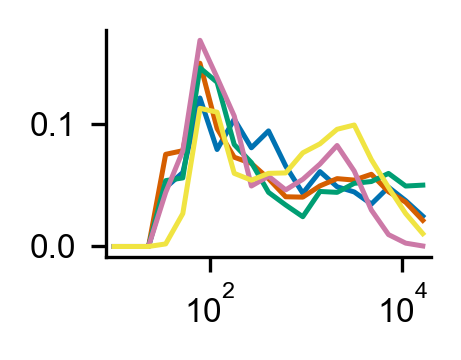

In [20]:
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\Inter_saccade_intervals_histogram'
out = export_inter_saccade_intervals_density_traces_from_blocks(
    block_collection,
    figure_size=(1.7, 1.3),
    export_path=None,
    num_bins=20,
    plot_name='ISI_histogram.pdf'
)

In [45]:
def _snapped_log_bins(num_bins, frame_ms, low_ms, high_ms, add_leading_zero_bin=True,log_base=10.0):
    # snap edges to (k+0.5)*Δt so each bin contains ≥1 realizable ISI (k*Δt)
    raw = np.logspace(low_ms, high_ms, int(num_bins)+1, log_base=log_base)
    k_edges = np.floor(raw/frame_ms) + 0.5
    kmax = int(np.floor(high_ms/frame_ms))
    k_edges = np.clip(k_edges, 0.5, kmax+0.5)
    k_edges = np.unique(k_edges)
    if add_leading_zero_bin and (k_edges.size==0 or not np.isclose(k_edges[0],0.5)):
        k_edges = np.r_[0.25, k_edges]          # dummy zero-count bin
    if k_edges[-1] < (kmax+0.5):
        k_edges = np.r_[k_edges, (kmax+0.5)]
    return k_edges * frame_ms

def export_inter_saccade_intervals_density_traces_from_blocks(
    block_collection,
    figure_size=(1.8, 1.2),
    export_path=None,
    plot_name='ISI_histogram.pdf',
    num_bins=20,
    high_ms=20000.0,
    pair_threshold_ms=60.0,
    min_isi_ms=None,          # if None -> 0.75 * frame_ms
    first_bin_factor=0.5,     # first real edge = 0.5×Δt
    add_leading_zero_bin=True,
    font_family='Arial',
    color_template="okabeito",
    custom_colors=None,
    color_map=None,           # {'PV_62':'#...', ...}
    xlim=None,
    avg_label="All (combined)",
    avg_color="k",
    avg_linewidth=2.0,
    avg_linestyle="-"
):
    # Collect & dedupe
    events = _collect_events_from_blocks(block_collection)
    if events.empty:
        raise ValueError("No saccade events found.")
    dedup = _dedupe_lr_pairs(events, pair_threshold_ms=pair_threshold_ms)

    # Frame interval & ISIs
    frame_ms = _estimate_frame_interval_ms(block_collection)
    min_isi_eff = (0.75*frame_ms) if (min_isi_ms is None) else float(min_isi_ms)
    isi_all = _compute_blockwise_isis(dedup, min_isi_ms=min_isi_eff)
    animals = sorted(dedup['animal'].dropna().unique())

    # Colors
    if color_map is None:
        cmap = build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
    else:
        fallback = build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
        cmap = {a: color_map.get(a, fallback[a]) for a in animals}

    # Global binning
    low_ms = max(1e-6, first_bin_factor*frame_ms)
    bins = _snapped_log_bins(num_bins, frame_ms, low_ms, float(high_ms), add_leading_zero_bin)
    bin_centers = np.sqrt(bins[:-1]*bins[1:])

    # Style & axes
    plt.rcParams['font.family'] = 'sans-serif'; plt.rcParams['font.sans-serif'] = [font_family]
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)
    legend_handles, legend_labels = [], []

    # Helper: fold probability outside xlim into edge bins
    def _fold_counts_to_xlim(counts, edges, xlim_tuple):
        """
        counts: per-bin probabilities (sum == 1)
        edges:  bin edges (len = len(counts) + 1)
        xlim_tuple: (low, high)
        Returns: disp_counts (renorm), disp_edges, disp_centers, idx_lo, idx_hi
        """
        low, high = float(xlim_tuple[0]), float(xlim_tuple[1])
        if not (np.isfinite(low) and np.isfinite(high) and low < high):
            centers = np.sqrt(edges[:-1]*edges[1:])
            return counts, edges, centers, 0, len(counts)-1

        idx_lo = np.searchsorted(edges, low, side='right') - 1
        idx_lo = max(0, min(idx_lo, len(counts)-1))

        idx_hi = np.searchsorted(edges, high, side='left') - 1
        idx_hi = max(0, min(idx_hi, len(counts)-1))

        counts_fold = counts.copy()

        # Left tail -> first displayed bin
        left_mask = edges[1:] <= low
        left_mass = counts_fold[left_mask].sum()
        counts_fold[left_mask] = 0.0
        counts_fold[idx_lo] += left_mass

        # Right tail -> last displayed bin
        right_mask = edges[:-1] >= high
        right_mass = counts_fold[right_mask].sum()
        counts_fold[right_mask] = 0.0
        counts_fold[idx_hi] += right_mass

        disp_counts = counts_fold[idx_lo:idx_hi+1]
        disp_edges  = edges[idx_lo:idx_hi+2]
        s = disp_counts.sum()
        if s > 0:
            disp_counts = disp_counts / s
        disp_centers = np.sqrt(disp_edges[:-1]*disp_edges[1:])
        return disp_counts, disp_edges, disp_centers, idx_lo, idx_hi

    # --- Per-animal plotting + accumulate total counts ---
    total_counts = np.zeros(len(bins)-1, dtype=float)
    valid_any = False

    for a in animals:
        isi = isi_all.get(a, np.array([]))
        if isi.size == 0:
            continue

        hist, _ = np.histogram(isi, bins=bins)
        if hist.sum() == 0:
            continue
        valid_any = True
        total_counts += hist

        dens = hist.astype(float) / hist.sum()

        if xlim is not None:
            disp_dens, disp_edges, disp_centers, idx_lo, idx_hi = _fold_counts_to_xlim(dens, bins, xlim)
            x_plot, y_plot = disp_centers, disp_dens
        else:
            if add_leading_zero_bin:
                x_plot = np.r_[bins[0], bin_centers[1:]]
                y_plot = np.r_[0.0, dens[1:]]
            else:
                x_plot, y_plot = bin_centers, dens

        h, = ax.plot(x_plot, y_plot, linewidth=1.2, color=cmap[a], label=str(a))
        legend_handles.append(h); legend_labels.append(str(a))

    # --- Combined "All (combined)" average trace ---
    combined = {}
    if valid_any and total_counts.sum() > 0:
        total_dens = total_counts / total_counts.sum()

        if xlim is not None:
            disp_dens_all, disp_edges_all, disp_centers_all, _, _ = _fold_counts_to_xlim(total_dens, bins, xlim)
            x_all, y_all = disp_centers_all, disp_dens_all
        else:
            if add_leading_zero_bin:
                x_all = np.r_[bins[0], bin_centers[1:]]
                y_all = np.r_[0.0, total_dens[1:]]
            else:
                x_all, y_all = bin_centers, total_dens

        h_all, = ax.plot(x_all, y_all, avg_linestyle, color=avg_color, linewidth=avg_linewidth, label=avg_label, zorder=10)
        legend_handles.insert(0, h_all); legend_labels.insert(0, avg_label)

        combined = {
            'total_counts': total_counts,
            'total_density': total_dens,
            'display_x': x_all,
            'display_y': y_all
        }

    # Axes cosmetics
    ax.set_xscale('log')
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    else:
        ax.set_xlim(bins[0], bins[-1])

    ax.set_xlabel('ISI [ms]', fontsize=10); ax.set_ylabel('Probability', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8, length=5, width=1, direction='out')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.grid(False)
    plt.tight_layout()

    out = {
        'dedup_events': dedup,
        'isi_all': isi_all,
        'frame_ms': frame_ms,
        'bins': bins,
        'color_map': cmap,
        'combined': combined
    }

    # Export main plot + separate legend
    if export_path is not None:
        ts = _dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        outdir = Path(export_path) / f"inter_saccade_export_{ts}"
        outdir.mkdir(parents=True, exist_ok=True)
        fig.savefig(outdir/plot_name, format='pdf', bbox_inches='tight', dpi=300)

        if legend_handles:
            fig_leg = plt.figure(figsize=(2.0, 0.28*max(1,len(legend_labels))+0.4), dpi=300)
            fig_leg.legend(legend_handles, legend_labels, loc='center', frameon=False, ncol=1, prop={'size':8})
            fig_leg.savefig(outdir/('legend_'+plot_name), format='pdf', bbox_inches='tight', dpi=300)
            plt.close(fig_leg)
        print("Exported plot + separate legend to:", outdir)

    plt.show()
    return out


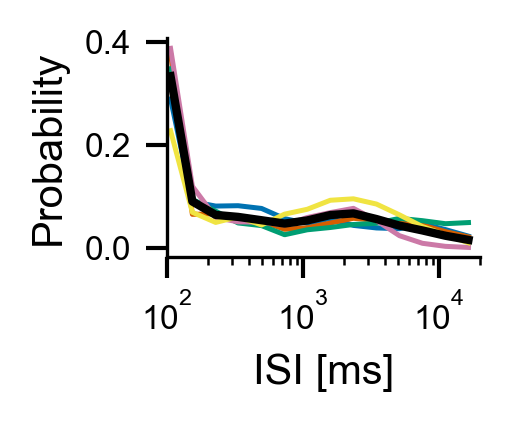

{'dedup_events':        animal block  event_time_ms  head_movement
 0      PV_106   008       48025.75          False
 1      PV_106   008       50656.45           True
 2      PV_106   008       50972.80           True
 3      PV_106   008       51022.75           True
 4      PV_106   008       51339.10           True
 ...       ...   ...            ...            ...
 15389   PV_62   038     2939677.35          False
 15390   PV_62   038     2939745.30          False
 15391   PV_62   038     2943584.30          False
 15392   PV_62   038     2944110.75          False
 15393   PV_62   038     2947439.85          False
 
 [15394 rows x 4 columns],
 'isi_all': {'PV_106': array([2630.7 ,  316.35,   49.95, ..., 2164.5 ,   83.25,   83.25]),
  'PV_126': array([10433.35,  8850.  ,   233.35, ...,  4543.8 ,  8219.2 , 26087.  ]),
  'PV_143': array([10805.85,  1581.75,   116.55, ..., 26423.55,  1465.2 ,   116.55]),
  'PV_57': array([3146.9 ,  135.4 ,  473.75, ...,  186.05, 1843.9 ,  135.35]),
 

In [40]:
export_inter_saccade_intervals_density_traces_from_blocks(block_collection,
                                                          figure_size=(1.8,1.5),
                                                          export_path=None,
                                                          xlim=(100,20000))

In [29]:
def export_inter_saccade_intervals_density_traces_from_blocks(
    block_collection,
    figure_size=(1.8, 1.2),
    export_path=None,
    plot_name='ISI_histogram.pdf',
    num_bins=20,
    high_ms=20000.0,
    pair_threshold_ms=60.0,
    min_isi_ms=None,          # if None -> 0.75 * frame_ms
    first_bin_factor=0.5,     # first real edge = 0.5×Δt
    add_leading_zero_bin=True,
    font_family='Arial',
    color_template="okabeito",
    custom_colors=None,
    color_map=None,            # <-- pass a dict {'PV_62':'#...', ...} to lock colors
    xlim=None
):
    # Collect & dedupe
    events = _collect_events_from_blocks(block_collection)
    if events.empty:
        raise ValueError("No saccade events found.")
    dedup = _dedupe_lr_pairs(events, pair_threshold_ms=pair_threshold_ms)

    # Frame interval & ISIs
    frame_ms = _estimate_frame_interval_ms(block_collection)
    min_isi_eff = (0.75*frame_ms) if (min_isi_ms is None) else float(min_isi_ms)
    isi_all = _compute_blockwise_isis(dedup, min_isi_ms=min_isi_eff)
    animals = sorted(dedup['animal'].dropna().unique())

    # Colors
    if color_map is None:
        cmap = build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
    else:
        # ensure every animal has a color; fall back to template if needed
        fallback = build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
        cmap = {a: color_map.get(a, fallback[a]) for a in animals}

    # Binning (global bins; we’ll fold mass at plot-time based on xlim)
    low_ms = max(1e-6, first_bin_factor*frame_ms)
    bins = _snapped_log_bins(num_bins, frame_ms, low_ms, float(high_ms), add_leading_zero_bin)
    bin_centers = np.sqrt(bins[:-1]*bins[1:])

    # Style & plot
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = [font_family]
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)
    legend_handles, legend_labels = [], []

    # Helper: fold all probability mass outside xlim into edge bins
    def _fold_counts_to_xlim(counts, edges, xlim_tuple):
        """
        counts: per-bin probabilities (sum == 1)
        edges:  bin edges, len = len(counts) + 1
        xlim_tuple: (low, high)
        Returns: disp_counts (renormalized), disp_edges, disp_centers, idx_lo, idx_hi
        """
        low, high = float(xlim_tuple[0]), float(xlim_tuple[1])
        if not (np.isfinite(low) and np.isfinite(high) and low < high):
            # invalid; just return original
            centers = np.sqrt(edges[:-1]*edges[1:])
            return counts, edges, centers, 0, len(counts)-1

        # Index of first displayed bin (bin whose interval intersects [low, ...])
        # We'll "fold" everything strictly below `low` into this bin.
        # Use bin index where edges[idx] <= low < edges[idx+1]; clamp to valid range
        idx_lo = np.searchsorted(edges, low, side='right') - 1
        idx_lo = max(0, min(idx_lo, len(counts)-1))

        # Index of last displayed bin (bin whose interval intersects [..., high])
        # We'll fold everything strictly above `high` into this bin.
        idx_hi = np.searchsorted(edges, high, side='left') - 1
        idx_hi = max(0, min(idx_hi, len(counts)-1))

        counts_fold = counts.copy()

        # Mass below: bins with right edge <= low belong to the left fold mass
        left_mask = edges[1:] <= low
        left_mass = counts_fold[left_mask].sum()
        # zero them out and add to idx_lo
        counts_fold[left_mask] = 0.0
        counts_fold[idx_lo] += left_mass

        # Mass above: bins with left edge >= high belong to the right fold mass
        right_mask = edges[:-1] >= high
        right_mass = counts_fold[right_mask].sum()
        counts_fold[right_mask] = 0.0
        counts_fold[idx_hi] += right_mass

        # Now restrict visible slice
        disp_counts = counts_fold[idx_lo:idx_hi+1]
        disp_edges = edges[idx_lo:idx_hi+2]  # +2 because edges are one longer
        # Numerical safety: renormalize to sum=1
        s = disp_counts.sum()
        if s > 0:
            disp_counts = disp_counts / s

        disp_centers = np.sqrt(disp_edges[:-1]*disp_edges[1:])
        return disp_counts, disp_edges, disp_centers, idx_lo, idx_hi

    for a in animals:
        isi = isi_all.get(a, np.array([]))
        if isi.size == 0:
            continue

        # Histogram over global bins
        hist, _ = np.histogram(isi, bins=bins)
        if hist.sum() == 0:
            continue
        dens = hist.astype(float) / hist.sum()

        if xlim is not None:
            # Fold tails into the first/last visible bins
            disp_dens, disp_edges, disp_centers, idx_lo, idx_hi = _fold_counts_to_xlim(dens, bins, xlim)
            # Plot at bin centers within the displayed slice
            x_plot, y_plot = disp_centers, disp_dens
        else:
            # default behavior (optionally with a dummy first point)
            if add_leading_zero_bin:
                x_plot = np.r_[bins[0], bin_centers[1:]]
                y_plot = np.r_[0.0, dens[1:]]
            else:
                x_plot, y_plot = bin_centers, dens

        h, = ax.plot(x_plot, y_plot, linewidth=1.2, color=cmap[a], label=str(a))
        legend_handles.append(h)
        legend_labels.append(str(a))

    ax.set_xscale('log')
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    else:
        ax.set_xlim(bins[0], bins[-1])

    ax.set_xlabel('ISI [ms]', fontsize=10)
    ax.set_ylabel('Probability', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8, length=5, width=1, direction='out')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)
    plt.tight_layout()

    out = {
        'dedup_events': dedup,
        'isi_all': isi_all,
        'frame_ms': frame_ms,
        'bins': bins,
        'color_map': cmap
    }

    # Export main plot + separate legend
    if export_path is not None:
        ts = _dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        outdir = Path(export_path) / f"inter_saccade_export_{ts}"
        outdir.mkdir(parents=True, exist_ok=True)
        fig.savefig(outdir/plot_name, format='pdf', bbox_inches='tight', dpi=300)

        if legend_handles:
            fig_leg = plt.figure(figsize=(2.0, 0.28*max(1,len(legend_labels))+0.4), dpi=300)
            fig_leg.legend(legend_handles, legend_labels, loc='center', frameon=False, ncol=1, prop={'size':8})
            fig_leg.savefig(outdir/('legend_'+plot_name), format='pdf', bbox_inches='tight', dpi=300)
            plt.close(fig_leg)
        print("Exported plot + separate legend to:", outdir)

    plt.show()
    return out


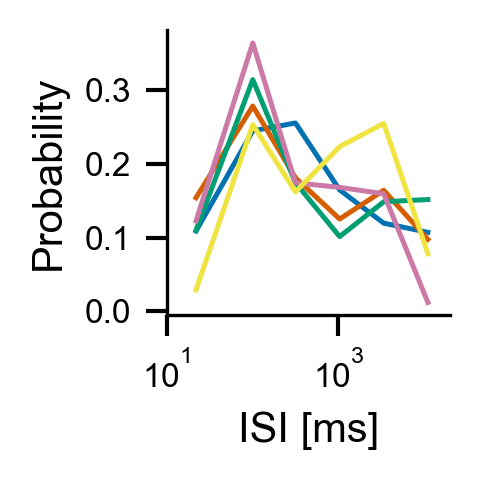

In [36]:
out = export_inter_saccade_intervals_density_traces_from_blocks(
    block_collection,
    figure_size=(1.7, 1.7),
    export_path=None,
    plot_name='ISI_histogram.pdf',
    first_bin_factor=0,
    color_map=color_map,
    xlim=(10, 20000),
    add_leading_zero_bin=False,
    num_bins=20
)


In [24]:
# =========================
# Universal color utilities
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
from pathlib import Path
import datetime as _dt

COLOR_TEMPLATES = {
    # Colorblind-safe (Okabe–Ito)
    "okabeito": ["#0072B2", "#D55E00", "#009E73", "#CC79A7",
                 "#F0E442", "#56B4E9", "#E69F00", "#000000"],
    # Tableau-10 as an alternative
    "tableau10": [plt.get_cmap("tab10")(i) for i in range(10)],
}

def build_color_map(labels, template="okabeito", custom=None, order=None):
    """
    Return dict {label -> color}. If you want stable per-animal colors across figures,
    pass a canonical 'order' (list of all animals) or pass an explicit color_map to the
    plotting functions.
    """
    labs = list(order) if order is not None else list(labels)
    base = list(custom) if custom is not None else list(COLOR_TEMPLATES.get(template, COLOR_TEMPLATES["okabeito"]))
    return {lab: base[i % len(base)] for i, lab in enumerate(labs)}

def set_axes_color_cycle(ax, labels, color_map):
    ax.set_prop_cycle(cycler(color=[color_map[l] for l in labels]))


# ============================================================
# ISI density traces from block_collection (accepts color_map)
# ============================================================
def _collect_events_from_blocks(block_collection):
    rows = []
    for b in block_collection:
        animal = getattr(b, 'animal_call', None)
        blockn = getattr(b, 'block_num', None)
        for eye, sdf in (('L', getattr(b, 'l_saccade_df', None)),
                         ('R', getattr(b, 'r_saccade_df', None))):
            if sdf is None or len(sdf) == 0: continue
            s_on = pd.to_numeric(sdf.get('saccade_on_ms', pd.Series([], dtype='float64')), errors='coerce')
            hm = sdf['head_movement'] if 'head_movement' in sdf.columns else pd.Series(False, index=sdf.index)
            rows.append(pd.DataFrame({
                'animal': animal, 'block': blockn, 'eye': eye,
                'saccade_on_ms': s_on, 'head_movement': hm.astype(bool)
            }).dropna(subset=['saccade_on_ms']))
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(
        columns=['animal','block','eye','saccade_on_ms','head_movement'])

def _estimate_frame_interval_ms(block_collection, fallback_ms=16.67):
    dts=[]
    for b in block_collection:
        for df in (getattr(b,'left_eye_data',None), getattr(b,'right_eye_data',None)):
            if df is None or 'ms_axis' not in df.columns: continue
            ms = pd.to_numeric(df['ms_axis'], errors='coerce').dropna().to_numpy()
            if ms.size>3:
                dt = np.diff(ms); dt = dt[(dt>0)&np.isfinite(dt)]
                if dt.size: dts.append(np.median(dt))
    return float(np.median(dts)) if dts else float(fallback_ms)

def _dedupe_lr_pairs(events_df, pair_threshold_ms=60.0):
    out=[]
    for (animal,block), g in events_df.groupby(['animal','block'], dropna=False):
        L = g[g['eye']=='L'].sort_values('saccade_on_ms')
        R = g[g['eye']=='R'].sort_values('saccade_on_ms')
        lt, rt = L['saccade_on_ms'].to_numpy(float), R['saccade_on_ms'].to_numpy(float)
        lhm = L['head_movement'].to_numpy(bool) if len(L) else np.array([],bool)
        rhm = R['head_movement'].to_numpy(bool) if len(R) else np.array([],bool)
        i=j=0; ev_t=[]; ev_hm=[]
        while i<len(lt) and j<len(rt):
            dt = lt[i]-rt[j]
            if abs(dt)<=pair_threshold_ms:
                ev_t.append(min(lt[i],rt[j])); ev_hm.append(bool(lhm[i] or rhm[j])); i+=1; j+=1
            elif lt[i] < rt[j]-pair_threshold_ms:
                ev_t.append(lt[i]); ev_hm.append(bool(lhm[i])); i+=1
            else:
                ev_t.append(rt[j]); ev_hm.append(bool(rhm[j])); j+=1
        while i<len(lt): ev_t.append(lt[i]); ev_hm.append(bool(lhm[i])); i+=1
        while j<len(rt): ev_t.append(rt[j]); ev_hm.append(bool(rhm[j])); j+=1
        out.append(pd.DataFrame({'animal':animal,'block':block,'event_time_ms':ev_t,'head_movement':ev_hm}))
    return pd.concat(out, ignore_index=True) if out else pd.DataFrame(
        columns=['animal','block','event_time_ms','head_movement'])

def _compute_blockwise_isis(dedup_df, min_isi_ms):
    isi_all={}
    for (animal,block), g in dedup_df.groupby(['animal','block'], dropna=False):
        t = np.sort(g['event_time_ms'].to_numpy())
        if t.size>1:
            d = np.diff(t); d = d[np.isfinite(d) & (d>=min_isi_ms)]
            if d.size: isi_all.setdefault(animal,[]).append(d)
    return {a:(np.concatenate(v) if v else np.array([],float)) for a,v in isi_all.items()}

def _snapped_log_bins(num_bins, frame_ms, low_ms, high_ms, add_leading_zero_bin=True):
    # snap edges to (k+0.5)*Δt so each bin contains ≥1 realizable ISI (k*Δt)
    raw = np.geomspace(low_ms, high_ms, int(num_bins)+1)
    k_edges = np.floor(raw/frame_ms) + 0.5
    kmax = int(np.floor(high_ms/frame_ms))
    k_edges = np.clip(k_edges, 0.5, kmax+0.5)
    k_edges = np.unique(k_edges)
    if add_leading_zero_bin and (k_edges.size==0 or not np.isclose(k_edges[0],0.5)):
        k_edges = np.r_[0.25, k_edges]          # dummy zero-count bin
    if k_edges[-1] < (kmax+0.5):
        k_edges = np.r_[k_edges, (kmax+0.5)]
    return k_edges * frame_ms

def export_inter_saccade_intervals_density_traces_from_blocks(
    block_collection,
    figure_size=(1.8, 1.2),
    export_path=None,
    plot_name='ISI_histogram.pdf',
    num_bins=20,
    high_ms=20000.0,
    pair_threshold_ms=60.0,
    min_isi_ms=None,          # if None -> 0.75 * frame_ms
    first_bin_factor=0.5,     # first real edge = 0.5×Δt
    add_leading_zero_bin=True,
    font_family='Arial',
    color_template="okabeito",
    custom_colors=None,
    color_map=None,            # <-- pass a dict {'PV_62':'#...', ...} to lock colors
    xlim=None
):
    # Collect & dedupe
    events = _collect_events_from_blocks(block_collection)
    if events.empty: raise ValueError("No saccade events found.")
    dedup = _dedupe_lr_pairs(events, pair_threshold_ms=pair_threshold_ms)

    # Frame interval & ISIs
    frame_ms = _estimate_frame_interval_ms(block_collection)
    min_isi_eff = (0.75*frame_ms) if (min_isi_ms is None) else float(min_isi_ms)
    isi_all = _compute_blockwise_isis(dedup, min_isi_ms=min_isi_eff)
    animals = sorted(dedup['animal'].dropna().unique())

    # Colors
    if color_map is None:
        cmap = build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
    else:
        # ensure every animal has a color; fall back to template if needed
        fallback = build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
        cmap = {a: color_map.get(a, fallback[a]) for a in animals}

    # Binning
    low_ms = max(1e-6, first_bin_factor*frame_ms)
    bins = _snapped_log_bins(num_bins, frame_ms, low_ms, float(high_ms), add_leading_zero_bin)
    bin_centers = np.sqrt(bins[:-1]*bins[1:])

    # Style & plot
    plt.rcParams['font.family'] = 'sans-serif'; plt.rcParams['font.sans-serif'] = [font_family]
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)
    legend_handles, legend_labels = [], []

    for a in animals:
        isi = isi_all.get(a, np.array([]))
        if isi.size==0: continue
        hist, _ = np.histogram(isi, bins=bins)
        dens = hist/hist.sum() if hist.sum()>0 else hist
        if add_leading_zero_bin:
            x_plot = np.r_[bins[0], bin_centers[1:]]; y_plot = np.r_[0.0, dens[1:]]
        else:
            x_plot, y_plot = bin_centers, dens
        h, = ax.plot(x_plot, y_plot, linewidth=1.2, color=cmap[a], label=str(a))
        legend_handles.append(h); legend_labels.append(str(a))

    ax.set_xscale('log');
    if xlim is not None:
        ax.set_xlim(xlim[0],xlim[1])
    else:
        ax.set_xlim(bins[0], bins[-1])

    ax.set_xlabel('ISI [ms]', fontsize=10); ax.set_ylabel('Probability', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8, length=5, width=1, direction='out')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.grid(False)
    plt.tight_layout()

    out = {'dedup_events': dedup, 'isi_all': isi_all, 'frame_ms': frame_ms, 'bins': bins, 'color_map': cmap}

    # Export main plot + separate legend
    if export_path is not None:
        ts = _dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        outdir = Path(export_path) / f"inter_saccade_export_{ts}"
        outdir.mkdir(parents=True, exist_ok=True)
        fig.savefig(outdir/plot_name, format='pdf', bbox_inches='tight', dpi=300)

        if legend_handles:
            fig_leg = plt.figure(figsize=(2.0, 0.28*max(1,len(legend_labels))+0.4), dpi=300)
            fig_leg.legend(legend_handles, legend_labels, loc='center', frameon=False, ncol=1, prop={'size':8})
            fig_leg.savefig(outdir/('legend_'+plot_name), format='pdf', bbox_inches='tight', dpi=300)
            plt.close(fig_leg)
        print("Exported plot + separate legend to:", outdir)

    plt.show()
    return out





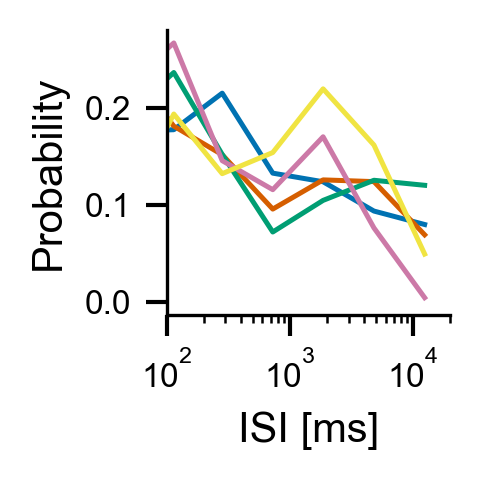

In [32]:
color_map =  {
    'PV_106': '#0072B2',
    'PV_126': '#D55E00',
    'PV_143': '#009E73',
    'PV_57': '#CC79A7',
    'PV_62': '#F0E442'}
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\Inter_saccade_intervals_histogram'
out = export_inter_saccade_intervals_density_traces_from_blocks(
    block_collection,
    figure_size=(1.7, 1.7),
    export_path=None,
    plot_name='ISI_histogram.pdf',
    first_bin_factor=0,
    color_map=color_map,
    xlim=(100,20000),
    add_leading_zero_bin=False,
    num_bins=25
    )

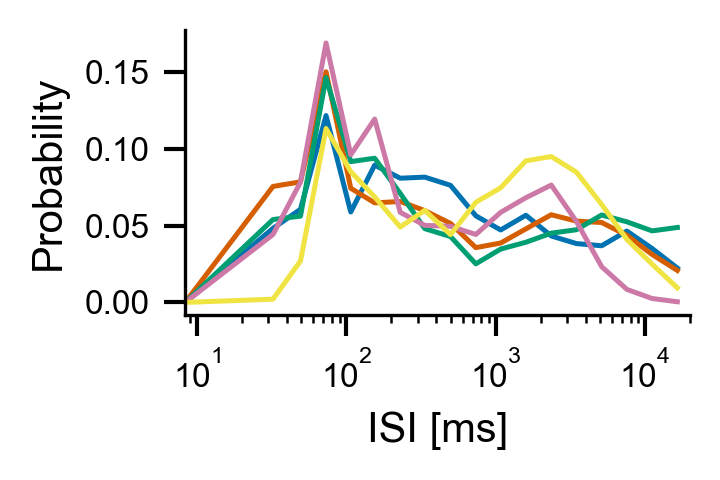

In [33]:
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\Inter_saccade_intervals_histogram'
out = export_inter_saccade_intervals_density_traces_from_blocks(
    block_collection,
    figure_size=(2.5, 1.7),
    export_path=None,
    num_bins=20,
    high_ms=20000,
    add_leading_zero_bin=True,   # keep this
    first_bin_factor=0.5         # keeps first real edge at 0.5×Δt
)


# create two plots - one log scale for higher start threshold (so the peak at 100ms is gone), another lin scale for lower ISI values (which will not be inflated).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def plot_saccade_periodogram_from_out(out,
                                      fs_hz=1000,
                                      fmax_hz=20.0,
                                      nperseg=None,
                                      detrend='constant',
                                      logy=True,
                                      figure_size=(2.5, 1.7),
                                      color_template="okabeito",
                                      custom_colors=None,
                                      log_bin_x=True,
                                      num_log_bins=40,
                                      agg_func='median'):
    """
    Build a binary event train per block, estimate PSD with Welch per block,
    average PSDs across blocks per animal, and (optionally) re-bin frequencies
    into logarithmically spaced bins.

    Parameters
    ----------
    out : dict
        Must include 'dedup_events' DataFrame with ['animal','block','event_time_ms'].
    log_bin_x : bool
        If True, compress frequency axis into logarithmic bins.
    num_log_bins : int
        Number of bins to use on the log frequency axis.
    agg_func : str
        'mean' or 'median' across Welch frequencies falling into the same bin.
    """
    dedup = out['dedup_events']
    animals = sorted(dedup['animal'].dropna().unique())

    # --- build colormap (fallback if missing) ---
    cmap = out.get('color_map', None)
    if cmap is None:
        COLOR_TEMPLATES = {
            "okabeito": ["#0072B2", "#D55E00", "#009E73", "#CC79A7",
                         "#F0E442", "#56B4E9", "#E69F00", "#000000"],
            "tableau10": [plt.get_cmap("tab10")(i) for i in range(10)],
        }
        base = list(custom_colors) if custom_colors is not None else COLOR_TEMPLATES[color_template]
        cmap = {lab: base[i % len(base)] for i, lab in enumerate(animals)}

    per_animal_psd = {}
    f_ref = None

    for animal in animals:
        block_psds = []
        for block_id, g_block in dedup[dedup['animal'] == animal].groupby('block', dropna=False):
            t_ms = np.asarray(g_block['event_time_ms'], dtype=float)
            if t_ms.size < 2: continue

            t0 = np.nanmin(t_ms)
            tt = t_ms - t0
            n_samples = int(np.ceil(tt.max() * fs_hz / 1000.0)) + 1
            if n_samples < int(2*fs_hz): continue

            idx = np.unique(np.clip(np.round(tt * fs_hz / 1000.0).astype(int), 0, n_samples-1))
            x = np.zeros(n_samples, dtype=np.float32); x[idx] = 1.0

            use_nperseg = int(nperseg) if nperseg else min(n_samples, int(8*fs_hz))
            use_nperseg = min(use_nperseg, n_samples)

            f, Pxx = signal.welch(x, fs=fs_hz, nperseg=use_nperseg,
                                  noverlap=use_nperseg//2, detrend=detrend)

            if f_ref is None:
                f_ref = f
            block_psds.append(Pxx)

        if block_psds:
            per_animal_psd[animal] = np.mean(np.vstack(block_psds), axis=0)

    if not per_animal_psd:
        raise ValueError("No PSDs computed.")

    # --- log re-binning of frequency axis ---
    if log_bin_x:
        fmin = np.min(f_ref[1:])  # skip DC
        fmax = fmax_hz
        log_edges = np.geomspace(fmin, fmax, num_log_bins+1)
        f_bins = np.sqrt(log_edges[:-1] * log_edges[1:])  # geometric centers

        per_animal_binned = {}
        for animal, Pxx in per_animal_psd.items():
            binned = []
            for i in range(len(log_edges)-1):
                mask = (f_ref >= log_edges[i]) & (f_ref < log_edges[i+1])
                if not np.any(mask):
                    binned.append(np.nan)
                else:
                    vals = Pxx[mask]
                    if agg_func == 'median':
                        binned.append(np.median(vals))
                    else:
                        binned.append(np.mean(vals))
            per_animal_binned[animal] = np.array(binned)
        f_plot = f_bins
        psd_to_plot = per_animal_binned
    else:
        f_plot = f_ref
        psd_to_plot = per_animal_psd

    # --- plot ---
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)
    for animal, Pxx in psd_to_plot.items():
        if logy:
            ax.semilogy(f_plot, Pxx, lw=1.2, color=cmap[animal], label=str(animal))
        else:
            ax.plot(f_plot, Pxx, lw=1.2, color=cmap[animal], label=str(animal))

    ax.set_xscale('log' if log_bin_x else 'linear')
    ax.set_xlim(f_plot[0], fmax_hz)
    ax.set_xlabel("Frequency [Hz]", fontsize=10)
    ax.set_ylabel("Power spectral density", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8, length=5, width=1, direction='out')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    #ax.legend(frameon=False, fontsize=8, ncol=1)
    plt.tight_layout(); plt.show()

    return {'f': f_plot, 'Pxx': psd_to_plot, 'fs_hz': fs_hz, 'color_map': cmap}
plot_saccade_periodogram_from_out(out,log_bin_x=False)

#This is not optimal, make a binary series of saccade events - within it the periodogram will tell me which frequencies are constructing the signal - this could help with te


Early-bin coverage relative to frame grid (k·Δt):
   bin_idx   left_ms   right_ms  width_ms  \
0        0     8.325     58.275     49.95   
1        1    58.275    174.825    116.55   
2        2   174.825    574.425    399.60   
3        3   574.425   1873.125   1298.70   
4        4  1873.125   6102.225   4229.10   
5        5  6102.225  20004.975  13902.75   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             k_values_in_bin  \
0                                                                                                                        

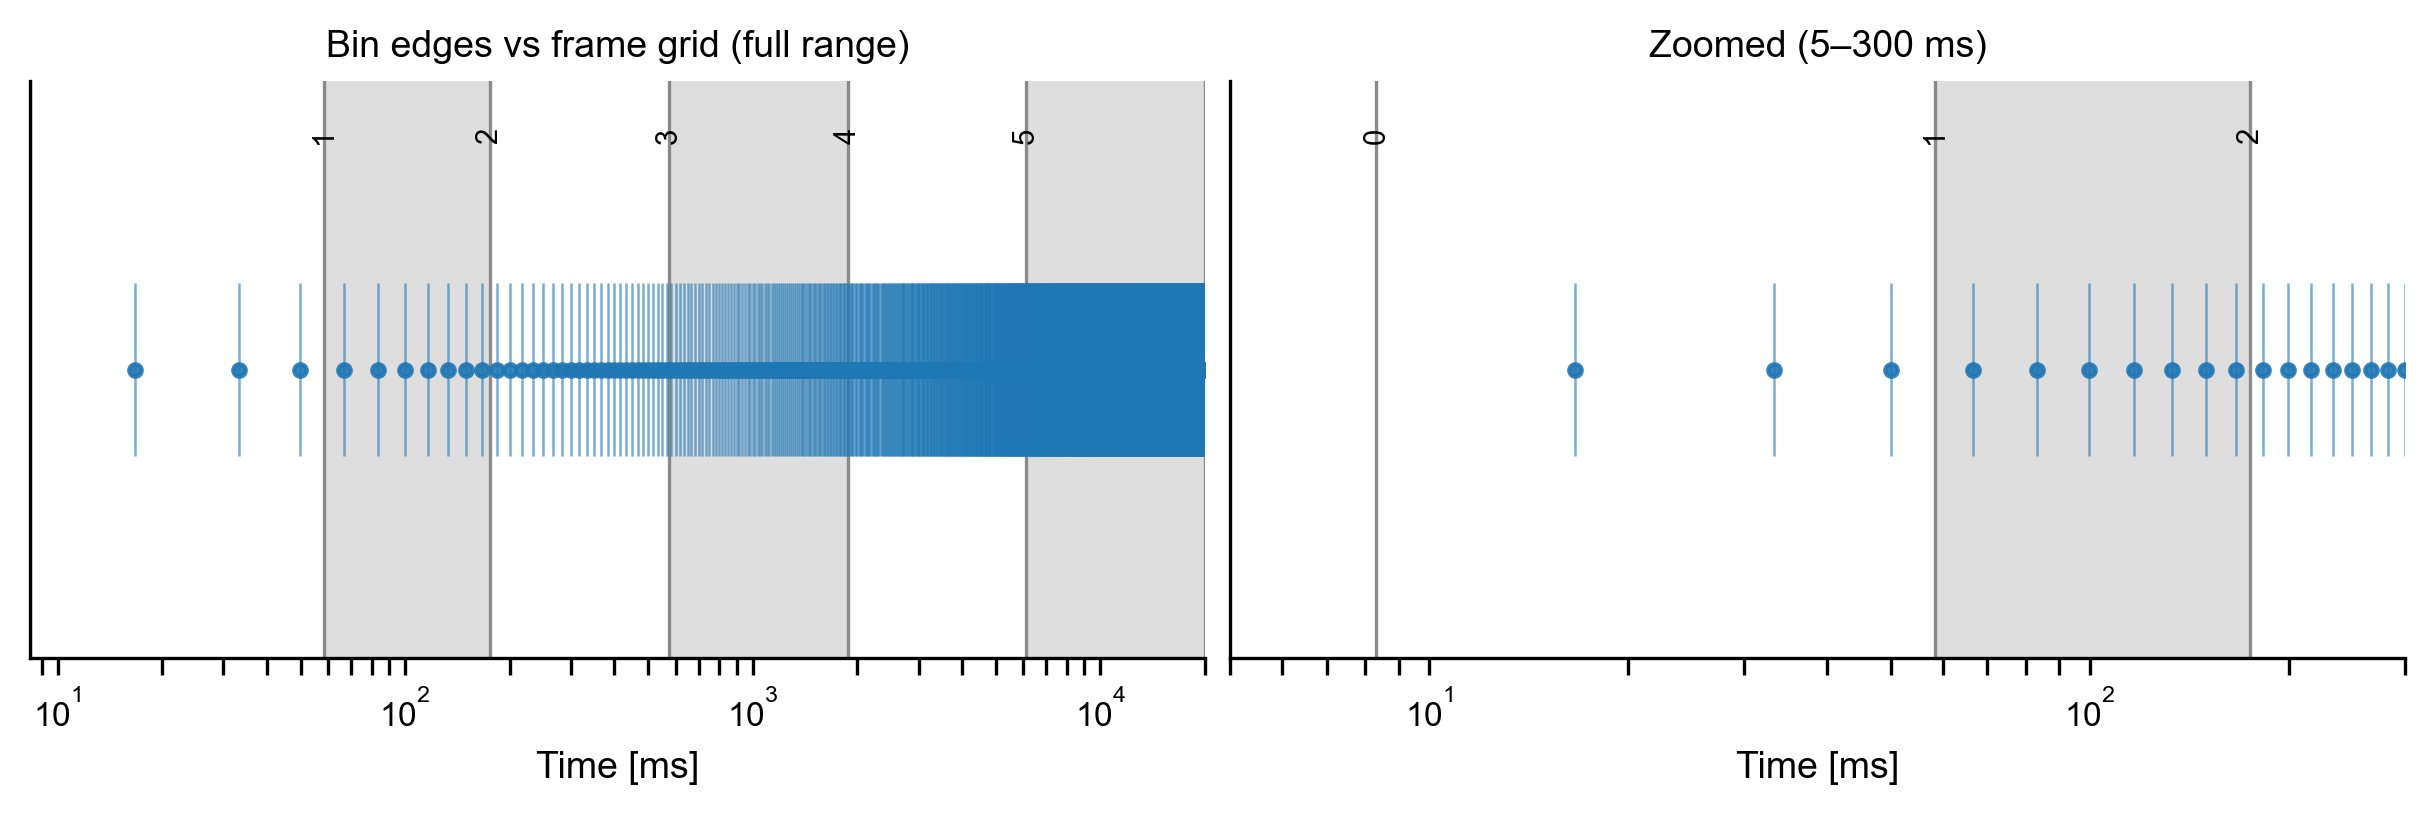

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_bin_edges_vs_framegrid(out,
                                k_show_max=None,           # e.g., 40 (defaults to cover your last bin)
                                zoom_low_ms=5, zoom_high_ms=300,   # low-range zoom for readability
                                annotate_bins=True,
                                show_table_first_n=12):     # how many bins to list in the printed table
    """
    Visualize snapped histogram edges relative to the frame quantization grid (k * frame_ms).

    Parameters
    ----------
    out : dict
        The return dict from export_inter_saccade_intervals_density_traces_from_blocks(...).
        Must contain keys: 'bins' (array of edges, ms) and 'frame_ms' (float).
    k_show_max : int or None
        Highest integer k to plot as grid markers (k * frame_ms). If None, inferred from bins.
    zoom_low_ms, zoom_high_ms : float
        X-limits for a zoomed low-ISI panel (ms).
    annotate_bins : bool
        If True, labels the first few bins with their index.
    show_table_first_n : int
        Prints a table for the first N bins with their [low, high) and the integer k values inside.

    Returns
    -------
    table_df : pd.DataFrame
        A dataframe summarizing the first `show_table_first_n` bins and their covered k’s.
    """
    bins = np.asarray(out['bins'], dtype=float)
    frame_ms = float(out['frame_ms'])
    if bins.ndim != 1 or bins.size < 2:
        raise ValueError("`out['bins']` must be a 1D array of bin edges (len >= 2).")

    # Decide how many k grid points to draw
    if k_show_max is None:
        k_show_max = int(np.floor(bins[-1] / frame_ms))

    # Build figure: full range + zoom
    fig, axes = plt.subplots(1, 2, figsize=(8.0, 2.6), dpi=300, constrained_layout=True, sharey=True)
    ax_full, ax_zoom = axes

    for ax, (xmin, xmax) in zip(
        (ax_full, ax_zoom),
        ((bins[0], bins[-1]), (zoom_low_ms, zoom_high_ms))
    ):
        # Log x-axis for both panels
        ax.set_xscale('log')
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(0, 1)  # dummy y, we’re just showing guides

        # Alternating shaded bins for readability
        for i in range(len(bins) - 1):
            left, right = bins[i], bins[i + 1]
            ax.axvspan(left, right, color='white' if i % 2 == 0 else '0.15', alpha=0.15, lw=0)

        # Bin edges as vertical lines
        for i, x in enumerate(bins):
            ax.axvline(x, color='0.5', lw=0.8, alpha=0.9)
            if annotate_bins:
                # Only annotate if the text will fall within the x-limits
                if x > xmin and x < xmax:
                    ax.text(x, 0.92, f"{i}", rotation=90, va='top', ha='center', fontsize=7)

        # k·Δt grid markers
        k_vals = np.arange(1, k_show_max + 1)
        grid_ms = k_vals * frame_ms
        in_range = (grid_ms >= xmin) & (grid_ms <= xmax)
        ax.plot(grid_ms[in_range], np.full(in_range.sum(), 0.5), 'o', ms=3, alpha=0.9, label='k·Δt')
        # thin helper stems to x-axis for visual alignment
        for xk in grid_ms[in_range]:
            ax.vlines(xk, 0.35, 0.65, color='C0', lw=0.6, alpha=0.6)

        ax.set_xlabel('Time [ms]', fontsize=9)
        ax.tick_params(axis='both', which='both', labelsize=8, length=4, width=0.8, direction='out')
        ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
        ax.set_yticks([])

    ax_full.set_title('Bin edges vs frame grid (full range)', fontsize=9)
    ax_zoom.set_title(f'Zoomed ({zoom_low_ms:g}–{zoom_high_ms:g} ms)', fontsize=9)

    # ---- Build a small table for the first N bins: which integer k land inside [edge_i, edge_{i+1})
    def ks_in_bin(left, right, frame_ms):
        # k is inside if k*Δt ∈ [left, right)
        k_min = int(np.ceil(left / frame_ms))
        k_max = int(np.floor((np.nextafter(right, -np.inf)) / frame_ms))
        if k_max < k_min:
            return []
        return list(range(k_min, k_max + 1))

    rows = []
    N = min(show_table_first_n, len(bins) - 1)
    for i in range(N):
        left, right = bins[i], bins[i + 1]
        ks = ks_in_bin(left, right, frame_ms)
        rows.append({
            'bin_idx': i,
            'left_ms': left,
            'right_ms': right,
            'width_ms': right - left,
            'k_values_in_bin': ks,
            'num_k': len(ks)
        })

    table_df = pd.DataFrame(rows)
    # Pretty print
    with pd.option_context('display.max_colwidth', None, 'display.precision', 3):
        print("\nEarly-bin coverage relative to frame grid (k·Δt):")
        print(table_df)

    plt.show()
    return table_df
# Now visualize bin edges vs the 60 Hz grid
_ = plot_bin_edges_vs_framegrid(out,
                                k_show_max=None,         # auto from last edge
                                zoom_low_ms=5,
                                zoom_high_ms=300,
                                annotate_bins=True,
                                show_table_first_n=14)

In [ ]:
# for this - send the ISI vector to Mark for a check ^^

In [ ]:
# Single cell: robust HMM fitting over saccade_collection with Main/Sub pairing and required features
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM

def fit_hmm_on_saccade_collection(
    saccade_collection,
    n_states=3,
    pair_threshold_ms=25.0,
    # prefer pixel magnitude if present; fallbacks handled automatically
    magnitude_preference=("magnitude_pixel", "magnitude_raw_pixel", "magnitude_raw_angular",
                          "net_angular_disp", "overall_disp", "overall_angle_deg", "length"),
    # columns expected in the input; these are auto-detected if missing
    time_col_candidates=("saccade_on_ms", "event_time_ms", "saccade_start_ms", "saccade_start_timestamp"),
    head_flag_col_candidates=("head_movement", "head_motion", "head_move"),
    eye_col_candidates=("eye", "Eye", "EYE"),
    animal_col_candidates=("animal", "Animal", "subject"),
    block_col_candidates=("block", "Block", "block_num"),
    random_state=0,
    max_iter=100
):
    """
    saccade_collection : pd.DataFrame or list-like of DataFrames
        Each row is a saccade event. Must include at least:
        - Main/Sub pairing columns ('Main','Sub') to group L/R events of the same saccade
        - Animal and block identifiers (auto-detected)
        - At least one magnitude column (auto-detected)
        - A time column in ms if available (auto-detected)

    Returns
    -------
    model : GaussianHMM
    events_with_states : pd.DataFrame  # per-collapsed-event features + state
    feature_names : list[str]
    scaler : StandardScaler
    """

    # ---------- 1) Normalize input to a single DataFrame ----------
    if isinstance(saccade_collection, list):
        df = pd.concat([x.copy() for x in saccade_collection], ignore_index=True)
    elif isinstance(saccade_collection, pd.DataFrame):
        df = saccade_collection.copy()
    else:
        raise TypeError("saccade_collection must be a DataFrame or a list of DataFrames.")

    # Be safe about column names (strip spaces)
    df.columns = [str(c).strip() for c in df.columns]

    # ---------- 2) Auto-detect critical columns ----------
    def first_present(cands):
        for c in cands:
            if c in df.columns:
                return c
        return None

    time_col = first_present(time_col_candidates)
    if time_col is None:
        raise ValueError(f"No acceptable time column found. Tried: {time_col_candidates}")

    eye_col = first_present(eye_col_candidates)
    if eye_col is None:
        # If truly missing, treat everything as one eye (monocular)
        eye_col = "__synthetic_eye"
        df[eye_col] = "unknown"

    head_col = first_present(head_flag_col_candidates)
    # make a safe boolean column for head movement
    if head_col is None:
        df["__head_flag__"] = False
        head_col = "__head_flag__"
    else:
        # robust coercion to bool avoiding NaN->int issues
        df["__head_flag__"] = pd.to_numeric(df[head_col], errors="coerce").fillna(0.0) != 0.0
        head_col = "__head_flag__"

    animal_col = first_present(animal_col_candidates)
    if animal_col is None:
        animal_col = "__animal__"
        df[animal_col] = "animal"

    block_col = first_present(block_col_candidates)
    if block_col is None:
        block_col = "__block__"
        df[block_col] = "block"

    # Pick magnitude column
    mag_col = None
    for c in magnitude_preference:
        if c in df.columns:
            mag_col = c
            break
    if mag_col is None:
        raise ValueError(f"Could not find a magnitude-like column. Tried: {magnitude_preference}")

    # Try to ensure time is numeric (ms if you have it; otherwise it can be any consistent unit)
    df[time_col] = pd.to_numeric(df[time_col], errors="coerce")
    # sort for ISI computation
    df.sort_values([animal_col, block_col, time_col], inplace=True)
    df.reset_index(drop=True, inplace=True)

    # ---------- 3) Collapse L/R pairs using Main/Sub if present ----------
    have_main_sub = ("Main" in df.columns) and ("Sub" in df.columns)

    def collapse_pairs_using_main_sub(g):
        """
        Within an (animal, block) chunk, group by Main (saccade id).
        Collapse multi-eye events into one row:
          - time = min time in group
          - magnitude = max magnitude in group (robust)
          - head_movement = any eye True
          - synced = True if >=2 unique eyes, else False
          - monocular/synchronized flag derived from synced
        For lone events (only one eye for that Main), they still appear once (monocular).
        """
        rows = []
        for main_id, gg in g.groupby("Main", dropna=False):
            # Skip NaN Main if it looks invalid and there’s no Sub as well: treat each row as its own main
            if pd.isna(main_id):
                for _, r in gg.iterrows():
                    rows.append({
                        animal_col: r[animal_col],
                        block_col: r[block_col],
                        "time_ms_like": r[time_col],
                        "magnitude": r.get(mag_col, np.nan),
                        "head_move": bool(r[head_col]),
                        "synced": False,  # no confirmed pairing
                        "n_eyes": 1
                    })
                continue

            t = np.nanmin(gg[time_col].values)
            mag = np.nanmax(gg[mag_col].values) if mag_col in gg.columns else np.nan
            head_any = bool(pd.Series(gg[head_col].values).fillna(False).any())
            n_eyes = gg[eye_col].nunique() if eye_col in gg.columns else 1
            synced = n_eyes >= 2
            rows.append({
                animal_col: gg[animal_col].iloc[0],
                block_col: gg[block_col].iloc[0],
                "time_ms_like": t,
                "magnitude": mag,
                "head_move": head_any,
                "synced": synced,
                "n_eyes": int(n_eyes)
            })
        return pd.DataFrame(rows)

    def collapse_pairs_by_nearest_lr(g, thr_ms=pair_threshold_ms):
        """
        Fallback: if Main/Sub are missing, pair nearest L/R within a threshold.
        Unpaired events become monocular.
        """
        g = g.sort_values(time_col).reset_index(drop=True)
        used = np.zeros(len(g), dtype=bool)
        rows = []
        for i, r in g.iterrows():
            if used[i]:
                continue
            t_i = r[time_col]
            eye_i = str(r[eye_col])
            # look for nearest opposite eye within thr
            opp = g[(~used) & (g.index != i) & (g[eye_col] != eye_i)]
            if not opp.empty:
                # nearest in time
                j = (opp[time_col] - t_i).abs().idxmin()
                dt = abs(opp.loc[j, time_col] - t_i)
                if pd.notna(dt) and dt <= thr_ms:
                    # make a pair
                    mag = np.nanmax([r.get(mag_col, np.nan), opp.loc[j, mag_col] if mag_col in opp.columns else np.nan])
                    head_any = bool(pd.Series([r[head_col], opp.loc[j, head_col]]).fillna(False).any())
                    rows.append({
                        animal_col: r[animal_col],
                        block_col: r[block_col],
                        "time_ms_like": min(t_i, opp.loc[j, time_col]),
                        "magnitude": mag,
                        "head_move": head_any,
                        "synced": True,
                        "n_eyes": 2
                    })
                    used[i] = True
                    used[j] = True
                    continue
            # otherwise monocular
            rows.append({
                animal_col: r[animal_col],
                block_col: r[block_col],
                "time_ms_like": t_i,
                "magnitude": r.get(mag_col, np.nan),
                "head_move": bool(r[head_col]),
                "synced": False,
                "n_eyes": 1
            })
            used[i] = True
        return pd.DataFrame(rows)

    collapsed_list = []
    for (ani, blk), g in df.groupby([animal_col, block_col], dropna=False):
        if have_main_sub:
            collapsed = collapse_pairs_using_main_sub(g)
        else:
            collapsed = collapse_pairs_by_nearest_lr(g)
        collapsed_list.append(collapsed)

    ev = pd.concat(collapsed_list, ignore_index=True)
    ev.sort_values(["time_ms_like", animal_col, block_col], inplace=True)
    ev.reset_index(drop=True, inplace=True)

    # ---------- 4) Compute ISI per (animal, block) ----------
    ev["ISI"] = np.nan
    for (ani, blk), g in ev.groupby([animal_col, block_col], dropna=False):
        idx = g.index
        t = g["time_ms_like"].values
        isi = np.diff(t, prepend=np.nan)
        ev.loc[idx, "ISI"] = isi

    # Some sessions might begin with NaN ISI → fill with median ISI of that (animal, block)
    def _fill_group_nan(series):
        if series.isna().all():
            return series.fillna(0.0)  # degenerate case
        return series.fillna(series.dropna().median())

    ev["ISI"] = ev.groupby([animal_col, block_col], dropna=False)["ISI"].transform(_fill_group_nan)

    # ---------- 5) Build feature matrix ----------
    # Binary features as 0/1 floats (no forced int conversion)
    ev["head_move_f"] = (ev["head_move"].fillna(False)).astype(float)
    ev["synced_f"] = (ev["synced"].fillna(False)).astype(float)

    # Magnitude may contain NaN → replace with group median, then global median
    if ev["magnitude"].isna().any():
        ev["magnitude"] = ev.groupby([animal_col, block_col], dropna=False)["magnitude"].transform(
            lambda s: s.fillna(s.median())
        )
        ev["magnitude"] = ev["magnitude"].fillna(ev["magnitude"].median())

    # Small epsilon to avoid zero-variance disasters
    eps = 1e-9
    X = ev[["ISI", "magnitude", "head_move_f", "synced_f"]].astype(float).values + eps
    feature_names = ["ISI", "magnitude", "head_move", "synced"]

    # ---------- 6) Scale and fit HMM ----------
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # hmmlearn expects a single sequence by default; here we treat the entire set as one sequence.
    model = GaussianHMM(
        n_components=n_states,
        covariance_type="full",
        n_iter=max_iter,
        random_state=random_state,
        verbose=False
    )
    model.fit(X_scaled)

    # ---------- 7) Decode most likely states ----------
    states = model.predict(X_scaled)
    ev_out = ev.copy()
    ev_out["state"] = states

    # Keep only the useful columns plus identifiers
    keep_cols = [animal_col, block_col, "time_ms_like", "ISI", "magnitude", "head_move", "synced", "state"]
    ev_out = ev_out[keep_cols].sort_values(["time_ms_like", animal_col, block_col]).reset_index(drop=True)

    return model, ev_out, feature_names, scaler


# Assuming you already have `all_saccade_collection` built as in your pipeline:
model, events_with_states, feat_names, scaler = fit_hmm_on_saccade_collection(
    all_saccade_collection,
    n_states=3,
    pair_threshold_ms=60.0
)

In [ ]:
from typing import Optional, Union, List, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional: only if you have sklearn; otherwise we'll fallback
try:
    from sklearn.metrics import confusion_matrix
    _HAS_SK = True
except Exception:
    _HAS_SK = False


def plot_hmm_saccade_summary(
    events_with_states: pd.DataFrame,
    time_col: str = "time_ms_like",
    state_col: str = "state",
    eye_col: Optional[str] = "eye",           # set to None if you don't have an eye column
    # Confusion matrix (optional)
    y_true: Optional[Union[np.ndarray, pd.Series]] = None,
    y_pred: Optional[Union[np.ndarray, pd.Series]] = None,
    true_labels: Optional[List[str]] = None,   # class order for CM rows
    pred_labels: Optional[List[str]] = None,   # class order for CM cols
    # Visual style
    state_names: Optional[Dict[int, str]] = None,  # map numeric->name for legend
    state_colors: Optional[Dict[int, str]] = None, # map state->color hex
    figure_height: float = 8.0,
    alpha_state_band: float = 0.15,
    raster_tick_height: float = 0.8,
):
    """
    events_with_states must contain at least [time_col, state_col].
    If eye_col is provided, it will create a 2-level raster (one row per eye label).
    If y_true & y_pred are provided, the confusion matrix is plotted (top panel).

    Typical usage:
      plot_hmm_saccade_summary(events_df, time_col='event_time_ms', state_col='state', eye_col='eye',
                               y_true=truth, y_pred=pred, state_names={0:'Fix',1:'Slow',2:'Fast'})
    """

    # ---- basic checks / prep ----
    df = events_with_states.copy()
    if time_col not in df.columns or state_col not in df.columns:
        raise ValueError(f"DataFrame must contain '{time_col}' and '{state_col}' columns.")

    # Ensure time is numeric
    df[time_col] = pd.to_numeric(df[time_col], errors="coerce")
    df = df.dropna(subset=[time_col, state_col]).sort_values(time_col)

    # Normalize state to int codes (keeps mapping if already int)
    if not np.issubdtype(df[state_col].dtype, np.integer):
        df["_state_code"], uniques = pd.factorize(df[state_col])
        code_to_label = dict(enumerate(uniques.tolist()))
    else:
        df["_state_code"] = df[state_col].astype(int)
        code_to_label = {int(s): str(s) for s in sorted(df["_state_code"].unique())}

    # Apply provided state_names if given
    if state_names is not None:
        code_to_label = {int(k): state_names.get(int(k), code_to_label.get(int(k), str(k)))
                         for k in code_to_label.keys()}

    state_list = sorted(code_to_label.keys())

    # Colors
    if state_colors is None:
        # Simple default palette
        default_palette = ["#4C78A8", "#F58518", "#54A24B", "#E45756", "#72B7B2", "#EECA3B"]
        state_colors = {s: default_palette[s % len(default_palette)] for s in state_list}
    else:
        # ensure all states have a color
        for s in state_list:
            state_colors.setdefault(s, "#999999")

    # Build state segments (start/stop in time for each contiguous state)
    t = df[time_col].to_numpy()
    s = df["_state_code"].to_numpy()

    # breakpoints where state changes
    change_idx = np.where(np.diff(s) != 0)[0] + 1
    starts = np.r_[0, change_idx]
    ends   = np.r_[change_idx, len(s)]

    state_bands = [(t[si], t[ei-1] if ei-1 >= si else t[si], int(s[si])) for si, ei in zip(starts, ends)]
    # If single sample segments, give minimal width
    eps = (t[-1] - t[0]) * 1e-4 if len(t) > 1 else 1.0

    # ---- figure layout ----
    has_cm = (y_true is not None) and (y_pred is not None)
    nrows = 3 if has_cm else 2
    fig, axs = plt.subplots(nrows, 1, figsize=(12, figure_height), sharex=False,
                            gridspec_kw={"height_ratios": [1.2, 1.0, 1.3] if has_cm else [1.0, 1.3]})
    if nrows == 2:
        ax_cm = None
        ax_state, ax_raster = axs[0], axs[1]
    else:
        ax_cm, ax_state, ax_raster = axs[0], axs[1], axs[2]

    # ---- (1) Confusion matrix (optional) ----
    if has_cm:
        y_true = np.asarray(y_true).ravel()
        y_pred = np.asarray(y_pred).ravel()
        if _HAS_SK:
            # Labels / order
            if true_labels is None:
                true_labels = sorted(np.unique(y_true).tolist())
            if pred_labels is None:
                pred_labels = sorted(np.unique(y_pred).tolist())
            cm = confusion_matrix(y_true, y_pred, labels=pred_labels)
            im = ax_cm.imshow(cm, aspect="auto", cmap="Blues")
            ax_cm.set_title("Confusion Matrix")
            ax_cm.set_xlabel("Predicted")
            ax_cm.set_ylabel("True")
            ax_cm.set_xticks(range(len(pred_labels)))
            ax_cm.set_xticklabels([state_names.get(l, str(l)) if state_names else str(l) for l in pred_labels],
                                  rotation=45, ha="right")
            ax_cm.set_yticks(range(len(true_labels)))
            ax_cm.set_yticklabels([state_names.get(l, str(l)) if state_names else str(l) for l in true_labels])
            # annotate cells
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    ax_cm.text(j, i, str(cm[i, j]), ha="center", va="center", fontsize=9)
            fig.colorbar(im, ax=ax_cm, fraction=0.046, pad=0.04)
        else:
            ax_cm.text(0.5, 0.5, "Install scikit‑learn for confusion matrix\npip install scikit-learn",
                       ha="center", va="center", fontsize=11)
            ax_cm.axis("off")

    # ---- (2) State sequence over time (colored spans) ----
    ax_state.set_title("State sequence over time")
    ax_state.set_ylabel("State")
    # colored blocks
    for t0, t1, st in state_bands:
        if t1 <= t0:
            t1 = t0 + eps
        ax_state.axvspan(t0, t1, color=state_colors[st], alpha=alpha_state_band, lw=0)
    # a thin line of state code vs time (to see edges)
    ax_state.step(t, s, where="post", color="#333333", lw=1)
    # nice y ticks with labels
    ax_state.set_yticks(state_list)
    ax_state.set_yticklabels([code_to_label[k] for k in state_list])

    # ---- (3) Saccade raster with state overlay ----
    ax_raster.set_title("Saccade raster (per eye) with state overlay")
    ax_raster.set_xlabel("Time (ms)")
    if eye_col is not None and eye_col in df.columns:
        eye_levels = df[eye_col].astype(str).unique().tolist()
        eye_levels.sort()
        eye_to_row = {e: i for i, e in enumerate(eye_levels)}
        # overlay state bands again for context
        for t0, t1, st in state_bands:
            if t1 <= t0:
                t1 = t0 + eps
            ax_raster.axvspan(t0, t1, color=state_colors[st], alpha=alpha_state_band, lw=0)

        # draw ticks
        for e in eye_levels:
            row = eye_to_row[e]
            times = df.loc[df[eye_col].astype(str) == e, time_col].to_numpy()
            if times.size:
                ax_raster.vlines(times, row - raster_tick_height/2, row + raster_tick_height/2, lw=1)
        ax_raster.set_yticks(list(eye_to_row.values()))
        ax_raster.set_yticklabels(eye_levels)
    else:
        # single-row raster if no eye column
        times = df[time_col].to_numpy()
        for t_i in times:
            ax_raster.vlines(t_i, 0.5 - raster_tick_height/2, 0.5 + raster_tick_height/2, lw=1)
        # overlay bands
        for t0, t1, st in state_bands:
            if t1 <= t0:
                t1 = t0 + eps
            ax_raster.axvspan(t0, t1, color=state_colors[st], alpha=alpha_state_band, lw=0)
        ax_raster.set_yticks([0.5])
        ax_raster.set_yticklabels(["events"])

    # Legend for states
    handles = [plt.Line2D([0], [0], color=state_colors[s], lw=6, label=code_to_label[s]) for s in state_list]
    ax_state.legend(handles=handles, loc="upper right", frameon=False, ncol=min(3, len(handles)))

    fig.tight_layout()
    return fig, (ax_cm, ax_state, ax_raster) if has_cm else (None, ax_state, ax_raster)


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def print_and_plot_hmm_transitions(model, state_labels=None, cmap="Blues"):
    """
    Print and plot the HMM state transition probabilities.

    Parameters
    ----------
    model : fitted hmmlearn model
        Must have .transmat_ attribute.
    state_labels : list of str or None
        Labels to use for states (defaults to "S0", "S1", ...).
    cmap : str
        Matplotlib colormap for heatmap.
    """
    n_states = model.transmat_.shape[0]
    if state_labels is None:
        state_labels = [f"S{i}" for i in range(n_states)]

    # Put into DataFrame
    trans_df = pd.DataFrame(model.transmat_,
                            index=[f"from {s}" for s in state_labels],
                            columns=[f"to {s}" for s in state_labels])

    print("Transition probability matrix:")
    display(trans_df.round(3))

    # Plot heatmap
    plt.figure(figsize=(3 + n_states * 0.4, 2.5 + n_states * 0.4), dpi=150)
    sns.heatmap(trans_df, annot=True, fmt=".2f", cmap=cmap, cbar=True,
                linewidths=0.5, linecolor="gray")
    plt.title("HMM Transition Probabilities")
    plt.tight_layout()
    plt.show()

    return trans_df


# Example usage after fitting your HMM:
transitions = print_and_plot_hmm_transitions(model)


In [ ]:
summary = events_with_states.groupby("state").agg({
    "ISI": ["median", "mean"],
    "magnitude": ["median", "mean"],
    "head_move": "mean",
    "synced": "mean",
    "time_ms_like": "count"
})
summary


In [ ]:
# events_with_states must have "event_time_ms" and "state"
# Minimal (no confusion matrix):
fig, axes = plot_hmm_saccade_summary(
    events_with_states,               # your DF
    time_col="time_ms_like",         # or whatever you use
    state_col="state",
    eye_col="eye",                    # or None if not present
    state_names={0:"fix", 1:"slow", 2:"fast"}  # optional
)


In [ ]:
events_with_states

In [ ]:
# This is for 2 deg/frame (~120 deg/sec speed thr)
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\Inter_saccade_intervals_histogram'
out = export_inter_saccade_intervals_density_traces_from_blocks(
    block_collection,
    num_bins=30,
    figure_size=(2.5, 1.7),
    export_path=None,
    plot_name='ISI_histogram.pdf')

In [ ]:
# This is for 1 deg/frame (~60 deg/sec speed thr)
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\Inter_saccade_intervals_histogram'
out = export_inter_saccade_intervals_density_traces_from_blocks(
    block_collection,
    num_bins=20,
    figure_size=(2.5, 1.7),
    export_path=None,
    plot_name='ISI_histogram.pdf')

In [ ]:
# === ISI traces (log-x) with x-only minor spikes, realizable bins, and a left-edge zero anchor ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullFormatter, NullLocator
from pathlib import Path
import datetime as _dt

# ---------- helpers ----------
def _collect_events_from_blocks(block_collection):
    rows = []
    for b in block_collection:
        animal = getattr(b, 'animal_call', None)
        blockn = getattr(b, 'block_num', None)
        for eye, sdf in (('L', getattr(b, 'l_saccade_df', None)),
                         ('R', getattr(b, 'r_saccade_df', None))):
            if sdf is None or len(sdf) == 0:
                continue
            s_on = pd.to_numeric(sdf.get('saccade_on_ms', pd.Series([], dtype='float64')), errors='coerce')
            hm = sdf['head_movement'] if 'head_movement' in sdf.columns else pd.Series(False, index=sdf.index)
            rows.append(pd.DataFrame({
                'animal': animal, 'block': blockn, 'eye': eye,
                'saccade_on_ms': s_on, 'head_movement': hm.astype(bool)
            }).dropna(subset=['saccade_on_ms']))
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(
        columns=['animal','block','eye','saccade_on_ms','head_movement'])

def _estimate_frame_interval_ms(block_collection, fallback_ms=16.67):
    dts = []
    for b in block_collection:
        for df in [getattr(b, 'left_eye_data', None), getattr(b, 'right_eye_data', None)]:
            if df is None or 'ms_axis' not in df.columns: continue
            ms = pd.to_numeric(df['ms_axis'], errors='coerce').dropna().to_numpy()
            if ms.size > 3:
                dt = np.diff(ms); dt = dt[(dt > 0) & np.isfinite(dt)]
                if dt.size: dts.append(np.median(dt))
    return float(np.median(dts)) if dts else float(fallback_ms)

def _dedupe_lr_pairs(events_df, pair_threshold_ms=60.0):
    """Greedy L/R pairing per (animal,block); unmatched events pass through."""
    out = []
    for (animal, block), g in events_df.groupby(['animal','block'], dropna=False):
        L = g[g['eye']=='L'].sort_values('saccade_on_ms')
        R = g[g['eye']=='R'].sort_values('saccade_on_ms')
        lt, rt = L['saccade_on_ms'].to_numpy(float), R['saccade_on_ms'].to_numpy(float)
        lhm = L['head_movement'].to_numpy(bool) if len(L) else np.array([], bool)
        rhm = R['head_movement'].to_numpy(bool) if len(R) else np.array([], bool)
        i=j=0; ev_t=[]; ev_hm=[]
        while i<len(lt) and j<len(rt):
            dt = lt[i]-rt[j]
            if abs(dt) <= pair_threshold_ms:
                ev_t.append(min(lt[i], rt[j])); ev_hm.append(bool(lhm[i] or rhm[j])); i+=1; j+=1
            elif lt[i] < rt[j] - pair_threshold_ms:
                ev_t.append(lt[i]); ev_hm.append(bool(lhm[i])); i+=1
            else:
                ev_t.append(rt[j]); ev_hm.append(bool(rhm[j])); j+=1
        while i<len(lt): ev_t.append(lt[i]); ev_hm.append(bool(lhm[i])); i+=1
        while j<len(rt): ev_t.append(rt[j]); ev_hm.append(bool(rhm[j])); j+=1
        out.append(pd.DataFrame({'animal':animal,'block':block,'event_time_ms':ev_t,'head_movement':ev_hm}))
    return pd.concat(out, ignore_index=True) if out else pd.DataFrame(
        columns=['animal','block','event_time_ms','head_movement'])

def _compute_blockwise_isis(dedup_df, min_isi_ms):
    isi_all = {}
    for (animal, block), g in dedup_df.groupby(['animal','block'], dropna=False):
        t = np.sort(g['event_time_ms'].to_numpy())
        if t.size > 1:
            d = np.diff(t); d = d[np.isfinite(d) & (d >= min_isi_ms)]
            if d.size: isi_all.setdefault(animal, []).append(d)
    return {a: (np.concatenate(v) if v else np.array([], float)) for a, v in isi_all.items()}

def _snapped_log_bins(num_bins, frame_ms, low_ms, high_ms, add_leading_zero_bin=True):
    """
    Log edges snapped to (k+0.5)*Δt so each bin spans ≥1 feasible ISI (k*Δt).
    Optional leading dummy bin [0.25Δt, 0.5Δt] (zero by construction).
    """
    raw = np.geomspace(low_ms, high_ms, int(num_bins)+1)
    k_edges = np.floor(raw/frame_ms) + 0.5
    kmax = int(np.floor(high_ms/frame_ms))
    k_edges = np.clip(k_edges, 0.5, kmax+0.5)
    k_edges = np.unique(k_edges)
    if add_leading_zero_bin and (k_edges.size == 0 or not np.isclose(k_edges[0], 0.5)):
        k_edges = np.r_[0.25, k_edges]  # dummy bin (center not used)
    if k_edges[-1] < (kmax+0.5):
        k_edges = np.r_[k_edges, (kmax+0.5)]
    return k_edges * frame_ms

# ---------- plotting ----------
def export_inter_saccade_intervals_density_traces_from_blocks(
    block_collection,
    figure_size=(1.8, 1.2),
    export_path=None,
    plot_name='ISI_histogram.pdf',
    num_bins=25,
    high_ms=20000.0,
    pair_threshold_ms=60.0,
    min_isi_ms=None,          # if None -> 0.75 * frame_ms
    first_bin_factor=0.5,     # first “real” edge = 0.5×Δt
    add_leading_zero_bin=True,
    font_family='Arial'
):
    # Build and dedupe
    events = _collect_events_from_blocks(block_collection)
    if events.empty:
        raise ValueError("No saccade events found.")
    dedup = _dedupe_lr_pairs(events, pair_threshold_ms=pair_threshold_ms)

    # Frame interval + ISIs
    frame_ms = _estimate_frame_interval_ms(block_collection)
    min_isi_eff = (0.75 * frame_ms) if (min_isi_ms is None) else float(min_isi_ms)
    isi_all = _compute_blockwise_isis(dedup, min_isi_ms=min_isi_eff)
    animals = sorted(dedup['animal'].dropna().unique())

    # Bins
    low_ms = max(1e-6, first_bin_factor * frame_ms)
    bins = _snapped_log_bins(num_bins=num_bins, frame_ms=frame_ms,
                             low_ms=low_ms, high_ms=float(high_ms),
                             add_leading_zero_bin=add_leading_zero_bin)
    bin_centers = np.sqrt(bins[:-1] * bins[1:])

    # Style
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = [font_family]
    OI = ['#0072B2','#D55E00','#009E73','#CC79A7','#F0E442','#56B4E9','#E69F00','#000000']

    fig, ax = plt.subplots(figsize=figure_size, dpi=300)
    legend_handles, legend_labels = [], []

    for i, a in enumerate(animals):
        isi = isi_all.get(a, np.array([]))
        if isi.size == 0:
            continue
        hist, _ = np.histogram(isi, bins=bins)
        dens = hist / hist.sum() if hist.sum() > 0 else hist

        # draw a left-edge zero, then jump to first *real* bin center
        if add_leading_zero_bin:
            x_plot = np.r_[bins[0], bin_centers[1:]]
            y_plot = np.r_[0.0, dens[1:]]
        else:
            x_plot = bin_centers
            y_plot = dens

        h, = ax.plot(x_plot, y_plot, linewidth=1.2, color=OI[i % len(OI)], label=str(a))
        legend_handles.append(h); legend_labels.append(str(a))

    # Axes + ticks: x-only minor “spikes”
    ax.set_xscale('log')
    ax.set_xlim(bins[0], bins[-1])
    ax.set_xlabel('ISI [ms]', fontsize=10)
    ax.set_ylabel('Probability', fontsize=10)

    # Major ticks
    ax.tick_params(axis='both', which='major', labelsize=8, length=5, width=1, direction='out')
    # X minor ticks (spikes), Y minor ticks OFF
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2,10)*0.1))
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.tick_params(axis='x', which='minor', length=3, width=0.8, direction='out', bottom=True, top=False)
    ax.yaxis.set_minor_locator(NullLocator())  # ensure no y-minor spikes

    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    plt.grid(False)
    plt.tight_layout()

    out = {'dedup_events': dedup, 'isi_all': isi_all, 'frame_ms': frame_ms, 'bins': bins}

    # Export: main plot (no legend) + legend as separate figure (so size is unaffected)
    if export_path is not None:
        ts = _dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        outdir = Path(export_path) / f"inter_saccade_export_{ts}"
        outdir.mkdir(parents=True, exist_ok=True)

        fig.savefig(outdir / plot_name, format='pdf', bbox_inches='tight', dpi=300)

        if legend_handles:
            fig_leg = plt.figure(figsize=(2.2, 0.28*max(1,len(legend_labels)) + 0.4), dpi=300)
            fig_leg.legend(legend_handles, legend_labels, loc='center', frameon=False, ncol=1, prop={'size': 8})
            fig_leg.savefig(outdir / ('legend_' + plot_name), format='pdf', bbox_inches='tight', dpi=300)
            plt.close(fig_leg)

        with open(outdir / "binning_info.txt", 'w') as f:
            f.write(f"Frame interval (ms): {frame_ms:.3f}\n")
            f.write(f"First edge (ms): {bins[0]:.3f}\n")
            f.write(f"Min ISI enforced (ms): {min_isi_eff:.3f}\n")
            f.write(f"Pair L/R threshold (ms): {pair_threshold_ms:.3f}\n")
            f.write(f"Leading zero anchor: {add_leading_zero_bin}\n")
        print("Exported plot + separate legend to:", outdir)

    plt.show()
    return out


In [ ]:
export_path

In [ ]:
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs

export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\Inter_saccade_intervals_histogram'
out = export_inter_saccade_intervals_density_traces_from_blocks(
    block_collection,
    figure_size=(2.5, 1.7),
    export_path=None,
    plot_name='ISI_histogram.pdf'
)

In [ ]:
def compute_most_common_isi(block_collection,
                            num_bins=50,
                            high_ms=20000.0,
                            pair_threshold_ms=60.0,
                            min_isi_ms=None,
                            first_bin_factor=0.5):
    """
    Compute the most common inter-saccadic interval (ISI) pooled across all animals.

    Args:
        block_collection: list of BlockSync objects
        num_bins (int): number of log-spaced bins
        high_ms (float): upper edge for ISIs [ms]
        pair_threshold_ms (float): threshold for L/R pairing
        min_isi_ms (float or None): minimum ISI to keep; if None use 0.75*frame_ms
        first_bin_factor (float): lowest edge = factor*frame_ms

    Returns:
        most_common_isi (float): ISI bin center with maximum probability
        hist (np.ndarray): normalized pooled histogram
        bin_centers (np.ndarray): corresponding bin centers [ms]
    """
    # Collect + dedupe events
    events = _collect_events_from_blocks(block_collection)
    if events.empty:
        raise ValueError("No saccade events found.")
    dedup = _dedupe_lr_pairs(events, pair_threshold_ms=pair_threshold_ms)

    # Estimate frame interval and ISIs
    frame_ms = _estimate_frame_interval_ms(block_collection)
    min_isi_eff = (0.75 * frame_ms) if (min_isi_ms is None) else float(min_isi_ms)
    isi_all = _compute_blockwise_isis(dedup, min_isi_ms=min_isi_eff)

    # Pool across animals
    pooled_isi = np.concatenate(list(isi_all.values())) if isi_all else np.array([], float)
    if pooled_isi.size == 0:
        raise ValueError("No valid ISIs after filtering.")

    # Define log bins (same as plotting function)
    low_ms = max(1e-6, first_bin_factor * frame_ms)
    bins = _snapped_log_bins(num_bins=num_bins, frame_ms=frame_ms,
                             low_ms=low_ms, high_ms=float(high_ms),
                             add_leading_zero_bin=False)
    bin_centers = np.sqrt(bins[:-1] * bins[1:])

    # Histogram + normalize
    hist, _ = np.histogram(pooled_isi, bins=bins)
    dens = hist / hist.sum() if hist.sum() > 0 else hist

    # Find most common ISI
    idx = np.argmax(dens)
    most_common_isi = bin_centers[idx]

    return most_common_isi, dens, bin_centers


In [ ]:
import numpy as np
import pandas as pd

def plot_block_saccades_plotly(block_collection,
                               block,
                               pair_threshold_ms=60.0,
                               short_isi_ms=60.0,
                               smooth_win=5,
                               font_family="Arial",
                               height=520,
                               export_html=None):
    """
    Interactive Plotly figure: right-eye speed + saccade event markers (L, R, LR) with
    short-ISI highlights. Supports zoom/pan/hover and legend toggling.

    Args:
        block_collection: list of BlockSync objects (used only if we need frame stats)
        block:           the BlockSync object to visualize
        pair_threshold_ms (float): merge L/R saccades if onset difference <= this (binocular pair)
        short_isi_ms (float):      highlight ISIs shorter than this
        smooth_win (int):          moving-average window for speed (set 1/None to disable)
        font_family (str):         UI font
        height (int):              figure height in pixels
        export_html (str|Path|None): if set, save a self-contained HTML

    Returns:
        fig: plotly.graph_objects.Figure
        out: dict with dedup events, short mask, time and speed arrays
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    # ---------- helpers ----------
    def _find_series(df, candidates):
        for c in candidates:
            if c in df.columns:
                s = pd.to_numeric(df[c], errors='coerce')
                if s.notna().any():
                    return s
        return None

    def _collect_events_from_block(_b):
        rows = []
        for eye, sdf in (('L', getattr(_b, 'l_saccade_df', None)),
                         ('R', getattr(_b, 'r_saccade_df', None))):
            if sdf is None or len(sdf) == 0:
                continue
            s_on = pd.to_numeric(sdf.get('saccade_on_ms', pd.Series([], dtype='float64')), errors='coerce')
            s_off = pd.to_numeric(sdf.get('saccade_off_ms', pd.Series([], dtype='float64')), errors='coerce')
            hm = sdf['head_movement'] if 'head_movement' in sdf.columns else pd.Series(False, index=sdf.index)
            df = pd.DataFrame({'eye': eye, 'on_ms': s_on, 'off_ms': s_off, 'head_movement': hm.astype(bool)})
            rows.append(df.dropna(subset=['on_ms']))
        return (pd.concat(rows, ignore_index=True)
                if rows else pd.DataFrame(columns=['eye','on_ms','off_ms','head_movement']))

    def _greedy_dedup_lr(events_df, thr_ms=60.0):
        if events_df.empty:
            return events_df.assign(merged='none')
        L = events_df[events_df.eye=='L'].sort_values('on_ms')
        R = events_df[events_df.eye=='R'].sort_values('on_ms')
        lt, rt = L['on_ms'].to_numpy(float), R['on_ms'].to_numpy(float)
        lhm = L['head_movement'].to_numpy(bool) if len(L) else np.array([], bool)
        rhm = R['head_movement'].to_numpy(bool) if len(R) else np.array([], bool)
        i = j = 0; out = []
        while i<len(lt) and j<len(rt):
            dt = lt[i]-rt[j]
            if abs(dt) <= thr_ms:
                out.append({'eye':'LR','on_ms':min(lt[i],rt[j]), 'head_movement':bool(lhm[i] or rhm[j]), 'merged':'pair'})
                i+=1; j+=1
            elif lt[i] < rt[j] - thr_ms:
                out.append({'eye':'L','on_ms':lt[i], 'head_movement':bool(lhm[i]), 'merged':'single'}); i+=1
            else:
                out.append({'eye':'R','on_ms':rt[j], 'head_movement':bool(rhm[j]), 'merged':'single'}); j+=1
        while i<len(lt): out.append({'eye':'L','on_ms':lt[i], 'head_movement':bool(lhm[i]), 'merged':'single'}); i+=1
        while j<len(rt): out.append({'eye':'R','on_ms':rt[j], 'head_movement':bool(rhm[j]), 'merged':'single'}); j+=1
        return pd.DataFrame(out).sort_values('on_ms').reset_index(drop=True)

    def _compute_speed_fallback(df):
        t = pd.to_numeric(df.get('ms_axis', pd.Series([], dtype='float64')), errors='coerce').to_numpy()
        if t.size < 3: return None, None
        dt = np.diff(t); dt[~np.isfinite(dt) | (dt<=0)] = np.nan

        # Try angular speed from phi
        if 'phi' in df.columns:
            phi = pd.to_numeric(df['phi'], errors='coerce').to_numpy()
            # unwrap if reasonable:
            try:
                phi_unw = np.rad2deg(np.unwrap(np.deg2rad(phi)))
                dphi = np.diff(phi_unw)
            except Exception:
                dphi = np.diff(phi)
            ang_speed = np.abs(dphi) / dt   # deg/ms
            return t[1:], ang_speed

        # Pixel speed fallback
        if {'center_x','center_y'}.issubset(df.columns):
            xpx = pd.to_numeric(df['center_x'], errors='coerce').to_numpy()
            ypx = pd.to_numeric(df['center_y'], errors='coerce').to_numpy()
            dx, dy = np.diff(xpx), np.diff(ypx)
            pix_speed = np.sqrt(dx*dx + dy*dy) / dt  # px/ms
            return t[1:], pix_speed

        return None, None

    # ---------- speed series ----------
    re_df = getattr(block, 'right_eye_data', None)
    if re_df is None or len(re_df) == 0:
        raise ValueError("block.right_eye_data is missing or empty.")

    t_ms = pd.to_numeric(re_df.get('ms_axis', pd.Series([], dtype='float64')), errors='coerce')
    speer = _find_series(re_df, ['speer_r','speed_r','vel_r','angular_speed','ang_speed','omega'])
    if speer is not None and t_ms.notna().any():
        x = t_ms.to_numpy()
        y = pd.to_numeric(speer, errors='coerce').to_numpy()
    else:
        x, y = _compute_speed_fallback(re_df)
        if x is None:
            raise ValueError("Could not locate or compute a right-eye speed vector.")

    # Smooth (simple moving average) for readability
    if smooth_win and smooth_win > 1:
        from numpy.lib.stride_tricks import sliding_window_view
        pad = (smooth_win//2, smooth_win-1 - smooth_win//2)
        y_pad = np.pad(y, pad, mode='edge')
        y = np.nanmean(sliding_window_view(y_pad, smooth_win), axis=-1)

    y_min = np.nanpercentile(y[np.isfinite(y)], 1) if np.isfinite(y).any() else 0.0
    y_max = np.nanpercentile(y[np.isfinite(y)], 99) if np.isfinite(y).any() else 1.0
    y_rng = (y_max - y_min) or 1.0
    vline_y0, vline_y1 = y_min - 0.05*y_rng, y_max + 0.05*y_rng

    # ---------- events & short ISIs ----------
    ev = _collect_events_from_block(block)
    dedup = _greedy_dedup_lr(ev, thr_ms=pair_threshold_ms)
    et = dedup['on_ms'].to_numpy(float)
    short_mask = np.zeros_like(et, dtype=bool)
    if et.size > 1:
        isi = np.diff(et)
        short_idx = np.where(isi < float(short_isi_ms))[0]
        short_mask[short_idx] = True; short_mask[short_idx+1] = True

    # ---------- build figure ----------
    fig = make_subplots(rows=1, cols=1)

    # speed trace
    fig.add_trace(go.Scatter(
        x=x, y=y, mode='lines', name='Right-eye speed',
        line=dict(width=1),
        hovertemplate="t=%{x:.1f} ms<br>speed=%{y:.3g}<extra></extra>"
    ))

    # saccade vlines per group
    color_map = {'LR':'#000000', 'L':'#0072B2', 'R':'#D55E00'}
    alpha_map = {'LR':0.6, 'L':0.35, 'R':0.35}
    for eye in ['LR','L','R']:
        sel = dedup['eye'] == eye
        if sel.any():
            fig.add_trace(go.Scatter(
                x=dedup.loc[sel, 'on_ms'],
                y=np.full(sel.sum(), vline_y1),
                mode='markers',
                name=f'{eye} saccade',
                marker=dict(color=color_map[eye], size=6, symbol='line-ns', line=dict(width=2)),
                hovertemplate=f"{eye} saccade<br>t=%{{x:.1f}} ms<extra></extra>",
                opacity=alpha_map[eye]
            ))

    # short-ISI highlights (overplot)
    if short_mask.any():
        fig.add_trace(go.Scatter(
            x=et[short_mask],
            y=np.full(short_mask.sum(), vline_y1),
            mode='markers',
            name=f'ISI < {short_isi_ms:.0f} ms',
            marker=dict(color='#CC79A7', size=8, symbol='line-ns', line=dict(width=3)),
            hovertemplate=f"suspect ISI<br>t=%{{x:.1f}} ms<extra></extra>",
            opacity=0.9
        ))

    # layout
    fig.update_layout(
        template="plotly_white",
        height=height,
        dragmode='zoom',
        hovermode='x',
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1.0),
        font=dict(family=font_family, size=12),
        margin=dict(l=60, r=20, t=20, b=60)
    )
    fig.update_xaxes(title_text="Time [ms]", showline=True, linewidth=1, mirror=False)
    fig.update_yaxes(title_text="Speed (a.u.)", showline=True, linewidth=1, range=[vline_y0, vline_y1])

    if export_html is not None:
        import plotly.io as pio
        pio.write_html(fig, file=str(export_html), auto_open=False, include_plotlyjs='cdn')

    out = {'dedup_events': dedup, 'short_mask': short_mask, 'speed_t': x, 'speed_y': y}
    return fig, out


In [ ]:
fig, out = plot_block_saccades_plotly(block_collection, block,
                                      pair_threshold_ms=60.0,
                                      short_isi_ms=60.0,
                                      smooth_win=5,
                                      export_html="saccades_vs_speed.html")
fig.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def calculate_orientation_tuning(saccade_angles):
    """
    Calculates the orientation tuning statistic for a collection of saccade angles.

    Parameters:
        saccade_angles (array-like): List or array of saccade angles in degrees.

    Returns:
        float: Orientation tuning statistic.
    """
    # Convert angles to range [0, 360] if they aren't already
    saccade_angles = np.array(saccade_angles) % 360

    # Define horizontal saccade ranges
    horizontal_ranges = [
        (315, 360),  # 330° to 0°
        (0, 45),     # 0° to 30°
        (135, 225)   # 150° to 210°
    ]

    # Identify horizontal saccades
    is_horizontal = np.logical_or.reduce([
        (saccade_angles >= low) & (saccade_angles <= high)
        if low < high else
        (saccade_angles >= low) | (saccade_angles <= high)
        for low, high in horizontal_ranges
    ])

    # Calculate probabilities
    p_horizontal = np.sum(is_horizontal) / len(saccade_angles)
    p_vertical = 1 - p_horizontal  # Vertical saccades are the complement

    # Calculate orientation tuning
    tuning_statistic = (p_horizontal - p_vertical) / (p_horizontal + p_vertical)

    return tuning_statistic

def analyze_orientation_tuning(synced_df, non_synced_df, export_path=None):
    """
    Analyze orientation tuning for each unique animal in the given dataframes.

    Parameters:
        synced_df (pd.DataFrame): DataFrame containing 'animal' and 'angle' columns for synchronized saccades.
        non_synced_df (pd.DataFrame): DataFrame containing 'animal' and 'angle' columns for non-synchronized saccades.

    Returns:
        dict: Dictionary with animal IDs as keys and a tuple of (synced_tuning, non_synced_tuning) as values.
    """
    # Initialize dictionary to store results
    tuning_results = {}

    # Get unique animals
    unique_animals = synced_df['animal'].unique()

    for animal in unique_animals:
        # Filter data for the current animal
        synced_angles = synced_df.query('animal == @animal')['overall_angle_deg'].values
        non_synced_angles = non_synced_df.query('animal == @animal')['overall_angle_deg'].values

        # Calculate orientation tuning
        synced_tuning = calculate_orientation_tuning(synced_angles)
        non_synced_tuning = calculate_orientation_tuning(non_synced_angles)

        # Save to dictionary
        tuning_results[animal] = (synced_tuning, non_synced_tuning)

    # Plot results
    fig, ax = plt.subplots(figsize=(5, 2), dpi=150)

    synced_tuning_values = [v[0] for v in tuning_results.values()]
    non_synced_tuning_values = [v[1] for v in tuning_results.values()]
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_animals)))  # Generate unique colors

    for i, animal in enumerate(unique_animals):
        ax.scatter(
            synced_tuning_values[i],
            non_synced_tuning_values[i],
            color=colors[i],
            label=f"{animal}",
            s=30  # Marker size
        )

    # Formatting
    ax.set_xlabel("Synced Tuning", fontsize=10)
    ax.set_ylabel("Non-Synced Tuning", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_aspect('equal')  # Ensure equal scaling
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.7)

    # Adjust axes limits to make sure x and y scales are identical
    all_values = synced_tuning_values + non_synced_tuning_values
    axis_limit = max(abs(min(all_values)), abs(max(all_values))) * 1.1
    ax.set_xlim(-axis_limit, axis_limit)
    ax.set_ylim(-axis_limit, axis_limit)

    # Move legend outside the plot
    ax.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0)

    plt.tight_layout()
    if export_path:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_dir = pathlib.Path(export_path) / f'{timestamp}_horizontal_tuning_per_animal'
        export_dir.mkdir(parents=True, exist_ok=True)

        # Save PDF
        export_file_pdf = export_dir / f'{timestamp}_horizontal_tuning_per_animal.pdf'
        plt.savefig(export_file_pdf, format='pdf')
        print(f"Exported plot to {export_file_pdf}")

        # Save Pickle
        export_file_pkl = export_dir / f'{timestamp}_saccade_angles_data.pkl'
        with open(export_file_pkl, 'wb') as pkl_file:
            pickle.dump(saccade_collection, pkl_file)
        print(f"Exported data to {export_file_pkl}")
    plt.show()

    return tuning_results

export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\horizontal_tuning'
analyze_orientation_tuning(synced_saccade_collection,non_synced_saccade_collection,export_path=export_path)

In [ ]:
# %% Sanity summaries for all_saccade_collection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- CONFIG ----------
okabe_ito = ["#E69F00","#56B4E9","#009E73","#F0E442","#0072B2","#D55E00","#CC79A7","#999999"]
alpha = 0.85
bar_width = 0.38
figsize = (7.0, 3.8)
dpi = 140
ylim_buffer = 1.10  # pad ymax by 10%

# ---------- PREP DATA ----------
df = all_saccade_collection.copy()

# Ensure required columns exist / compute fallbacks
# duration in ms
if not {'saccade_on_ms', 'saccade_off_ms'}.issubset(df.columns):
    raise ValueError("Expected 'saccade_on_ms' and 'saccade_off_ms' in all_saccade_collection.")
df['duration_ms'] = pd.to_numeric(df['saccade_off_ms'], errors='coerce') - pd.to_numeric(df['saccade_on_ms'], errors='coerce')

# net angular displacement in deg
if 'net_angular_disp' not in df.columns:
    # fallback: compute from delta_phi and delta_theta if available
    if {'delta_phi','delta_theta'}.issubset(df.columns):
        df['net_angular_disp'] = np.sqrt(pd.to_numeric(df['delta_phi'], errors='coerce')**2 +
                                         pd.to_numeric(df['delta_theta'], errors='coerce')**2)
    else:
        raise ValueError("No 'net_angular_disp' or ('delta_phi','delta_theta') in dataframe.")

# Basic cleaning
df['net_angular_disp'] = pd.to_numeric(df['net_angular_disp'], errors='coerce')
df['duration_ms'] = pd.to_numeric(df['duration_ms'], errors='coerce')
df['eye'] = df['eye'].astype(str).str.upper().map({'L':'L','R':'R'})  # normalize
df['animal'] = df['animal'].astype(str)

# keep valid rows only
mask_valid = np.isfinite(df['net_angular_disp']) & np.isfinite(df['duration_ms']) & (df['duration_ms'] > 0)
df = df.loc[mask_valid].copy()

# compute per-saccade average speed (deg/ms) using net displacement / duration
df['avg_speed_deg_per_ms'] = df['net_angular_disp'] / df['duration_ms']

# Optional: clip impossible/huge outliers (comment out if you prefer raw)
for col, q in [('net_angular_disp', 99.9), ('duration_ms', 99.9), ('avg_speed_deg_per_ms', 99.9)]:
    hi = np.nanpercentile(df[col], q)
    df[col] = np.clip(df[col], None, hi)

# ---------- GROUP STATS ----------
def mean_sem(x):
    x = pd.to_numeric(x, errors='coerce')
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0:
        return pd.Series({'mean': np.nan, 'sem': np.nan, 'n': 0})
    return pd.Series({'mean': np.mean(x), 'sem': np.std(x, ddof=1)/np.sqrt(n), 'n': n})

# we’ll show bars per animal, split by eye (L/R)
group_cols = ['animal','eye']

stats_mag  = df.groupby(group_cols)['net_angular_disp'].apply(mean_sem).unstack()
stats_len  = df.groupby(group_cols)['duration_ms'].apply(mean_sem).unstack()
stats_spd  = df.groupby(group_cols)['avg_speed_deg_per_ms'].apply(mean_sem).unstack()

# order animals consistently
animals = sorted(df['animal'].unique())
eyes = ['L','R'] if set(df['eye'].unique()) == {'L','R'} else sorted(df['eye'].unique())

# color mapping per animal
palette = (okabe_ito * ((len(animals)//len(okabe_ito))+1))[:len(animals)]
color_map = {a:c for a,c in zip(animals, palette)}

def _barplot_with_sem(ax, stats_df, ylabel, title):
    x = np.arange(len(animals))
    total_width = bar_width * (1 if len(eyes)==1 else 2)
    offset = (-bar_width/2 if 'L' in eyes and 'R' in eyes else 0.0)

    ymax = 0.0
    for j, eye in enumerate(eyes):
        means = [stats_df.loc[(a, eye)]['mean'] if (a, eye) in stats_df.index else np.nan for a in animals]
        sems  = [stats_df.loc[(a, eye)]['sem']  if (a, eye) in stats_df.index else np.nan for a in animals]
        ns    = [stats_df.loc[(a, eye)]['n']    if (a, eye) in stats_df.index else 0 for a in animals]
        # choose consistent animal colors; eye distinguishes bar offset and hatch
        bars = ax.bar(x + offset + j*bar_width, means, yerr=sems, width=bar_width,
                      color=[color_map[a] for a in animals], alpha=alpha, capsize=3,
                      edgecolor='black', linewidth=0.6,
                      label=f"Eye {eye}")
        # annotate N on top
        for rect, n in zip(bars, ns):
            if np.isfinite(rect.get_height()):
                ax.text(rect.get_x() + rect.get_width()/2, rect.get_height()*1.01,
                        f"n={n}", ha='center', va='bottom', fontsize=7, rotation=0)
        if np.nanmax(means) > ymax:
            ymax = np.nanmax(means)
    ax.set_xticks(x)
    ax.set_xticklabels(animals, rotation=0)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_yscale('linear')
    if np.isfinite(ymax):
        ax.set_ylim(0, ymax * ylim_buffer)
    if len(eyes) > 1:
        ax.legend(frameon=False, fontsize=8, loc='upper right')

# ---------- PLOTS ----------
sns.set(style='whitegrid')

# 1) Average magnitude (deg)
fig1, ax1 = plt.subplots(figsize=figsize, dpi=dpi)
_barplot_with_sem(ax1, stats_mag, ylabel="Magnitude (deg)", title="Average saccade magnitude")
plt.tight_layout()
plt.show()

# 2) Average length (ms)
fig2, ax2 = plt.subplots(figsize=figsize, dpi=dpi)
_barplot_with_sem(ax2, stats_len, ylabel="Duration (ms)", title="Average saccade length")
plt.tight_layout()
plt.show()

# 3) Average speed (deg/ms), computed as net displacement / duration
fig3, ax3 = plt.subplots(figsize=figsize, dpi=dpi)
_barplot_with_sem(ax3, stats_spd, ylabel="Average speed (deg/ms)", title="Average saccade speed")
plt.tight_layout()
plt.show()

# Optional quick printouts for sanity:
print("Summary (per animal/eye):")
print("\nMagnitude (deg):\n", stats_mag.round(3))
print("\nDuration (ms):\n", stats_len.round(3))
print("\nAvg speed (deg/ms):\n", stats_spd.round(4))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pathlib
import tqdm
import pickle
import datetime
import pandas as pd  # Assuming pandas is imported as well

def plot_right_vs_left_eye_hist2d(all_saccade_collection, block_dict, export_path=None,
                                  iqr_multiplier=1.5, bins=100, sync_diff_threshold=31, value_range=(0,2)):
    """
    Plots a 2D probability histogram (normalized so that the sum of all bins is 1) where the x-axis
    represents the right eye's max speed and the y-axis represents the left eye's max speed.
    Uses a custom colormap based on 'turbo' (with only the 0 value set to white) and applies a robust
    exclusion rule so that saccades that are within sync_diff_threshold of a previously processed saccade
    (for the same animal and block) are excluded.

    The axes are kept equal and the colorbar is saved to a separate PDF.

    Parameters:
        all_saccade_collection (pd.DataFrame): DataFrame containing detected saccades.
        block_dict (dict): Dictionary mapping block keys to block objects with eye data.
        export_path (str or pathlib.Path, optional): Path to save the plot and colorbar PDFs.
        iqr_multiplier (float): Multiplier for the interquartile range (IQR) in outlier detection.
        bins (int): Number of bins to use for both x and y directions in the histogram.
        sync_diff_threshold (float): Time difference threshold to consider saccades synchronized
                                       (in the same units as 'saccade_on_ms').
    """
    right_eye_speeds = []
    left_eye_speeds = []

    # Dictionary to track processed saccades for each (animal, block).
    # Keys are (animal, block) and values are lists of saccade timestamps already used.
    processed_events = {}

    # Loop through each saccade entry.
    for _, row in tqdm.tqdm(all_saccade_collection.iterrows()):
        key = (row['animal'], row['block'])
        current_timestamp = row['saccade_on_ms']

        # Check if a saccade for this (animal, block) has already been processed
        # within sync_diff_threshold.
        if key in processed_events:
            if any(abs(current_timestamp - ts) < sync_diff_threshold for ts in processed_events[key]):
                continue  # Skip as this saccade is considered synchronized with a previous one.
            else:
                processed_events[key].append(current_timestamp)
        else:
            processed_events[key] = [current_timestamp]

        block_key = f"{row['animal']}_block_{row['block']}"
        if block_key not in block_dict:
            continue

        block = block_dict[block_key]

        # Get contralateral eye's data based on which eye was detected.
        if row['eye'] == 'L':
            contralateral_eye_speed_profile = block.right_eye_data.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        elif row['eye'] == 'R':
            contralateral_eye_speed_profile = block.left_eye_data.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        else:
            continue

        # Compute the maximum speeds (scaling as in the original function)
        max_detected = np.nanmax(row['speed_profile_angular'] / 17) if len(row['speed_profile_angular']) > 0 else np.nan
        max_contralateral = (np.nanmax(contralateral_eye_speed_profile.values / 17)
                             if contralateral_eye_speed_profile.notna().sum() > 0 else np.nan)

        # Append valid pairs.
        if not np.isnan(max_detected) and not np.isnan(max_contralateral):
            if row['eye'] == 'L':
                left_eye_speeds.append(max_detected)
                right_eye_speeds.append(max_contralateral)
            elif row['eye'] == 'R':
                right_eye_speeds.append(max_detected)
                left_eye_speeds.append(max_contralateral)

    # Convert lists to NumPy arrays.
    right_eye_speeds = np.array(right_eye_speeds)
    left_eye_speeds = np.array(left_eye_speeds)
    print("Number of data points:", len(right_eye_speeds))

    # Outlier removal using IQR on the combined speeds.
    all_speeds = np.concatenate([right_eye_speeds, left_eye_speeds])
    q1, q3 = np.percentile(all_speeds, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    valid_indices = ((right_eye_speeds >= lower_bound) & (right_eye_speeds <= upper_bound) &
                     (left_eye_speeds >= lower_bound) & (left_eye_speeds <= upper_bound))
    right_eye_speeds = right_eye_speeds[valid_indices]
    left_eye_speeds = left_eye_speeds[valid_indices]

    # Fixed axis limits.
    min_value = value_range[0]
    max_value = value_range[1]

    # Create the custom turbo colormap: get a discrete version of turbo and replace the first color with white.
    n_colors = 256
    turbo = plt.get_cmap('turbo', n_colors)
    turbo_colors = turbo(np.linspace(0, 1, n_colors))
    turbo_colors[0] = np.array([1, 1, 1, 1])  # Set the lowest count (0 probability) to perfect white.
    custom_turbo = mcolors.ListedColormap(turbo_colors)

    # Prepare the figure for the histogram.
    fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
    xbins = np.linspace(min_value, max_value, bins)
    ybins = np.linspace(min_value, max_value, bins)

    # Compute the 2D histogram manually.
    counts, xedges, yedges = np.histogram2d(right_eye_speeds, left_eye_speeds, bins=[xbins, ybins])
    normalized_counts = counts / counts.sum()  # Normalize so that the overall sum equals 1.

    # Plot the normalized histogram using pcolormesh.
    pc = ax.pcolormesh(xedges, yedges, normalized_counts.T, cmap=custom_turbo,
                         vmin=0, vmax=normalized_counts.max())

    # Ensure equal axes.
    ax.set_aspect('equal', 'box')
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)

    # Add a diagonal reference line.
    ax.plot([min_value, max_value], [min_value, max_value], linestyle='--', color='gray', linewidth=1)

    # Set axis labels.
    ax.set_xlabel("Right max V [deg/ms]", fontsize=10)
    ax.set_ylabel("Left max V [deg/ms]", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)
    plt.tight_layout()

    # Save the histogram plot if export_path is provided.
    if export_path:
        export_dir = pathlib.Path(export_path)
        export_dir.mkdir(parents=True, exist_ok=True)
        hist_pdf_path = export_dir / "right_vs_left_hist2d.pdf"
        fig.savefig(hist_pdf_path, format='pdf', bbox_inches='tight')
        print(f"2D histogram saved to {hist_pdf_path}")

    # Create a separate figure for the colorbar.
    vmin_val = 0
    vmax_val = normalized_counts.max()
    sm = plt.cm.ScalarMappable(cmap=custom_turbo, norm=plt.Normalize(vmin=vmin_val, vmax=vmax_val))
    sm.set_array([])
    fig2 = plt.figure(figsize=(1, 3), dpi=150)
    cbar = fig2.colorbar(sm, orientation='vertical')
    cbar.set_label("Probability", fontsize=8)
    cbar.ax.tick_params(labelsize=8)
    plt.tight_layout()

    # Save the colorbar to a separate PDF if export_path is provided.
    if export_path:
        cbar_pdf_path = export_dir / "right_vs_left_colorbar.pdf"
        fig2.savefig(cbar_pdf_path, format='pdf', bbox_inches='tight')
        print(f"Colorbar saved to {cbar_pdf_path}")

    plt.show()

# Example usage:
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\{t}'
plot_right_vs_left_eye_hist2d(all_saccade_collection, block_dict, export_path=None, iqr_multiplier=200, bins=200,value_range=(0,2))


In [ ]:
import numpy as np

def generate_log_mult17_bins(num_bins, low=17, high=20000):
    # Define k domain: ISI = 17 * k
    k_min = 1
    k_max = high // low  # integer division
    # We need num_bins+1 edges
    k_edges = np.geomspace(k_min, k_max, num_bins+1)
    # Round to the nearest integer and multiply by 17
    bins = np.unique(np.round(k_edges).astype(int) * low)
    return bins

# Example usage:
num_bins = 20
bins = generate_log_mult17_bins(num_bins)
print("Bin edges:", bins)


In [ ]:
# monocular saccade graph:
import os
import pathlib
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle


def process_profile(profile, expected_length):
    """
    Adjusts a profile to the expected length by either padding or snipping.
    """
    current_length = len(profile)

    if current_length == expected_length:
        return profile

    # Snip or pad to match the expected length
    if current_length > expected_length:
        excess = (current_length - expected_length) // 2
        return profile[excess:excess + expected_length]
    else:
        pad_before = (expected_length - current_length) // 2
        pad_after = expected_length - current_length - pad_before
        return np.pad(profile, (pad_before, pad_after), constant_values=np.nan)


def average_saccade_profile(non_synced_saccade_collection, block_dict, window_ms=200, sampling_rate=60,
                            export_path=None):
    half_window = window_ms // 2
    expected_length = int((window_ms / 1000) * sampling_rate)
    time_axis = (np.arange(expected_length) * 1000 / sampling_rate) - half_window

    saccade_profiles = []
    opposite_eye_profiles = []

    for _, row in non_synced_saccade_collection.iterrows():
        block_num = row['block']
        eye = row['eye']
        start_ts = row['saccade_on_ms']
        opposite_eye = 'L' if eye == 'R' else 'R'

        block_key = f"{row['animal']}_block_{block_num}"
        if block_key not in block_dict:
            continue

        block = block_dict[block_key]
        current_eye_data = block.left_eye_data if eye == 'L' else block.right_eye_data
        opposite_eye_data = block.left_eye_data if opposite_eye == 'L' else block.right_eye_data

        saccade_profile = current_eye_data.query(
            'ms_axis >= @start_ts - @half_window and ms_axis <= @start_ts + @half_window')['speed_r'].values
        opposite_profile = opposite_eye_data.query(
            'ms_axis >= @start_ts - @half_window and ms_axis <= @start_ts + @half_window')['speed_r'].values

        if len(saccade_profile) == 0 or len(opposite_profile) == 0:
            print(f"Skipped saccade at {start_ts} due to missing data.")
            continue

        # Ensure fixed length through padding or snipping
        saccade_profiles.append(process_profile(saccade_profile, expected_length))
        opposite_eye_profiles.append(process_profile(opposite_profile, expected_length))

    if not saccade_profiles or not opposite_eye_profiles:
        print("No valid saccade profiles found.")
        return None, None

    avg_saccade = np.nanmean(np.vstack(saccade_profiles), axis=0)
    avg_opposite_eye = np.nanmean(np.vstack(opposite_eye_profiles), axis=0)

    # Plot the results
    fig, ax = plt.subplots(figsize=(1.7, 1.2), dpi=100)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.tick_params(axis='both', which='major', length=5, color='black')
    ax.ticklabel_format(axis='y', style='plain')
    ax.set_ylabel("Speed (pixels/ms)", fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    ax.plot(time_axis, avg_saccade, label="Monocular Saccade", color='g')
    ax.plot(time_axis, avg_opposite_eye, label="Opposite Eye", color='b')
    ax.set_title("Average Saccade Profiles")
    ax.set_xlabel("Time (ms)")
    ax.legend(loc='center left', bbox_to_anchor=(0.6, 0.8), fontsize=6)
    plt.show()

    # Save results
    if export_path:
        t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_dir = pathlib.Path(export_path) / f"Saccade_Profile_{t}"
        os.makedirs(export_dir, exist_ok=True)

        pdf_path = export_dir / "average_saccade_profiles.pdf"
        fig.savefig(pdf_path, format='pdf', bbox_inches='tight')

        data_dict = {
            'time_axis': time_axis,
            'avg_saccade': avg_saccade,
            'avg_opposite_eye': avg_opposite_eye,
            'saccade_collection': non_synced_saccade_collection
        }
        pickle_path = export_dir / "saccade_profiles.pkl"
        with open(pickle_path, "wb") as f:
            pickle.dump(data_dict, f)
        print(f"Data saved to {export_dir}")

    return saccade_profiles, opposite_eye_profiles




In [ ]:
no_head_mov_saccades = non_synced_saccade_collection.query('head_movement == False')
export_path = pathlib.Path(
    r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\Monocular_saccade_averages_no_head_mov')
saccade_profiles = average_saccade_profile(no_head_mov_saccades, block_dict, window_ms=1000, sampling_rate=60,
                                           export_path=None)

In [ ]:

export_path = pathlib.Path(
    r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\Monocular_saccade_averages')
saccade_profiles = average_saccade_profile(non_synced_saccade_collection, block_dict, window_ms=1000, sampling_rate=60,
                                           export_path=export_path)


In [ ]:
all_saccade_collection.columns

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib

def plot_faster_vs_slower_final(all_saccade_collection, block_dict, export_path=None, iqr_multiplier=1.5):
    """
    Plots a scatter plot where the x-axis always represents the larger velocity (either detected or contralateral),
    and the y-axis represents the smaller velocity.

    Parameters:
        all_saccade_collection (pd.DataFrame): DataFrame containing detected saccades.
        block_dict (dict): Dictionary mapping block keys to block objects with eye data.
        export_path (str or pathlib.Path, optional): Path to save the plot. Defaults to None.
        iqr_multiplier (float): Multiplier for interquartile range (IQR) in outlier detection. Defaults to 1.5.
    """
    faster_speeds = []
    slower_speeds = []

    for _, row in tqdm.tqdm(all_saccade_collection.iterrows()):
        block_num = row['block']
        start_ts = row['saccade_on_ms']
        detected_speed_profile = row['speed_profile_angular']  # Velocity profile for the detected eye
        block_key = f"{row['animal']}_block_{block_num}"

        if block_key not in block_dict:
            continue

        block = block_dict[block_key]

        # Get contralateral eye data
        if row['eye'] == 'L':
            contralateral_eye_speed_profile = block.right_eye_data.query(
                'ms_axis >= @start_ts - 34 and ms_axis <= @start_ts + 34')['angular_speed_r']
        elif row['eye'] == 'R':
            contralateral_eye_speed_profile = block.left_eye_data.query(
                'ms_axis >= @start_ts - 34 and ms_axis <= @start_ts + 34')['angular_speed_r']
        else:
            continue

        # Compute the maximum speeds
        max_detected = np.nanmax(detected_speed_profile / 17) if len(detected_speed_profile) > 0 else np.nan
        max_contralateral = np.nanmax(contralateral_eye_speed_profile.values / 17) \
            if contralateral_eye_speed_profile.notna().sum() > 0 else np.nan

        # Assign faster and slower speeds
        if not np.isnan(max_detected) and not np.isnan(max_contralateral):
            faster_speeds.append(max(max_detected, max_contralateral))
            slower_speeds.append(min(max_detected, max_contralateral))

    # Convert to NumPy arrays
    faster_speeds = np.array(faster_speeds) / 17
    slower_speeds = np.array(slower_speeds) / 17
    print(len(faster_speeds), len(slower_speeds))

    # Outlier removal using the IQR method
    all_speeds = np.concatenate([faster_speeds, slower_speeds])
    q1, q3 = np.percentile(all_speeds, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    valid_indices = (faster_speeds >= lower_bound) & (faster_speeds <= upper_bound) & \
                    (slower_speeds >= lower_bound) & (slower_speeds <= upper_bound)

    faster_speeds = faster_speeds[valid_indices]
    slower_speeds = slower_speeds[valid_indices]

    # Determine axis limits
    min_value = min(np.min(faster_speeds), np.min(slower_speeds))
    max_value = max(np.max(faster_speeds), np.max(slower_speeds))

    # Create scatter plot
    fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
    ax.scatter(faster_speeds, slower_speeds, alpha=0.7, s=1, c='k', edgecolors='none')

    # Plot diagonal reference line
    ax.plot([min_value, max_value], [min_value, max_value], linestyle='--', color='gray', linewidth=1)

    # Configure plot appearance
    ax.set_title("Monocular detections", fontsize=10)
    ax.set_xlabel("Detected max speed (deg/ms)", fontsize=10)
    ax.set_ylabel("Contralateral max speed (deg/ms)", fontsize=10)
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)

    plt.tight_layout()

    # Save the plot if export_path is provided
    if export_path:
        export_dir = pathlib.Path(export_path)
        export_dir.mkdir(parents=True, exist_ok=True)
        pdf_path = export_dir / "faster_vs_slower_scatter.pdf"
        fig.savefig(pdf_path, format='pdf', bbox_inches='tight')
        print(f"Scatter plot saved to {pdf_path}")

    plt.show()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\{t}'
# Example usage
plot_faster_vs_slower_final(all_saccade_collection, block_dict, export_path=export_path, iqr_multiplier=10)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import tqdm  # Make sure tqdm is imported if you use it

def plot_right_vs_left_eye(all_saccade_collection, block_dict, export_path=None, iqr_multiplier=1.5):
    """
    Plots a scatter plot where the x-axis represents the right eye's max speed and the y-axis represents the left eye's max speed.

    Parameters:
        all_saccade_collection (pd.DataFrame): DataFrame containing detected saccades.
        block_dict (dict): Dictionary mapping block keys to block objects with eye data.
        export_path (str or pathlib.Path, optional): Path to save the plot. Defaults to None.
        iqr_multiplier (float): Multiplier for interquartile range (IQR) in outlier detection. Defaults to 1.5.
    """
    right_eye_speeds = []
    left_eye_speeds = []

    for _, row in tqdm.tqdm(all_saccade_collection.iterrows()):
        block_num = row['block']
        start_ts = row['saccade_on_ms']
        detected_speed_profile = row['speed_profile_angular']  # Velocity profile for the detected eye
        block_key = f"{row['animal']}_block_{block_num}"

        if block_key not in block_dict:
            continue

        block = block_dict[block_key]

        # Get contralateral eye data
        if row['eye'] == 'L':
            # Detected eye is left; so get right eye data as contralateral.
            contralateral_eye_speed_profile = block.right_eye_data.query(
                'ms_axis >= @start_ts - 34 and ms_axis <= @start_ts + 34'
            )['angular_speed_r']
        elif row['eye'] == 'R':
            # Detected eye is right; so get left eye data as contralateral.
            contralateral_eye_speed_profile = block.left_eye_data.query(
                'ms_axis >= @start_ts - 34 and ms_axis <= @start_ts + 34'
            )['angular_speed_r']
        else:
            continue

        # Compute the maximum speeds (dividing by 17 as in the original function)
        max_detected = np.nanmax(detected_speed_profile / 17) if len(detected_speed_profile) > 0 else np.nan
        max_contralateral = np.nanmax(contralateral_eye_speed_profile.values / 17) \
            if contralateral_eye_speed_profile.notna().sum() > 0 else np.nan

        # Only add if both values are valid
        if not np.isnan(max_detected) and not np.isnan(max_contralateral):
            if row['eye'] == 'L':
                # Detected is left eye, so:
                left_eye_speeds.append(max_detected)
                right_eye_speeds.append(max_contralateral)
            elif row['eye'] == 'R':
                # Detected is right eye, so:
                right_eye_speeds.append(max_detected)
                left_eye_speeds.append(max_contralateral)

    # Convert to NumPy arrays
    right_eye_speeds = np.array(right_eye_speeds)
    left_eye_speeds = np.array(left_eye_speeds)
    print(len(right_eye_speeds), len(left_eye_speeds))

    # Outlier removal using the IQR method (based on combined speeds)
    all_speeds = np.concatenate([right_eye_speeds, left_eye_speeds])
    q1, q3 = np.percentile(all_speeds, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    valid_indices = (right_eye_speeds >= lower_bound) & (right_eye_speeds <= upper_bound) & \
                    (left_eye_speeds >= lower_bound) & (left_eye_speeds <= upper_bound)

    right_eye_speeds = right_eye_speeds[valid_indices]
    left_eye_speeds = left_eye_speeds[valid_indices]

    # Determine axis limits
    min_value = min(np.min(right_eye_speeds), np.min(left_eye_speeds))
    max_value = max(np.max(right_eye_speeds), np.max(left_eye_speeds))

    # Create scatter plot
    fig, ax = plt.subplots(figsize=(1.7, 1.7), dpi=150)
    ax.scatter(right_eye_speeds, left_eye_speeds, alpha=0.7, s=1, c='k', edgecolors='none')

    # Plot diagonal reference line for comparison
    ax.plot([min_value, max_value], [min_value, max_value], linestyle='--', color='gray', linewidth=1)

    # Configure plot appearance
    #ax.set_title("Eye speed comparison", fontsize=10)
    ax.set_xlabel("Right max V [deg/ms]", fontsize=10)
    ax.set_ylabel("Left max V [deg/ms]", fontsize=10)
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(0,3)
    ax.set_ylim(0,3)

    plt.tight_layout()

    # Save the plot if export_path is provided
    if export_path:
        export_dir = pathlib.Path(export_path)
        export_dir.mkdir(parents=True, exist_ok=True)
        pdf_path = export_dir / "right_vs_left_scatter.pdf"
        fig.savefig(pdf_path, format='pdf', bbox_inches='tight')
        print(f"Scatter plot saved to {pdf_path}")
        data_dict = {
            'saccade_collection': all_saccade_collection
        }
        pickle_path = export_dir / "saccade_collection.pkl"

        with open(pickle_path, "wb") as f:
            pickle.dump(data_dict, f)
        print(f"Data saved to {export_dir}")
    plt.show()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\{t}'

plot_right_vs_left_eye(all_saccade_collection, block_dict, export_path=None, iqr_multiplier=200)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pathlib
import tqdm
import pickle
import datetime
import pandas as pd  # Assuming pandas is imported as well

def plot_right_vs_left_eye_hist2d(all_saccade_collection, block_dict, export_path=None,
                                  iqr_multiplier=1.5, bins=100, sync_diff_threshold=31):
    """
    Plots a 2D histogram where the x-axis represents the right eye's max speed and
    the y-axis represents the left eye's max speed. Uses a custom colormap based on 'turbo'
    (with only the 0 count set to white) and applies a robust exclusion rule so that saccades
    that are within sync_diff_threshold of a previously processed saccade (for the same animal and block)
    are excluded.

    The axes are kept equal and the colorbar is saved to a separate PDF.

    Parameters:
        all_saccade_collection (pd.DataFrame): DataFrame containing detected saccades.
        block_dict (dict): Dictionary mapping block keys to block objects with eye data.
        export_path (str or pathlib.Path, optional): Path to save the plot and colorbar PDFs.
        iqr_multiplier (float): Multiplier for the interquartile range (IQR) in outlier detection.
        bins (int): Number of bins to use for both x and y directions in the histogram.
        sync_diff_threshold (float): Time difference threshold to consider saccades synchronized (in the same units as 'saccade_on_ms').
    """
    right_eye_speeds = []
    left_eye_speeds = []

    # Dictionary to track processed saccades for each (animal, block).
    # Keys are (animal, block) and values are lists of saccade timestamps already used.
    processed_events = {}

    # Loop through each saccade entry.
    for _, row in tqdm.tqdm(all_saccade_collection.iterrows()):
        key = (row['animal'], row['block'])
        current_timestamp = row['saccade_on_ms']

        # If we have already processed a saccade for this (animal, block),
        # check if the current saccade is within sync_diff_threshold of any previous one.
        if key in processed_events:
            if any(abs(current_timestamp - ts) < sync_diff_threshold for ts in processed_events[key]):
                continue  # Skip this row as it is considered synchronized with a previous saccade.
            else:
                processed_events[key].append(current_timestamp)
        else:
            processed_events[key] = [current_timestamp]

        block_key = f"{row['animal']}_block_{row['block']}"
        if block_key not in block_dict:
            continue

        block = block_dict[block_key]

        # Get contralateral eye's data based on which eye was detected.
        if row['eye'] == 'L':
            contralateral_eye_speed_profile = block.right_eye_data.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        elif row['eye'] == 'R':
            contralateral_eye_speed_profile = block.left_eye_data.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        else:
            continue

        # Compute the maximum speeds (scaling as in the original function)
        max_detected = np.nanmax(row['speed_profile_angular'] / 17) if len(row['speed_profile_angular']) > 0 else np.nan
        max_contralateral = (np.nanmax(contralateral_eye_speed_profile.values / 17)
                             if contralateral_eye_speed_profile.notna().sum() > 0 else np.nan)

        # Append valid pairs
        if not np.isnan(max_detected) and not np.isnan(max_contralateral):
            if row['eye'] == 'L':
                left_eye_speeds.append(max_detected)
                right_eye_speeds.append(max_contralateral)
            elif row['eye'] == 'R':
                right_eye_speeds.append(max_detected)
                left_eye_speeds.append(max_contralateral)

    # Convert lists to NumPy arrays.
    right_eye_speeds = np.array(right_eye_speeds)
    left_eye_speeds = np.array(left_eye_speeds)
    print("Number of data points:", len(right_eye_speeds))

    # Outlier removal using IQR on the combined speeds.
    all_speeds = np.concatenate([right_eye_speeds, left_eye_speeds])
    q1, q3 = np.percentile(all_speeds, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    valid_indices = ((right_eye_speeds >= lower_bound) & (right_eye_speeds <= upper_bound) &
                     (left_eye_speeds >= lower_bound) & (left_eye_speeds <= upper_bound))
    right_eye_speeds = right_eye_speeds[valid_indices]
    left_eye_speeds = left_eye_speeds[valid_indices]

    # Fixed axis limits.
    min_value = 0
    max_value = 3

    # Create the custom turbo colormap: Get the discrete turbo colormap and replace the first color with white.
    n_colors = 256
    turbo = plt.get_cmap('turbo', n_colors)
    turbo_colors = turbo(np.linspace(0, 1, n_colors))
    turbo_colors[0] = np.array([1, 1, 1, 1])  # Set the lowest count to perfect white.
    custom_turbo = mcolors.ListedColormap(turbo_colors)

    # Prepare the figure for the histogram.
    fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
    xbins = np.linspace(min_value, max_value, bins)
    ybins = np.linspace(min_value, max_value, bins)

    # Plot the 2D histogram.
    hist_tuple = ax.hist2d(right_eye_speeds, left_eye_speeds, bins=[xbins, ybins], cmap=custom_turbo, vmin=0, density=True)
    image = hist_tuple[3]  # QuadMesh object for the histogram.

    # Ensure equal axes.
    ax.set_aspect('equal', 'box')
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)

    # Add a diagonal reference line.
    ax.plot([min_value, max_value], [min_value, max_value], linestyle='--', color='gray', linewidth=1)

    # Set axis labels.
    ax.set_xlabel("Right max V [deg/ms]", fontsize=10)
    ax.set_ylabel("Left max V [deg/ms]", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)
    plt.tight_layout()

    # Save the histogram plot if export_path is provided.
    if export_path:
        export_dir = pathlib.Path(export_path)
        export_dir.mkdir(parents=True, exist_ok=True)
        hist_pdf_path = export_dir / "right_vs_left_hist2d.pdf"
        fig.savefig(hist_pdf_path, format='pdf', bbox_inches='tight')
        print(f"2D histogram saved to {hist_pdf_path}")

    # Create a separate figure for the colorbar.
    vmin = 0
    vmax = image.get_clim()[1]
    sm = plt.cm.ScalarMappable(cmap=custom_turbo, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    fig2 = plt.figure(figsize=(1, 3), dpi=150)
    cbar = fig2.colorbar(sm, orientation='vertical')
    cbar.set_label("Count", fontsize=8)
    cbar.ax.tick_params(labelsize=8)
    plt.tight_layout()

    # Save the colorbar to a separate PDF if export_path is provided.
    if export_path:
        cbar_pdf_path = export_dir / "right_vs_left_colorbar.pdf"
        fig2.savefig(cbar_pdf_path, format='pdf', bbox_inches='tight')
        print(f"Colorbar saved to {cbar_pdf_path}")

    plt.show()

# Example usage:
# Generate a timestamp for export path naming.
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\{t}'

# Before calling, replace 'all_saccade_collection' and 'block_dict' with your actual data.
plot_right_vs_left_eye_hist2d(all_saccade_collection, block_dict, export_path=export_path, iqr_multiplier=200, bins=250)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pathlib
import tqdm
import pickle
import datetime
import pandas as pd  # Assuming pandas is imported as well

def plot_right_vs_left_eye_hist2d(all_saccade_collection, block_dict, export_path=None,
                                  iqr_multiplier=1.5, bins=100, sync_diff_threshold=31):
    """
    Plots a 2D probability histogram (normalized so that the sum of all bins is 1) where the x-axis
    represents the right eye's max speed and the y-axis represents the left eye's max speed.
    Uses a custom colormap based on 'turbo' (with only the 0 value set to white) and applies a robust
    exclusion rule so that saccades that are within sync_diff_threshold of a previously processed saccade
    (for the same animal and block) are excluded.

    The axes are kept equal and the colorbar is saved to a separate PDF.

    Parameters:
        all_saccade_collection (pd.DataFrame): DataFrame containing detected saccades.
        block_dict (dict): Dictionary mapping block keys to block objects with eye data.
        export_path (str or pathlib.Path, optional): Path to save the plot and colorbar PDFs.
        iqr_multiplier (float): Multiplier for the interquartile range (IQR) in outlier detection.
        bins (int): Number of bins to use for both x and y directions in the histogram.
        sync_diff_threshold (float): Time difference threshold to consider saccades synchronized
                                       (in the same units as 'saccade_on_ms').
    """
    right_eye_speeds = []
    left_eye_speeds = []

    # Dictionary to track processed saccades for each (animal, block).
    # Keys are (animal, block) and values are lists of saccade timestamps already used.
    processed_events = {}

    # Loop through each saccade entry.
    for _, row in tqdm.tqdm(all_saccade_collection.iterrows()):
        key = (row['animal'], row['block'])
        current_timestamp = row['saccade_on_ms']

        # Check if a saccade for this (animal, block) has already been processed
        # within sync_diff_threshold.
        if key in processed_events:
            if any(abs(current_timestamp - ts) < sync_diff_threshold for ts in processed_events[key]):
                continue  # Skip as this saccade is considered synchronized with a previous one.
            else:
                processed_events[key].append(current_timestamp)
        else:
            processed_events[key] = [current_timestamp]

        block_key = f"{row['animal']}_block_{row['block']}"
        if block_key not in block_dict:
            continue

        block = block_dict[block_key]

        # Get contralateral eye's data based on which eye was detected.
        if row['eye'] == 'L':
            contralateral_eye_speed_profile = block.right_eye_data.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        elif row['eye'] == 'R':
            contralateral_eye_speed_profile = block.left_eye_data.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        else:
            continue

        # Compute the maximum speeds (scaling as in the original function)
        max_detected = np.nanmax(row['speed_profile_angular'] / 17) if len(row['speed_profile_angular']) > 0 else np.nan
        max_contralateral = (np.nanmax(contralateral_eye_speed_profile.values / 17)
                             if contralateral_eye_speed_profile.notna().sum() > 0 else np.nan)

        # Append valid pairs.
        if not np.isnan(max_detected) and not np.isnan(max_contralateral):
            if row['eye'] == 'L':
                left_eye_speeds.append(max_detected)
                right_eye_speeds.append(max_contralateral)
            elif row['eye'] == 'R':
                right_eye_speeds.append(max_detected)
                left_eye_speeds.append(max_contralateral)

    # Convert lists to NumPy arrays.
    right_eye_speeds = np.array(right_eye_speeds)
    left_eye_speeds = np.array(left_eye_speeds)
    print("Number of data points:", len(right_eye_speeds))

    # Outlier removal using IQR on the combined speeds.
    all_speeds = np.concatenate([right_eye_speeds, left_eye_speeds])
    q1, q3 = np.percentile(all_speeds, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    valid_indices = ((right_eye_speeds >= lower_bound) & (right_eye_speeds <= upper_bound) &
                     (left_eye_speeds >= lower_bound) & (left_eye_speeds <= upper_bound))
    right_eye_speeds = right_eye_speeds[valid_indices]
    left_eye_speeds = left_eye_speeds[valid_indices]

    # Fixed axis limits.
    min_value = 0
    max_value = 3

    # Create the custom turbo colormap: get a discrete version of turbo and replace the first color with white.
    n_colors = 256
    turbo = plt.get_cmap('turbo', n_colors)
    turbo_colors = turbo(np.linspace(0, 1, n_colors))
    turbo_colors[0] = np.array([1, 1, 1, 1])  # Set the lowest count (0 probability) to perfect white.
    custom_turbo = mcolors.ListedColormap(turbo_colors)

    # Prepare the figure for the histogram.
    fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
    xbins = np.linspace(min_value, max_value, bins)
    ybins = np.linspace(min_value, max_value, bins)

    # Compute the 2D histogram manually.
    counts, xedges, yedges = np.histogram2d(right_eye_speeds, left_eye_speeds, bins=[xbins, ybins])
    normalized_counts = counts / counts.sum()  # Normalize so that the overall sum equals 1.

    # Plot the normalized histogram using pcolormesh.
    pc = ax.pcolormesh(xedges, yedges, normalized_counts.T, cmap=custom_turbo,
                         vmin=0, vmax=normalized_counts.max())

    # Ensure equal axes.
    ax.set_aspect('equal', 'box')
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)

    # Add a diagonal reference line.
    ax.plot([min_value, max_value], [min_value, max_value], linestyle='--', color='gray', linewidth=1)

    # Set axis labels.
    ax.set_xlabel("Right max V [deg/ms]", fontsize=10)
    ax.set_ylabel("Left max V [deg/ms]", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)
    plt.tight_layout()

    # Save the histogram plot if export_path is provided.
    if export_path:
        export_dir = pathlib.Path(export_path)
        export_dir.mkdir(parents=True, exist_ok=True)
        hist_pdf_path = export_dir / "right_vs_left_hist2d.pdf"
        fig.savefig(hist_pdf_path, format='pdf', bbox_inches='tight')
        print(f"2D histogram saved to {hist_pdf_path}")

    # Create a separate figure for the colorbar.
    vmin_val = 0
    vmax_val = normalized_counts.max()
    sm = plt.cm.ScalarMappable(cmap=custom_turbo, norm=plt.Normalize(vmin=vmin_val, vmax=vmax_val))
    sm.set_array([])
    fig2 = plt.figure(figsize=(1, 3), dpi=150)
    cbar = fig2.colorbar(sm, orientation='vertical')
    cbar.set_label("Probability", fontsize=8)
    cbar.ax.tick_params(labelsize=8)
    plt.tight_layout()

    # Save the colorbar to a separate PDF if export_path is provided.
    if export_path:
        cbar_pdf_path = export_dir / "right_vs_left_colorbar.pdf"
        fig2.savefig(cbar_pdf_path, format='pdf', bbox_inches='tight')
        print(f"Colorbar saved to {cbar_pdf_path}")

    plt.show()

# Example usage:
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\{t}'
plot_right_vs_left_eye_hist2d(all_saccade_collection, block_dict, export_path=export_path, iqr_multiplier=200, bins=250)


In [ ]:
def plot_correlation_max_speed_vs_amplitude(
    saccade_collection, sampling_rate=60, export_path=None, fig_size=(4,3)
):
    """
    Plots the correlation between the maximal angular speed and the overall amplitude of saccades.

    For each saccade (row in the dataframe), the function computes the maximal value of the
    'speed_profile_angular' array (converted from deg/frame to deg/ms using the provided sampling_rate)
    and compares it to the 'magnitude_raw_angular' value.

    A scatter plot is generated with a fitted regression line. The Pearson correlation coefficient
    and its p-value are printed and also shown on the plot.

    Parameters:
      - saccade_collection: DataFrame containing at least the columns 'speed_profile_angular' (an array)
                            and 'magnitude_raw_angular'.
      - sampling_rate: Sampling rate in Hz (default 60 Hz) used to convert speeds from deg/frame to deg/ms.
      - export_path: Optional directory path to export the plot and data.
      - fig_size: Tuple specifying the size (width, height) of the figure.
    """
    import os
    import datetime
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import pearsonr

    # Compute frame duration (ms per frame)
    frame_duration = 1000 / sampling_rate

    max_speeds = []
    amplitudes = []

    # Iterate over rows to compute maximum speed and corresponding amplitude
    for idx, row in saccade_collection.iterrows():
        profile = row['speed_profile_angular']
        amplitude = row['magnitude_raw_angular']
        # Check for missing data or empty profiles
        if profile is None or len(profile) == 0 or np.isnan(amplitude):
            continue
        # Convert profile to numpy array and convert to deg/ms
        profile = np.array(profile)
        # Compute maximum, ignoring any NaN values
        max_speed = np.nanmax(profile / frame_duration)
        max_speeds.append(max_speed)
        amplitudes.append(amplitude)

    max_speeds = np.array(max_speeds)
    amplitudes = np.array(amplitudes)

    if len(max_speeds) == 0:
        print("No valid saccade entries to compute correlation.")
        return

    # Compute Pearson correlation coefficient and p-value
    corr_coef, p_value = pearsonr(max_speeds, amplitudes)

    # Create scatter plot
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    ax.scatter(max_speeds, amplitudes, s=10, color='blue', alpha=0.7)

    # Compute and plot the regression line
    slope, intercept = np.polyfit(max_speeds, amplitudes, 1)
    x_vals = np.linspace(max_speeds.min(), max_speeds.max(), 100)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, color='red', lw=1)

    # Label the plot
    ax.set_xlabel('Max Angular Speed [deg/ms]', fontsize=10)
    ax.set_ylabel('Overall Amplitude [deg]', fontsize=10)
    ax.set_title('Correlation between Max Angular Speed and Overall Amplitude', fontsize=12)
    ax.legend(fontsize=8)

    # Display correlation stats on the plot
    textstr = f'Pearson r = {corr_coef:.3f}\nP-value = {p_value:.3e}'
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    print(f"Pearson correlation coefficient: {corr_coef:.3f}")
    print(f"P-value: {p_value:.3e}")

    # Optionally export the plot and saccade data
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"max_speed_vs_amplitude_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "max_speed_vs_amplitude.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(saccade_collection, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\correlation_plots'
plot_correlation_max_speed_vs_amplitude(
    saccade_collection, sampling_rate=60, export_path=None, fig_size=(4,3)
)

In [ ]:
synced_saccade_collection.columns

In [ ]:


def plot_max_speeds_scatter(all_saccade_collection, block_dict, export_path=None,iqr_multiplier=1.5):
    """
    Plots a scatter plot of maximum speeds of the left eye vs the right eye for all saccades.

    Parameters:
        all_saccade_collection (pd.DataFrame): DataFrame containing all saccade data.
        block_dict (dict): Dictionary containing block objects with eye data.
        export_path (str or pathlib.Path, optional): Path to save the plot. Defaults to None.
    """
    left_eye_max_speeds = []
    right_eye_max_speeds = []

    for _, row in all_saccade_collection.iterrows():
        block_num = row['block']
        start_ts = row['saccade_on_ms']

        block_key = f"{row['animal']}_block_{block_num}"
        if block_key not in block_dict:
            continue

        block = block_dict[block_key]

        # Get speed data for the left and right eyes
        left_eye_data = block.left_eye_data.query(
            'ms_axis >= @start_ts - 100 and ms_axis <= @start_ts + 100')['speed_r'].values / 17
        right_eye_data = block.right_eye_data.query(
            'ms_axis >= @start_ts - 100 and ms_axis <= @start_ts + 100')['speed_r'].values / 17

        if len(left_eye_data) == 0 or len(right_eye_data) == 0:
            continue
        # Append maximum speeds only if valid data is available
        if not np.all(np.isnan(left_eye_data)):
            left_eye_max_speeds.append(np.nanmax(left_eye_data))
        else:
            left_eye_max_speeds.append(0)  # Or any other default value, like np.nan

        if not np.all(np.isnan(right_eye_data)):
            right_eye_max_speeds.append(np.nanmax(right_eye_data))
        else:
            right_eye_max_speeds.append(0)  # Or any other default value, like np.nan

    # Convert to NumPy arrays for easier filtering
    left_eye_max_speeds = np.array(left_eye_max_speeds)
    right_eye_max_speeds = np.array(right_eye_max_speeds)

    # Outlier removal using the IQR method
    all_speeds = np.concatenate([left_eye_max_speeds, right_eye_max_speeds])
    q1, q3 = np.percentile(all_speeds, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    # Filter points within bounds
    valid_indices = (left_eye_max_speeds >= lower_bound) & (left_eye_max_speeds <= upper_bound) & \
                    (right_eye_max_speeds >= lower_bound) & (right_eye_max_speeds <= upper_bound)

    left_eye_max_speeds = left_eye_max_speeds[valid_indices]
    right_eye_max_speeds = right_eye_max_speeds[valid_indices]

    # Create scatter plot
    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
    ax.scatter(left_eye_max_speeds, right_eye_max_speeds, alpha=0.7, s=2, c='k', edgecolors='none')

    # Plot diagonal reference line
    max_val = max(max(left_eye_max_speeds, default=0), max(right_eye_max_speeds, default=0))
    ax.plot([0, max_val], [0, max_val], linestyle='--', color='gray', linewidth=1)

    # Configure plot appearance
    ax.set_title("saccade max speed correlation", fontsize=10)
    ax.set_xlabel("Max Speed (Left Eye, pix/ms)", fontsize=10)
    ax.set_ylabel("Max Speed (Right Eye, pix/ms)", fontsize=10)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(0,3)
    ax.set_ylim(0,3)

    plt.tight_layout()

    # Save the plot if export_path is provided
    if export_path:
        export_dir = pathlib.Path(export_path)
        export_dir.mkdir(parents=True, exist_ok=True)
        pdf_path = export_dir / "max_speeds_scatter.pdf"
        fig.savefig(pdf_path, format='pdf', bbox_inches='tight')
        print(f"Scatter plot saved to {pdf_path}")

    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\temporary_drafts\saccade_speed_correlation_all'
plot_max_speeds_scatter(all_saccade_collection, block_dict, iqr_multiplier=4, export_path=None)

In [ ]:
import os
import pathlib
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle

def create_saccade_polar_histogram_multianimal(saccade_collection, figure_size=(8, 4), export_path=None):
    # Extract unique animals
    animals = saccade_collection['animal'].unique()
    num_bins = 36

    # Set up the polar plots
    fig, axs = plt.subplots(1, 2, figsize=figure_size, dpi=150, subplot_kw=dict(projection='polar'))
    colors = plt.cm.viridis(np.linspace(0, 0.5, len(animals)))  # Unique colors for each animal

    # Iterate through each animal
    for color, animal in zip(colors, animals):
        # Filter saccades for the current animal
        animal_saccades = saccade_collection.query('animal == @animal')

        # Process right eye
        saccade_angles_r = animal_saccades.query('eye == "R"')['overall_angle_deg']
        hist_r, bin_edges_r = np.histogram(saccade_angles_r, bins=num_bins, range=(0, 360), density=True)
        bin_centers_r = list((bin_edges_r[:-1] + bin_edges_r[1:]) / 2)
        # Close the circular plot
        bin_centers_r.append(bin_centers_r[0])
        hist_r = np.append(hist_r, hist_r[0])
        axs[0].plot(
            np.deg2rad(bin_centers_r), hist_r,
            label=f'{animal} saccades)',
            color=color
        )

        # Process left eye
        saccade_angles_l = animal_saccades.query('eye == "L"')['overall_angle_deg']
        hist_l, bin_edges_l = np.histogram(saccade_angles_l, bins=num_bins, range=(0, 360), density=True)
        bin_centers_l = list((bin_edges_l[:-1] + bin_edges_l[1:]) / 2)
        # Close the circular plot
        bin_centers_l.append(bin_centers_l[0])
        hist_l = np.append(hist_l, hist_l[0])
        axs[1].plot(
            np.deg2rad(bin_centers_l), hist_l,
            label=f'{animal}',
            color=color
        )

    # Add shaded areas for probability = 0.1
    for ax in axs:
        theta = np.linspace(0, 2 * np.pi, 500)
        ax.fill_between(theta, 0, 0.005, color='gray', alpha=0.2, zorder=0, label='0.005 Prob.')

    # Format plots
    for ax, title in zip(axs, ['Right Eye', 'Left Eye']):
        if title == 'Left Eye':
            ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=6)
        else:
            ax.legend().remove()  # Remove legend for the right eye plot
        ax.grid(False)
        ax.set_yticks([])
        # Set font size for polar tick markers
        ax.tick_params(axis='both', which='major', labelsize=8)

    plt.tight_layout()

    # Save the figure if export_path is provided
    if export_path:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_dir = pathlib.Path(export_path) / f'{timestamp}_MultiAnimal_Saccade_Histogram'
        export_dir.mkdir(parents=True, exist_ok=True)

        # Save PDF
        export_file_pdf = export_dir / f'{timestamp}_saccade_angles_histogram.pdf'
        plt.savefig(export_file_pdf, format='pdf')
        print(f"Exported histogram to {export_file_pdf}")

        # Save Pickle
        export_file_pkl = export_dir / f'{timestamp}_saccade_angles_data.pkl'
        with open(export_file_pkl, 'wb') as pkl_file:
            pickle.dump(saccade_collection, pkl_file)
        print(f"Exported data to {export_file_pkl}")
    plt.tight_layout()
    plt.show()


In [ ]:
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal')
create_saccade_polar_histogram_multianimal(non_synced_saccade_collection.query('length > 2 and magnitude_raw_angular > 4'), (3,2),export_path=None)

In [ ]:
all_saccade_collection.head()

In [ ]:
all_saccade_collection.iloc[0]

In [ ]:
plt.hist(all_saccade_collection.overall_angle_deg)

In [ ]:
# overall saccade magnitude histogram
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t
import datetime
import os
import pickle

def plot_averaged_saccade_amplitude_distribution_angle(
    synced_saccade_collection, non_synced_saccade_collection, figure_size=(2.5, 1.7), export_path=None,
    bins=np.linspace(0,5,40)
):
    """
    Plots the average angular saccade amplitude likelihood histogram across animals,
    showing only the outline (with SEM shading) of the distributions.

    For each saccade event, the angular amplitude is computed as:

        angular_amplitude [deg] = sqrt( (angle_dx)^2 + (angle_dy)^2 )

    Parameters:
    - synced_saccade_collection (pd.DataFrame): DataFrame containing synced saccade data with an 'animal' column,
          and the angular delta columns 'angle_dx' and 'angle_dy'.
    - non_synced_saccade_collection (pd.DataFrame): DataFrame containing non-synced saccade data with an 'animal' column,
          and the angular delta columns.
    - figure_size (tuple): Size of the figure for the plot.
    - export_path (str or pathlib.Path, optional): Path to save the plot and data.
    - bins (array-like): Bin edges for the histogram (default spans 0 to 5 deg).
    """
    # Compute angular amplitude for each event (if not already computed)
    # We'll add a new column "angular_magnitude" computed from angle_dx and angle_dy.
    for df in [synced_saccade_collection, non_synced_saccade_collection]:
        if 'magnitude_raw_angular' not in df.columns:
            df['magnitude_raw_angular'] = np.abs(df['delta_phi']) + np.abs(df['delta_theta'])

    bin_centers = (bins[:-1] + bins[1:]) / 2  # For plotting the outline

    # Group by animals
    animals = synced_saccade_collection['animal'].unique()
    num_animals = len(animals)

    # Store normalized histograms for synced and non-synced data
    synced_likelihoods = []
    non_synced_likelihoods = []

    for animal in animals:
        # For each animal, filter the angular amplitudes
        synced_data = synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values
        non_synced_data = non_synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values

        # Calculate histograms normalized to probabilities
        synced_hist, _ = np.histogram(synced_data, bins=bins)
        non_synced_hist, _ = np.histogram(non_synced_data, bins=bins)
        if synced_hist.sum() > 0:
            synced_hist = synced_hist / synced_hist.sum()
        if non_synced_hist.sum() > 0:
            non_synced_hist = non_synced_hist / non_synced_hist.sum()

        synced_likelihoods.append(synced_hist)
        non_synced_likelihoods.append(non_synced_hist)

    # Convert to arrays for averaging
    synced_likelihoods = np.array(synced_likelihoods)
    non_synced_likelihoods = np.array(non_synced_likelihoods)
    print(np.shape(synced_likelihoods))

    # Calculate mean and SEM across animals
    synced_mean = synced_likelihoods.mean(axis=0)
    synced_sem = synced_likelihoods.std(axis=0) / np.sqrt(num_animals)

    non_synced_mean = non_synced_likelihoods.mean(axis=0)
    non_synced_sem = non_synced_likelihoods.std(axis=0) / np.sqrt(num_animals)

    # Plot averaged histograms
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)

    # Plot outline and SEM for synced (angle-based)
    ax.plot(bin_centers, synced_mean, color='green', linestyle='-', linewidth=1.5, label='Synchronized')
    ax.fill_between(bin_centers, synced_mean - synced_sem, synced_mean + synced_sem, color='green', alpha=0.3)

    # Plot outline and SEM for non-synced (angle-based)
    ax.plot(bin_centers, non_synced_mean, color='blue', linestyle='-', linewidth=1.5, label='Monocular')
    ax.fill_between(bin_centers, non_synced_mean - non_synced_sem, non_synced_mean + non_synced_sem, color='blue', alpha=0.3)

    # Customize the plot
    ax.set_title('Average Angular Saccade Amplitude Distribution', fontsize=12)
    ax.set_xlabel('Saccade Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Probability', fontsize=10)
    ax.legend(fontsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    # Handle export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_amplitude_averaged_histogram_angle_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_amplitude_averaged_histogram_angle.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "averaged_saccade_amplitude_angle_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({
                'synced_mean': synced_mean,
                'synced_sem': synced_sem,
                'non_synced_mean': non_synced_mean,
                'non_synced_sem': non_synced_sem,
                'bins': bins,
            }, f)
        print(f"Exported plot and data to: {full_export_path}")


    plt.show()
    print()

export_path = r"Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_amp_hist_deg"

plot_averaged_saccade_amplitude_distribution_angle(
    synced_saccade_collection, non_synced_saccade_collection, figure_size=(1.7, 1.2), export_path=None,
    bins=np.linspace(0,50,40))

In [ ]:
synced_saccade_collection.columns

In [ ]:
def plot_peak_velocity_scatter(
    saccade_collection, sampling_rate=60, example_animal=None,
    export_path=None, fig_size=(3,2), set_ylim=None
):
    """
    Creates a scatter plot of peak angular velocities (converted from deg/frame to deg/ms)
    for each animal in the saccade collection.

    For each animal, it:
      - Computes the peak velocity from each speed profile in 'speed_profile_angular'
      - Converts the value from deg/frame to deg/ms using the provided sampling_rate
      - Computes the mean peak velocity and its standard error (SEM)

    The function then plots:
      - All individual peak values as semi-transparent grey dots (with slight x-axis jitter)
      - The mean peak velocity for each animal with vertical error bars (SEM)
      - Optionally highlights a provided example animal in red.

    Parameters:
      - saccade_collection: DataFrame with at least the following columns:
          'animal' and 'speed_profile_angular' (a list/array of angular speed values in deg/frame)
      - sampling_rate: Sampling rate in Hz (default 60 Hz).
      - example_animal: Optional string specifying an animal to highlight.
      - export_path: Optional directory path to export the plot as a PDF.
      - fig_size: Tuple defining the figure size.
      - set_ylim: Optional y-axis limits.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import datetime, os

    # Calculate frame duration in ms (used to convert deg/frame to deg/ms)
    frame_duration = 1000 / sampling_rate

    # Get sorted unique animal names
    animals = sorted(saccade_collection['animal'].dropna().unique())

    # Prepare dictionaries to store peak values, means and SEMs for each animal
    all_peak_values = {}
    peak_means = []
    peak_stderr = []

    # Loop over each animal
    for animal in animals:
        # Get the group's data
        group = saccade_collection[saccade_collection['animal'] == animal]
        peaks = []

        # Iterate over each row (saccade) in the group
        for _, row in group.iterrows():
            profile = row['speed_profile_angular']
            # Skip if the profile is missing or empty
            if profile is None or (hasattr(profile, '__len__') and len(profile) == 0):
                continue
            # Ensure the profile is a NumPy array
            profile = np.array(profile)
            # Compute the peak velocity in deg/ms: max(angular speed) / (ms/frame)
            peak = np.max(profile) / frame_duration
            peaks.append(peak)

        # Compute mean and standard error if any peaks were found
        if len(peaks) > 0:
            mean_peak = np.mean(peaks)
            std_peak = np.std(peaks)
            stderr_peak = std_peak / np.sqrt(len(peaks))
        else:
            mean_peak = np.nan
            stderr_peak = np.nan

        all_peak_values[animal] = peaks
        peak_means.append(mean_peak)
        peak_stderr.append(stderr_peak)

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    x_positions = np.arange(len(animals))

    # Plot individual peak velocity values with a slight horizontal jitter for clarity.
    for i, animal in enumerate(animals):
        points = all_peak_values[animal]
        if len(points) > 0:
            # Add small jitter to spread points out
            jitter = np.random.normal(0, 0.04, size=len(points))
            ax.scatter(np.full(len(points), x_positions[i]) + jitter, points,
                       color='grey', alpha=0.6, s=10)

    # Plot mean peak velocity with SEM error bars
    ax.errorbar(x_positions, peak_means, yerr=peak_stderr, fmt='o',
                color='black', capsize=3, markersize=5, label='Mean ± SEM')

    # Optionally highlight the example animal in a different color
    if example_animal is not None and example_animal in animals:
        idx = animals.index(example_animal)
        ax.errorbar(x_positions[idx], peak_means[idx], yerr=peak_stderr[idx],
                    fmt='o', color='red', capsize=5, markersize=7, label=f'Example: {example_animal}')

    ax.set_xticks(x_positions)
    ax.set_xticklabels(animals, rotation=45, fontsize=8)
    ax.set_xlabel('Animal', fontsize=8)
    ax.set_ylabel('Peak Angular Velocity [deg/ms]', fontsize=8)
    if set_ylim is not None:
        ax.set_ylim(set_ylim)
    ax.tick_params(axis='both', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(fontsize=6)
    plt.tight_layout()

    # Export the plot if an export path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"peak_velocity_scatter_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "peak_velocity_scatter.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Exported plot to: {full_export_path}")

    plt.show()

plot_peak_velocity_scatter(all_saccade_collection,sampling_rate=60,example_animal="PV_126",export_path=None,fig_size=(3,2))

In [ ]:
def plot_peak_velocity_vs_time(
    saccade_collection, sampling_rate=60, floor=None, ceiling=None,
    export_path=None, fig_size=(2.5,1.7), set_xlim=None, example_animal=None, set_ylim=None
):
    """
    Computes and plots the peak angular velocity (in deg/ms) for each saccade,
    grouped by time-to-peak (in ms) and by animal.

    For each saccade:
      - The peak velocity is computed as the maximum value in 'speed_profile_angular'
        (which is in deg/frame) converted to deg/ms using the formula:
            peak_velocity = max(speed_profile_angular) * (sampling_rate / 1000)

    Then the data is grouped by 'time_to_peak_v' (already in ms) and 'animal', so that
    each animal contributes one average peak velocity per time-to-peak value.

    The function creates a scatter plot where:
      - The x-axis is the time-to-peak (ms).
      - Each unique time value has as many points as the number of animals with data for that time.
      - A black error bar represents the mean ± SEM across animals for each time value.
      - Optionally, one animal can be highlighted in red.

    Parameters:
      - saccade_collection: DataFrame that must include:
            * 'time_to_peak_v': time-to-peak in ms.
            * 'speed_profile_angular': a list/array of angular speeds (in deg/frame).
            * 'animal': animal identifier.
      - sampling_rate: Sampling rate in Hz (default 60). Used to convert deg/frame to deg/ms.
      - floor: Minimum time-to-peak value (ms) to include.
      - ceiling: Maximum time-to-peak value (ms) to include.
      - export_path: Optional directory to export the plot as a PDF.
      - fig_size: Figure size tuple.
      - set_xlim: Optional x-axis limits.
      - example_animal: Optional string specifying an animal to highlight.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import datetime, os

    # Filter the dataframe for rows with valid time-to-peak and speed profile
    df = saccade_collection.dropna(subset=['time_to_peak_v', 'speed_profile_angular']).copy()

    # Apply floor and ceiling filters if provided (time-to-peak is in ms)
    if floor is not None:
        df = df[df['time_to_peak_v'] >= floor]
    if ceiling is not None:
        df = df[df['time_to_peak_v'] <= ceiling]

    # Compute the peak velocity for each saccade.
    # Convert from deg/frame to deg/ms by multiplying with (sampling_rate / 1000)
    def compute_peak(row):
        profile = np.array(row['speed_profile_angular'])
        return np.max(profile) * (sampling_rate / 1000)

    df['peak_velocity'] = df.apply(compute_peak, axis=1)

    # Group by time-to-peak and animal, so that each animal contributes one (average) peak value per time value.
    grouped = df.groupby(['time_to_peak_v', 'animal'])['peak_velocity'].mean().reset_index()

    # For each unique time-to-peak, compute the overall mean and SEM across animals.
    summary = grouped.groupby('time_to_peak_v').agg(
        mean_peak=('peak_velocity', 'mean'),
        sem_peak=('peak_velocity', lambda x: np.std(x, ddof=1)/np.sqrt(len(x)) if len(x) > 1 else 0)
    ).reset_index()

    # Create the scatter plot with x-axis in ms.
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)

    # Plot individual animal points (with slight jitter along the x-axis for clarity).
    for animal in grouped['animal'].unique():
        animal_data = grouped[grouped['animal'] == animal]
        jitter = np.random.normal(0, 0.5, size=len(animal_data))
        ax.scatter(animal_data['time_to_peak_v'] + jitter, animal_data['peak_velocity'],
                   s=5, alpha=0.7, label=animal)

    # # Plot the overall mean ± SEM for each time-to-peak value.
    # ax.errorbar(summary['time_to_peak_v'], summary['mean_peak'], yerr=summary['sem_peak'],
    #             fmt='o', color='black', capsize=3, markersize=5, label='Mean ± SEM')
    #
    # Optionally, highlight a specific animal in red.
    if example_animal is not None:
        if example_animal in grouped['animal'].unique():
            animal_data = grouped[grouped['animal'] == example_animal]
            jitter = np.random.normal(0, 0.5, size=len(animal_data))
            ax.scatter(animal_data['time_to_peak_v'] + jitter, animal_data['peak_velocity'],
                       s=5, color='red', alpha=0.9, label=f'Example: {example_animal}')

    ax.set_xlabel('TTP [ms]', fontsize=8)
    ax.set_ylabel('Peak V [deg/ms]', fontsize=8)
    if set_xlim is not None:
        ax.set_xlim(set_xlim)
    ax.tick_params(axis='both', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if set_ylim is not None:
        ax.set_ylim(set_ylim)

    plt.tight_layout()
    ax.legend(fontsize=6)

    # Optionally export the plot as a PDF.
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"peak_velocity_vs_time_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "peak_velocity_vs_time.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Exported plot to: {full_export_path}")

    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\ttp_profiles\inset'
plot_peak_velocity_vs_time(all_saccade_collection.query('time_to_peak_v > 0 and time_to_peak_v < 67'), sampling_rate=60, floor=1, ceiling=86,
    export_path=export_path, fig_size=(1.2,1.5), set_xlim=None, example_animal=None)

In [ ]:
def plot_difference_saccade_amplitude_distribution_all_animals(
    synced_saccade_collection, non_synced_saccade_collection, figure_size=(2, 1.5), export_path=None,
    bins=np.linspace(0,5,40)
):
    """
    Plots the difference (synchronized minus monocular) of the normalized saccade amplitude histograms
    for each animal on a single plot. Each animal's trace is given a unique color.

    Parameters:
    - synced_saccade_collection (pd.DataFrame): DataFrame containing synchronized saccade data with an 'animal' column,
          and angular data (e.g. 'delta_phi' and 'delta_theta').
    - non_synced_saccade_collection (pd.DataFrame): DataFrame containing non-synchronized saccade data with an 'animal' column.
    - figure_size (tuple): Size of the figure.
    - export_path (str or pathlib.Path, optional): Directory where the plot and data will be saved.
    - bins (array-like): Bin edges for the histogram (default spans 0 to 5 deg).
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import datetime, os, pickle

    # Make sure both DataFrames have the computed angular amplitude column.
    for df in [synced_saccade_collection, non_synced_saccade_collection]:
        if 'magnitude_raw_angular' not in df.columns:
            df['magnitude_raw_angular'] = np.abs(df['delta_phi']) + np.abs(df['delta_theta'])

    # Compute bin centers for plotting.
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Retrieve unique animals.
    animals = synced_saccade_collection['animal'].unique()

    # Set up a single figure and axes.
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)

    # Get the default color cycle from matplotlib.
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Loop over each animal and plot its difference trace.
    for i, animal in enumerate(animals):
        # Filter data for the current animal.
        synced_data = synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values
        non_synced_data = non_synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values

        # Compute histograms.
        synced_hist, _ = np.histogram(synced_data, bins=bins)
        non_synced_hist, _ = np.histogram(non_synced_data, bins=bins)

        # Normalize the histograms.
        if synced_hist.sum() > 0:
            synced_hist = synced_hist / synced_hist.sum()
        if non_synced_hist.sum() > 0:
            non_synced_hist = non_synced_hist / non_synced_hist.sum()

        # Compute the difference: (synchronized minus monocular).
        diff_trace = synced_hist - non_synced_hist

        # Plot the trace using a color from the cycle.
        ax.plot(bin_centers, diff_trace, color=colors[i % len(colors)], linestyle='-',
                linewidth=1.5, label=f'{animal}')

    # Add a horizontal reference line at zero.
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Customize the plot.
    #ax.set_title('Difference in Saccade Amplitude Distribution\n(Synchronized - Monocular)', fontsize=12)
    ax.set_xlabel('Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Diff [probability]', fontsize=10)
    ax.legend(fontsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(left=0)

    # Optionally export the plot and data.
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_amplitude_difference_all_animals_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_amplitude_difference_all_animals.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_amplitude_difference_all_animals_data.pkl")
        # Save each animal's difference trace keyed by animal name.
        data_dict = {}
        for animal in animals:
            synced_data = synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values
            non_synced_data = non_synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values
            synced_hist, _ = np.histogram(synced_data, bins=bins)
            non_synced_hist, _ = np.histogram(non_synced_data, bins=bins)
            if synced_hist.sum() > 0:
                synced_hist = synced_hist / synced_hist.sum()
            if non_synced_hist.sum() > 0:
                non_synced_hist = non_synced_hist / non_synced_hist.sum()
            data_dict[animal] = synced_hist - non_synced_hist
        with open(data_file, 'wb') as f:
            pickle.dump({
                'animal_diff_traces': data_dict,
                'bins': bins,
            }, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_amp_hist_deg\diff_per_animal'
plot_difference_saccade_amplitude_distribution_all_animals(synced_saccade_collection,
                                                          non_synced_saccade_collection,
                                                          figure_size=(2, 1.5),
                                                          export_path=None,
                                                          bins=np.linspace(0,50,35))


In [ ]:
np.linspace(0,50,40)

In [ ]:
block = block_collection[15]


In [ ]:
def pick_reference_opencv(self, eye):
    """
    Display an image with candidate points overlaid as a continuous gradient
    (using COLORMAP_TURBO) according to their ellipse ratio (major_ax/minor_ax)
    from the rotated eye data. A background frame is shown (using a slider to
    change the frame), candidate points are overlaid, and an extrapolated
    reference is drawn. The user may click on the main image (excluding the
    colorbar) to select a final reference point.

    :param eye: 'left' or 'right'
    :return: Tuple (ref_x, ref_y) representing the selected reference coordinates,
             or None if canceled.
    """
    import cv2
    import numpy as np
    import pandas as pd
    from scipy.optimize import minimize
    from scipy.interpolate import Rbf

    # --- 1. Select and clean the data ---
    if eye == 'left':
        df = self.left_eye_data.copy()
    elif eye == 'right':
        df = self.right_eye_data.copy()
    else:
        print("Eye not recognized. Choose 'left' or 'right'.")
        return None

    # Drop rows with missing center coordinates.
    df = df.dropna(subset=['center_x', 'center_y'])

    # Ensure the 'ratio' column exists (ratio = major_ax / minor_ax).
    if 'ratio' not in df.columns:
        df['ratio'] = df['major_ax'] / df['minor_ax']

    # Determine ratio range.
    min_ratio = df['ratio'].min()
    max_ratio = df['ratio'].max()

    # --- 2. Extrapolate the ideal reference point via RBF regression on a stratified subset ---
    x_data = df['center_x'].values
    y_data = df['center_y'].values
    ratio_data = df['ratio'].values

    # Stratified sampling: split the ratio range into bins and sample up to n_per_bin points.
    n_bins = 10
    n_per_bin = 50
    subset_indices = []
    bin_edges = np.linspace(min_ratio, max_ratio, n_bins + 1)
    for i in range(n_bins):
        indices = np.where((ratio_data >= bin_edges[i]) & (ratio_data < bin_edges[i+1]))[0]
        if len(indices) > 0:
            n_select = min(n_per_bin, len(indices))
            selected = np.random.choice(indices, n_select, replace=False)
            subset_indices.extend(selected)
    subset_indices = np.array(subset_indices)

    if len(subset_indices) == 0:
        print("No data available for regression.")
        return None

    # Build the subset.
    x_subset = x_data[subset_indices]
    y_subset = y_data[subset_indices]
    ratio_subset = ratio_data[subset_indices]

    # Create the RBF interpolator.
    rbf = Rbf(x_subset, y_subset, ratio_subset, function='multiquadric', smooth=1)

    # Define an objective function: squared difference from 1.
    def objective(p):
        return (rbf(p[0], p[1]) - 1) ** 2

    # Use the candidate with ratio closest to 1 as an initial guess.
    idx_closest = np.argmin(np.abs(ratio_data - 1))
    init_guess = np.array([x_data[idx_closest], y_data[idx_closest]])

    res = minimize(objective, init_guess, method='Nelder-Mead')
    extrapolated_ref = (int(round(res.x[0])), int(round(res.x[1])))

    # --- 3. Determine frame range and initial frame ---
    # We derive the frame range from the 'eye_frame' column.
    min_frame = int(df['eye_frame'].min())
    max_frame = int(df['eye_frame'].max())
    best_frame_num = int(df.iloc[idx_closest]['eye_frame'])
    current_frame_num = best_frame_num

    # Create window and prepare a container for display images.
    window_name = "Select Reference"
    cv2.namedWindow(window_name)
    display_images = {"combined": None, "blended": None}

    # --- 4. Function to update the display given a frame number ---
    def update_display(frame_num):
        # Retrieve and process the new frame.
        frame = self.get_rotated_frame(frame_num, eye)
        if frame is None:
            print("Error retrieving frame number {}".format(frame_num))
            return
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        background = cv2.cvtColor(frame_gray, cv2.COLOR_GRAY2BGR)

        # Overlay candidate points.
        overlay = background.copy()
        for _, row in df.iterrows():
            x = int(round(row['center_x']))
            y = int(round(row['center_y']))
            ratio = row['ratio']
            norm = (ratio - min_ratio) / (max_ratio - min_ratio) if max_ratio > min_ratio else 0.5
            value = int(norm * 255)
            dummy = np.uint8([[value]])
            color = cv2.applyColorMap(dummy, cv2.COLORMAP_TURBO)[0, 0].tolist()
            cv2.circle(overlay, (x, y), radius=4, color=color, thickness=-1)

        alpha = 0.5  # transparency for candidate points
        blended = cv2.addWeighted(overlay, alpha, background, 1 - alpha, 0)

        # Mark the extrapolated best reference point.
        cv2.drawMarker(blended, extrapolated_ref, color=(0, 0, 255),
                       markerType=cv2.MARKER_TILTED_CROSS, markerSize=30, thickness=3)
        cv2.putText(blended, "Extrapolated Best Ref", (extrapolated_ref[0] + 10, extrapolated_ref[1] + 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # Create a vertical colorbar.
        bar_width = 50
        bar_height = blended.shape[0]
        gradient = np.linspace(0, 255, bar_height, dtype=np.uint8).reshape(bar_height, 1)
        gradient = np.repeat(gradient, bar_width, axis=1)
        colorbar = cv2.applyColorMap(gradient, cv2.COLORMAP_TURBO)
        cv2.putText(colorbar, f"{min_ratio:.2f}", (5, 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        cv2.putText(colorbar, f"{max_ratio:.2f}", (5, bar_height - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        # Combine the blended image and the colorbar.
        combined = np.hstack([blended, colorbar])
        cv2.putText(combined, "Click on main image to select ref (ESC to cancel)",
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        # Save the updated images in our container.
        display_images["combined"] = combined
        display_images["blended"] = blended
        cv2.imshow(window_name, combined)

    # Initial display update.
    update_display(current_frame_num)

    # --- 5. Create the slider (trackbar) ---
    def on_trackbar(val):
        # Convert trackbar value back to the actual frame number.
        new_frame_num = val + min_frame
        update_display(new_frame_num)

    # The trackbar range is set from 0 to (max_frame - min_frame)
    cv2.createTrackbar("Frame", window_name, best_frame_num - min_frame, max_frame - min_frame, on_trackbar)

    # --- 6. Interactive selection via mouse callback ---
    ref_point = []
    def mouse_callback(event, x, y, flags, param):
        nonlocal ref_point
        # Only register clicks in the main image area (exclude the colorbar).
        if event == cv2.EVENT_LBUTTONDOWN and display_images["blended"] is not None and x < display_images["blended"].shape[1]:
            ref_point = [x, y]
            cv2.drawMarker(display_images["combined"], (x, y), color=(0, 255, 255),
                           markerType=cv2.MARKER_STAR, markerSize=30, thickness=3)
            cv2.imshow(window_name, display_images["combined"])

    cv2.setMouseCallback(window_name, mouse_callback)

    # --- 7. Wait for selection or cancel ---
    while True:
        key = cv2.waitKey(1) & 0xFF
        if ref_point:
            break
        if key == 27:  # ESC key to cancel.
            break
    cv2.destroyAllWindows()

    if ref_point:
        print("Selected reference point: X = {}, Y = {}".format(ref_point[0], ref_point[1]))
        return ref_point[0], ref_point[1]
    else:
        print("No reference point selected.")
        return None

pick_reference_opencv(block,'left')

In [ ]:
cv2.destroyAllWindows()

In [ ]:
block.left_eye_data.head()

In [ ]:
import cv2
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

def play_video_with_combined_eye_plot(block, eye, path_to_video=False, xflip=False,
                                        transformation_matrix=None, phi_in_radians=False,
                                        phi_range=(-60, 60), theta_range=(-60, 60),
                                        nbins=100, colorscale='Turbo'):
    """
    Plays a video and displays a combined window in which:
      - The left half shows the current video frame.
      - The right half shows a 3D plot (a curved sheet) representing the eye data, with
        the current frame's gaze highlighted and angle values printed.

    Parameters:
      - block: An object containing video paths and eye data (dataframes with columns
               'eye_frame', 'k_phi', and 'k_theta').
      - eye: 'left' or 'right', to choose the correct video and data.
      - path_to_video: Optional override for video file path.
      - xflip: If True, flips the video frame along the x-axis.
      - transformation_matrix: If provided, applies an affine transformation to each frame.
      - phi_in_radians: If True, the k_phi/k_theta values are assumed to be in radians.
                        Otherwise, they will be converted from degrees.
      - phi_range, theta_range: Angular limits (in degrees) for constructing the 3D surface.
      - nbins: Resolution for the grid defining the 3D surface.
      - colorscale: Colorscale used for the 3D surface.
    """
    # Select the appropriate video path and eye data.
    if eye.lower() == 'left':
        video_path = block.le_videos[0] if not path_to_video else path_to_video
        eye_data = block.left_eye_data
    elif eye.lower() == 'right':
        video_path = block.re_videos[0] if not path_to_video else path_to_video
        eye_data = block.right_eye_data
    else:
        raise ValueError("eye can only be 'left' or 'right'")

    # Open the video capture.
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file.")
        return

    # ---- Build the static 3D surface background for the eye plot ----
    # Create a grid over the specified angular ranges.
    phi_lin = np.linspace(phi_range[0], phi_range[1], nbins)
    theta_lin = np.linspace(theta_range[0], theta_range[1], nbins)
    phi_grid, theta_grid = np.meshgrid(phi_lin, theta_lin)

    # Convert the grid from degrees to radians.
    phi_rad_grid = np.deg2rad(phi_grid)
    theta_rad_grid = np.deg2rad(theta_grid)

    # Map grid points to Cartesian coordinates on a unit sphere.
    x_surface = np.cos(theta_rad_grid) * np.cos(phi_rad_grid)
    y_surface = np.cos(theta_rad_grid) * np.sin(phi_rad_grid)
    z_surface = np.sin(theta_rad_grid)

    # Create the surface trace.
    surface_trace = go.Surface(x=x_surface, y=y_surface, z=z_surface,
                               colorscale=colorscale,
                               opacity=0.7,
                               showscale=False)

    # Create an initial marker trace (to be updated with the current gaze).
    marker_trace = go.Scatter3d(x=[0], y=[0], z=[0],
                                mode='markers',
                                marker=dict(size=6, color='red'))

    # Build the Plotly figure.
    fig = go.Figure(data=[surface_trace, marker_trace])
    fig.update_layout(title=f"{eye.capitalize()} Eye - Current Gaze Direction",
                      scene=dict(aspectmode='data'),
                      margin=dict(l=0, r=0, t=30, b=0))

    # Name for the combined window.
    window_name = "Video and 3D Eye Plot"

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Process the video frame if needed.
        if xflip:
            frame = cv2.flip(frame, 1)
        if transformation_matrix is not None:
            frame = cv2.warpAffine(frame, transformation_matrix, (frame.shape[1], frame.shape[0]))

        # Get the current frame number (0-indexed).
        current_frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1

        # Try to extract the corresponding eye data for this frame.
        try:
            idx = eye_data.query('eye_frame == @current_frame_num').index[0]
            current_frame_data = eye_data.iloc[idx]
        except IndexError:
            # If there's no data for this frame, show just the video frame.
            combined = frame
            cv2.imshow(window_name, combined)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
            continue

        # Extract k_phi and k_theta from the eye data.
        if phi_in_radians:
            k_phi = float(current_frame_data['k_phi'])
            k_theta = float(current_frame_data['k_theta'])
        else:
            k_phi = np.deg2rad(float(current_frame_data['k_phi']))
            k_theta = np.deg2rad(float(current_frame_data['k_theta']))

        # Calculate Cartesian coordinates for the current gaze point.
        current_x = np.cos(k_theta) * np.cos(k_phi)
        current_y = np.cos(k_theta) * np.sin(k_phi)
        current_z = np.sin(k_theta)

        # Update the marker trace in the Plotly figure.
        fig.data[1].x = [current_x]
        fig.data[1].y = [current_y]
        fig.data[1].z = [current_z]
        fig.update_layout(title=(f"{eye.capitalize()} Eye - Current Gaze: "
                                 f"phi={np.rad2deg(k_phi):.2f}°, theta={np.rad2deg(k_theta):.2f}°"))

        # Render the updated Plotly figure to a PNG image.
        try:
            png_bytes = pio.to_image(fig, format='png')
            png_array = np.frombuffer(png_bytes, np.uint8)
            plot_img = cv2.imdecode(png_array, cv2.IMREAD_COLOR)
        except Exception as e:
            print("Error rendering Plotly figure:", e)
            plot_img = np.zeros((frame.shape[0], frame.shape[1], 3), dtype=np.uint8)

        # Optionally overlay additional text on the plot image.
        text = (f'Frame: {current_frame_num}\n'
                f'phi: {np.rad2deg(k_phi):.2f}°\n'
                f'theta: {np.rad2deg(k_theta):.2f}°')
        for i, line in enumerate(text.split('\n')):
            cv2.putText(plot_img, line, (10, 30 + i*30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2, cv2.LINE_AA)

        # Resize the plot image so its height matches the video frame.
        plot_img = cv2.resize(plot_img, (frame.shape[1], frame.shape[0]))

        # Combine the video frame (left) and the plot image (right) side by side.
        combined = np.hstack((frame, plot_img))

        # Show the combined image.
        cv2.imshow(window_name, combined)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    # Cleanup.
    cap.release()
    cv2.destroyAllWindows()
play_video_with_combined_eye_plot(block, 'left', path_to_video=False, xflip=False,
                                        transformation_matrix=None, phi_in_radians=False,
                                        phi_range=(-60, 60), theta_range=(-60, 60),
                                        nbins=100, colorscale='Turbo')

In [ ]:
block.liz_mov_df

In [ ]:
block = block_collection[0]


In [ ]:
def block_get_lizard_movement(self):
    # collect accelerometer data
    # path definition
    p = self.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if self.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')

    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        # Read the datasets as numpy arrays
        mat_dict = {
            't_mov_ms':   mat_data['t_mov_ms'][:],
            'movAll':     mat_data['movAll'][:],
            't_static_ms': mat_data['t_static_ms'][:],
            'staticAll':  mat_data['staticAll'][:],
            'angles':     mat_data['angles'][:]  # Now read the angles data as an array
        }

        # Assuming t_mov_ms and movAll are (N,1) and angles is (N,3),
        # we can horizontally stack them. If needed, squeeze the (N,1) arrays.
        t_mov = np.squeeze(mat_dict['t_mov_ms'])
        movAll = np.squeeze(mat_dict['movAll'])
        angles = mat_dict['angles']  # shape: (N,3)

        # Combine the data into one array (each row corresponds to one observation)
        combined_data = np.hstack((t_mov[:, np.newaxis],
                                   movAll[:, np.newaxis],
                                   angles))

        # Create DataFrame with appropriate column names
        acc_df = pd.DataFrame(combined_data,
                              columns=['t_mov_ms', 'movAll', 'angle1', 'angle2', 'angle3'])

        mat_data.close()
        self.liz_mov_df = acc_df
        print(f'liz_mov_df created for {self}')
    except FileNotFoundError:
        print('mat file does not exist - run the matlab getLizMovement function')

    return


block_get_lizard_movement(block)

In [ ]:
# collect accelerometer data
# path definition
p = block.oe_path / 'analysis'
analysis_list = os.listdir(p)
correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
p = p / str(correct_analysis)
mat_path = p / 'lizMov.mat'
print(f'path to mat file is {mat_path}')


In [ ]:
mat_data = h5py.File(str(mat_path), 'r')
# Read the datasets as numpy arrays
mat_dict = {
    't_mov_ms':   mat_data['t_mov_ms'][:],
    'movAll':     mat_data['movAll'][:],
    't_static_ms': mat_data['t_static_ms'][:],
    'staticAll':  mat_data['staticAll'][:],
    'angles':     mat_data['angles'][:]  # Now read the angles data as an array
}

# Assuming t_mov_ms and movAll are (N,1) and angles is (N,3),
# we can horizontally stack them. If needed, squeeze the (N,1) arrays.
t_mov = np.squeeze(mat_dict['t_mov_ms'])
t_static_ms = np.squeeze(mat_dict['t_static_ms'])
movAll = np.squeeze(mat_dict['movAll'])
angles = mat_dict['angles']  # shape: (N,3)

# Combine the data into one array (each row corresponds to one observation)
combined_data = np.hstack((t_mov[:, np.newaxis],
                           movAll[:, np.newaxis],
                           angles))


# Create DataFrame with appropriate column names
acc_df = pd.DataFrame(combined_data,
                      columns=['t_static_ms', 'movAll', 'angle1', 'angle2', 'angle3'])

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd

def block_get_lizard_movement(self):
    # Define the path to the analysis folder and the correct MAT file.
    p = self.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if self.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'Path to mat file is {mat_path}')

    try:
        with h5py.File(str(mat_path), 'r') as mat_data:
            # Read all necessary datasets.
            t_mov_ms    = np.squeeze(mat_data['t_mov_ms'][:])
            movAll      = np.squeeze(mat_data['movAll'][:])
            t_static_ms = np.squeeze(mat_data['t_static_ms'][:])
            angles      = mat_data['angles'][:]  # angles is assumed to be (N, 3)

        # Create movement dataframe (assuming t_mov_ms and movAll have the same length).
        df_movement = pd.DataFrame({
            't_mov_ms': t_mov_ms,
            'movAll':   movAll
        })

        # Create static dataframe: prepend t_static_ms to the angles data.
        # Make sure that t_static_ms has the same length as the first dimension of angles.
        df_static = pd.DataFrame(angles, columns=['angle1', 'angle2', 'angle3'])
        df_static.insert(0, 't_static_ms', t_static_ms)

        # Optionally store the DataFrames as attributes of self.
        self.liz_mov_df = df_movement
        self.liz_static_df = df_static

        print(f'liz_mov_df and liz_static_df created for {self}')
        return df_movement, df_static

    except FileNotFoundError:
        print('MAT file does not exist - run the MATLAB getLizMovement function')
        return None, None
block_get_lizard_movement(block)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pitch_roll(df_static):
    """
    Plot pitch and roll (in degrees) over time using the t_static_ms axis.

    Parameters:
    -----------
    df_static : pandas.DataFrame
        DataFrame containing the static data with columns:
        't_static_ms' - time in milliseconds,
        'angle1', 'angle2', 'angle3' - where angle2 is pitch (radians)
        and angle3 is roll (radians).
    """
    # Conversion factor from radians to degrees
    rad2deg = 180.0 / np.pi

    # Convert pitch and roll to degrees
    pitch_deg = df_static['angle2'] * rad2deg  # pitch is angle2
    roll_deg  = df_static['angle3'] * rad2deg   # roll is angle3

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(df_static['t_static_ms'], pitch_deg, label='Pitch (deg)', linewidth=1.5)
    plt.plot(df_static['t_static_ms'], roll_deg, label='Roll (deg)', linewidth=1.5)
    plt.xlabel('Time (ms)')
    plt.ylabel('Angle (degrees)')
    plt.title('Pitch and Roll vs Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming you have created df_static from your MAT file

plot_pitch_roll(block.liz_static_df)

In [ ]:
block

In [ ]:
block = block_collection[0]

In [ ]:
block.left_eye_data.ms_axis.iloc[-1] / 1000 / 60

In [ ]:
def export_inter_saccade_intervals_density_average_with_shaded_sem(
    all_saccade_collection, figure_size=(6, 4), export_path=None, plot_name='ISI_histogram'
):
    """
    Plots an average density histogram of inter-saccade intervals with shaded SEM across animals.

    Parameters:
    - all_saccade_collection (pd.DataFrame): DataFrame with saccade data
    - figure_size (tuple): Size of the plot
    - export_path (str): Directory for export (optional)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    import pickle
    import datetime
    from scipy.stats import sem

    # Sort and calculate inter-saccade intervals
    all_saccade_collection_sorted = all_saccade_collection.sort_values(
        by=["animal", "block", "saccade_on_ms"]
    )
    grouped = all_saccade_collection_sorted.groupby("animal")
    bins = np.geomspace(17, 20000, 20)

    animal_densities = []

    # Compute density histograms for each animal
    for animal, group in grouped:
        inter_saccade_intervals = []
        for block, block_group in group.groupby("block"):
            saccade_times = block_group["saccade_on_ms"].values
            if len(saccade_times) > 1:
                inter_saccade_intervals.extend(np.diff(saccade_times))

        # Compute density histogram
        hist, _ = np.histogram(inter_saccade_intervals, bins=bins)
        hist = hist / np.sum(hist)
        animal_densities.append(hist)

    # Convert to NumPy array for averaging
    animal_densities = np.array(animal_densities)

    # Compute mean and SEM
    mean_density = animal_densities.mean(axis=0)
    sem_density = sem(animal_densities, axis=0, nan_policy="omit")

    # Calculate the shaded limits
    lower_bound = mean_density - sem_density
    upper_bound = mean_density + sem_density

    # Plot histogram with shaded SEM
    bin_centers = np.sqrt(bins[:-1] * bins[1:])  # Geometric mean for log bins
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)
    ax.bar(
        bin_centers,
        mean_density,
        width=np.diff(bins),
        align="center",
        color="gray",
        edgecolor="black",
        alpha=0.6,
        label="Mean Density",
    )

    # Add shaded SEM
    ax.fill_between(
        bin_centers,
        lower_bound,
        upper_bound,
        color="lightblue",
        alpha=0.6,
        label="SEM",
    )

    # Customize plot
    ax.set_xscale("log")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    #ax.set_title("Average Density Histogram of Inter-Saccade Intervals", fontsize=12)
    ax.set_xlabel("ISI [ms]", fontsize=10)
    ax.set_ylabel("Probability", fontsize=10)
    ax.tick_params(axis="both", which="major", labelsize=8)
    ax.legend(fontsize=8, loc="upper right")
    plt.grid(False)

    # Handle export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"inter_saccade_export_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save plot
        pdf_file = os.path.join(full_export_path, plot_name)
        fig.savefig(pdf_file, format="pdf", bbox_inches="tight", dpi=300)

        # Save data
        data_file = os.path.join(full_export_path, "all_saccade_collection.pkl")
        with open(data_file, "wb") as f:
            pickle.dump(all_saccade_collection, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()

export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\Inter_saccade_intervals_histogram'
export_inter_saccade_intervals_density_average_with_shaded_sem(all_saccade_collection.query('animal=="PV_62"'), figure_size=(1.8, 1.2), export_path=None, plot_name='ISI_histogram_multi_animal.pdf')

In [19]:
# ==== Broken-X ISI histogram with OVERLAP: linear (<= seam) + log (>= right_start), shared y ====
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import datetime as _dt
import pickle

# ----- Bin builders (snapped to realizable ISIs at (k+0.5)*Δt) -----
def _snapped_linear_bins(num_bins, frame_ms, low_ms, high_ms):
    raw = np.linspace(float(low_ms), float(high_ms), int(num_bins) + 1)
    k_edges = np.floor(raw / frame_ms) + 0.5
    kmax = int(np.floor(high_ms / frame_ms))
    k_edges = np.clip(k_edges, 0.5, kmax + 0.5)
    k_edges = np.unique(k_edges)
    if k_edges[-1] < (kmax + 0.5):
        k_edges = np.r_[k_edges, (kmax + 0.5)]
    return k_edges * frame_ms

def _snapped_log_bins(num_bins, frame_ms, low_ms, high_ms, log_exponent=1.0):
    # edges(t) = low * (high/low)^(t^log_exponent)
    t = np.linspace(0.0, 1.0, int(num_bins) + 1)
    ratio = float(high_ms) / float(low_ms)
    raw = float(low_ms) * (ratio ** (t ** float(log_exponent)))
    k_edges = np.floor(raw / frame_ms) + 0.5
    kmax = int(np.floor(high_ms / frame_ms))
    k_edges = np.clip(k_edges, 0.5, kmax + 0.5)
    k_edges = np.unique(k_edges)
    if k_edges[-1] < (kmax + 0.5):
        k_edges = np.r_[k_edges, (kmax + 0.5)]
    return k_edges * frame_ms

def export_inter_saccade_intervals_brokenX_overlap(
    block_collection,
    figure_size=(6.2, 2.2),
    export_path=None,
    plot_name='ISI_hist_brokenX_overlap.pdf',

    # domains
    low_lin=10.0,           # left panel start (ms)
    seam_ms=500.0,          # left panel ends at seam (exclusive)
    right_start_ms=350.0,   # right panel starts here (<= seam_ms for overlap)
    high_log=20000.0,       # right panel end (ms)

    # binning
    num_bins_lin=20,
    num_bins_log=20,
    log_exponent=1.0,       # 1.0 = geometric spacing on right

    # events & ISI processing
    pair_threshold_ms=60.0,
    min_isi_ms=None,        # if None -> 0.75 * frame_ms

    # styling
    font_family='Arial',
    color_template='okabeito',
    custom_colors=None,
    color_map=None,         # {'PV_62':'#...'}
    avg_label="All (combined)",
    avg_color="k",
    avg_linewidth=2.0,
    avg_linestyle="-",
    ylim=None,              # shared y across both panels

    # pickle export
    export_pickle_path=None,
    pickle_name="ISI_hist_brokenX_overlap_plotdata.pkl"
):
    """
    Two axes (shared y):
      - LEFT  (linear):  [low_lin, seam_ms) bins
      - RIGHT (log):     [right_start_ms, high_log] bins
    Overlap is allowed when right_start_ms < seam_ms, so the high end of the linear trace
    also appears on the log panel. Normalization is GLOBAL: per-bin probabilities are
    divided by the same total number of ISIs in [low_lin, high_log], so the sum across
    both panels exceeds 1 by the overlap mass.
    """
    # --- Gather & dedupe events ---
    events = _collect_events_from_blocks(block_collection)
    if events.empty:
        raise ValueError("No saccade events found.")
    dedup = _dedupe_lr_pairs(events, pair_threshold_ms=pair_threshold_ms)

    # --- ISIs per animal ---
    frame_ms = _estimate_frame_interval_ms(block_collection)
    min_isi_eff = (0.75 * frame_ms) if (min_isi_ms is None) else float(min_isi_ms)
    isi_all = _compute_blockwise_isis(dedup, min_isi_ms=min_isi_eff)
    animals = sorted(dedup['animal'].dropna().unique())

    # --- Colors ---
    if color_map is None:
        cmap = build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
    else:
        fallback = build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
        cmap = {a: color_map.get(a, fallback[a]) for a in animals}

    # --- Safety on overlap start ---
    if right_start_ms > seam_ms:
        raise ValueError("right_start_ms must be <= seam_ms to create overlap (or == seam for no overlap).")
    right_start_ms = max(low_lin, float(right_start_ms))

    # --- Build bins (snapped) ---
    bins_lin = _snapped_linear_bins(num_bins_lin, frame_ms, low_lin, seam_ms)
    bins_log = _snapped_log_bins(num_bins_log, frame_ms, right_start_ms, high_log, log_exponent=log_exponent)

    centers_lin = 0.5 * (bins_lin[:-1] + bins_lin[1:])
    centers_log = np.sqrt(bins_log[:-1] * bins_log[1:])

    # --- Figure: two axes, side-by-side, share y ---
    plt.rcParams['font.family'] = 'sans-serif'; plt.rcParams['font.sans-serif'] = [font_family]
    fig, (axL, axR) = plt.subplots(1, 2, figsize=figure_size, dpi=300, sharey=True)
    for ax in (axL, axR):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=8, length=5, width=1, direction='out')

    axL.set_xscale('linear'); axR.set_xscale('log')
    axL.set_xlim(bins_lin[0], bins_lin[-1])
    axR.set_xlim(bins_log[0], bins_log[-1])
    if ylim is not None:
        axL.set_ylim(ylim[0], ylim[1])

    axL.set_xlabel('ISI [ms] (linear)', fontsize=10)
    axR.set_xlabel('ISI [ms] (log)', fontsize=10)
    axL.set_ylabel('Probability (per bin)', fontsize=10)

    legend_handles, legend_labels = [], []

    # --- Accumulators for combined trace ---
    total_counts_L = np.zeros(len(bins_lin) - 1, dtype=float)
    total_counts_R = np.zeros(len(bins_log) - 1, dtype=float)
    valid_any = False

    # --- Plot per-animal traces (GLOBAL normalization) ---
    for a in animals:
        isi = np.asarray(isi_all.get(a, np.array([])), float)
        if isi.size == 0:
            continue

        # Count all events in the global domain for normalization
        mask_global = (isi >= low_lin) & (isi <= high_log)
        N_global = int(np.count_nonzero(mask_global))
        if N_global == 0:
            continue

        # Overlap logic: left gets [low_lin, seam), right gets [right_start, high_log]
        isi_L = isi[(isi >= bins_lin[0]) & (isi < seam_ms)]
        isi_R = isi[(isi >= right_start_ms) & (isi <= bins_log[-1])]

        hL = np.histogram(isi_L, bins=bins_lin)[0]
        hR = np.histogram(isi_R, bins=bins_log)[0]

        if (hL.sum() + hR.sum()) == 0:
            continue
        valid_any = True

        # GLOBAL normalization (both panels divided by N_global)
        pL = hL / float(N_global)
        pR = hR / float(N_global)

        total_counts_L += hL
        total_counts_R += hR

        c = cmap[a]
        lnL, = axL.plot(centers_lin, pL, linewidth=1.2, color=c, label=str(a))
        lnR, = axR.plot(centers_log, pR, linewidth=1.2, color=c, label=str(a))
        legend_handles.append(lnL); legend_labels.append(str(a))

    # --- Combined (All) trace, GLOBAL normalization ---
    total_N_global = int(total_counts_L.sum() + total_counts_R.sum())  # double-counts overlap by design
    # But we want the same global denominator used above: actual unique-event count across [low_lin, high_log].
    # Approximate it by re-counting from data (robust):
    # (We can reuse the first animal's frame_ms + block_collection helpers for true counts.)
    # For simplicity here, compute from dedup (unique events) directly:
    if valid_any:
        # Dedup events already computed; recompute ISIs globally to count unique events in [low_lin, high_log]
        # We’ll use per-animal ISIs we already have:
        unique_global_count = 0
        for a in animals:
            isi = np.asarray(isi_all.get(a, np.array([])), float)
            unique_global_count += int(np.count_nonzero((isi >= low_lin) & (isi <= high_log)))
        N_global_all = max(unique_global_count, 1)

        pL_all = total_counts_L / float(N_global_all)
        pR_all = total_counts_R / float(N_global_all)

        lnL_all, = axL.plot(centers_lin, pL_all, avg_linestyle, color=avg_color,
                            linewidth=avg_linewidth, label=avg_label, zorder=10)
        lnR_all, = axR.plot(centers_log, pR_all, avg_linestyle, color=avg_color,
                            linewidth=avg_linewidth, label=avg_label, zorder=10)
        legend_handles.insert(0, lnL_all); legend_labels.insert(0, avg_label)

    # Titles
    axL.set_title(f'Linear [{bins_lin[0]:.0f}, {seam_ms:.0f}) ms', fontsize=9)
    axR.set_title(f'Log [{right_start_ms:.0f}, {bins_log[-1]:.0f}] ms', fontsize=9)

    # Legend
    if legend_handles:
        fig_leg = plt.figure(figsize=(2.2, 0.30*max(1,len(legend_labels))+0.4), dpi=300)
        fig_leg.legend(legend_handles, legend_labels, loc='center', frameon=False, ncol=1, prop={'size':8})
        if export_path is not None:
            outdir_tmp = Path(export_path); outdir_tmp.mkdir(parents=True, exist_ok=True)
            fig_leg.savefig(outdir_tmp/('legend_'+plot_name), format='pdf', bbox_inches='tight', dpi=300)
        plt.close(fig_leg)

    plt.tight_layout()

    # --- Pack return + optional exports ---
    plot_data = {
        "params": {
            "low_lin": low_lin, "seam_ms": seam_ms, "right_start_ms": right_start_ms, "high_log": high_log,
            "num_bins_lin": num_bins_lin, "num_bins_log": num_bins_log, "log_exponent": log_exponent,
            "pair_threshold_ms": pair_threshold_ms, "min_isi_ms": min_isi_ms,
            "font_family": font_family, "color_template": color_template
        },
        "frame_ms": frame_ms,
        "bins_linear": bins_lin,
        "bins_log": bins_log,
        "centers_linear": centers_lin,
        "centers_log": centers_log,
        "animals": animals,
        "color_map": cmap,
        "notes": "Global normalization per panel; overlap region is intentionally double-counted in probabilities.",
    }

    outdir = None
    if export_path is not None:
        ts = _dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        outdir = Path(export_path) / f"inter_saccade_brokenX_overlap_export_{ts}"
        outdir.mkdir(parents=True, exist_ok=True)
        fig.savefig(outdir/plot_name, format='pdf', bbox_inches='tight', dpi=300)

    if export_pickle_path is not None:
        export_pickle_path = Path(export_pickle_path)
        export_pickle_path.parent.mkdir(parents=True, exist_ok=True)
        with open(export_pickle_path, "wb") as f:
            pickle.dump(plot_data, f)
        print(f"Plot data (.pickle) saved to: {export_pickle_path}")
    elif outdir is not None:
        pkl_path = outdir / pickle_name
        with open(pkl_path, "wb") as f:
            pickle.dump(plot_data, f)
        print(f"Plot data (.pickle) saved to: {pkl_path}")

    if outdir is not None:
        print("Exported plot to:", outdir)

    plt.show()
    return plot_data


In [25]:
color_map =  {
    'PV_106': '#0072B2',
    'PV_126': '#D55E00',
    'PV_143': '#009E73',
    'PV_57': '#CC79A7',
    'PV_62': '#F0E442'}
export_inter_saccade_intervals_brokenX_overlap(
    block_collection,
    figure_size=(6, 2.2),
    # export_path="/tmp/plots",           # optional
    num_bins_lin=10,
    num_bins_log=15,
    low_lin=10, seam_ms=400, high_log=40000,
    right_start_ms=200,                    # < seam_ms  → overlap 300–500 ms is shown in BOTH panels
    log_exponent=1.0,                      # try 1.5 for gentler expansion on the log panel
    color_map=color_map,                   # or omit to auto-generate
    ylim=(0,0.25)                              # or e.g., (0, 0.12) to lock the vertical scale
)


TypeError: _snapped_log_bins() got an unexpected keyword argument 'log_exponent'